_Lecture 2_
# PDEs and physical processes
### diffusion, wave propagation, advection

### The goal of this lecture 2 is to familiarise (or refresh) with
- Partial differential equations - PDEs (e.g. diffusion and advection equations)

- Finite-difference discretisation
- Explicit solutions
- Nonlinear processes
- Multi-process (physics) coupling

A **partial differential equation (PDE)** is an equation which imposes relations between the various partial derivatives of a multivariable function. [_Wikipedia_](https://en.wikipedia.org/wiki/Partial_differential_equation)

> _**Classification of second-order PDEs:**_
>  - **Parabolic:**\
>    $∂u/∂t - α ∇^2 u - b = 0$ (e.g. transient heat diffusion)
>  - **Hyperbolic:**\
>    $∂^2u/∂t^2 - c^2 ∇^2 u = 0$ (e.g. acoustic wave equation)
>  - **Elliptic:**\
>    $∇^2 u - b = 0$ (e.g. steady state diffusion, Laplacian)

## Parabolic PDEs - diffusion

<center>
  <video width="80%" autoplay loop controls src="./figures/diffusion_1D.mp4"/>
</center>

The [diffusion equation](https://en.wikipedia.org/wiki/Diffusion_equation) was introduced by Fourier in 1822 to understand heat distribution ([heat equation](https://en.wikipedia.org/wiki/Heat_equation)) in various materials.

Diffusive processes were also employed by Fick in 1855 with application to chemical and particle diffusion ([Fick's law](https://en.wikipedia.org/wiki/Fick%27s_laws_of_diffusion)).

The diffusion equation is often reported as a second order parabolic PDE, here for a multivariable function $C(x,t)$ showing derivatives in both temporal $∂t$ and spatial $∂x$ dimensions (here for the 1D case)

$$
\frac{∂C}{∂t} = D\frac{∂^2 C}{∂ x^2}~,
$$

where $D$ is the diffusion coefficient.

A more general description combines a diffusive flux:

$$ q = -D\frac{∂C}{∂x}~,$$

and a conservation or flux balance equation:

$$ \frac{∂C}{∂t} = -\frac{∂q}{∂x}~. $$

To discretise the diffusion equation, we will keep the explicit forward [Euler method](https://en.wikipedia.org/wiki/Euler_method) as temporal discretisation and use [finite-differences](https://en.wikipedia.org/wiki/Finite_difference) for the spatial discretisation.

Finite-differences discretisation on regular staggered grid allows for concise and performance oriented algorithms, because only neighbouring cell access is needed to evaluate gradient and data alignment is natively pretty optimal.

A long story short, we will approximate the gradient of a quantity $C$ (e.g., concentration) over a distance $∂x$, a first derivative $\frac{∂C}{∂x}$, we will perform following discrete operation

$$ \frac{C_{x+dx} - C_{x}}{dx}~, $$

where $dx$ is the discrete size of the cell.

The same reasoning also applies to the flux balance equation.

We can use Julia's `diff()` operator to apply the $ C_{x+dx} - C_{x} $,
```julia
C[ix+1] - C[ix]
```
in a vectorised fashion to our entire `C` vector as
```julia
diff(C)
```

So, we are ready to solve the 1D diffusion equation.

We introduce the physical parameters that are relevant for the considered problem, i.e., the domain length `lx` and the diffusion coefficient `dc`:

```julia
# physics
lx   = 20.0
dc   = 1.0
```

Then we declare numerical parameters: the number of grid cells used to discretize the computational domain `nx`, and the frequency of updating the visualisation `nvis`:

```julia
# numerics
nx   = 200
nvis = 5
```

In the `# array initialisation` section, we need to initialise one array to store the concentration field `C`, and the diffusive flux in the x direction `qx`:

```julia
# array initialisation
C    = @. 0.5cos(9π*xc/lx)+0.5; C_i = copy(C)
qx   = zeros(Float64, nx) # won't work
```

Wait... why it wouldn't work?

👉 Your turn. Let's implement our first diffusion solver trying to think about how to solve the staggering issue.

The initialisation steps of the diffusion code should contain

In [3]:
# physics
lx   = 20.0
dc   = 1.0
# numerics
nx   = 200
nvis = 5
# derived numerics
dx   = lx/nx
dt   = dx^2/dc/2
nt   = nx^2 ÷ 100
xc   = LinRange(dx/2,lx-dx/2,nx)
# array initialisation
C    = @. 0.5cos(9π*xc/lx)+0.5; C_i = copy(C)
qx   = zeros(Float64, nx-1) # won't work

199-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Followed by the 3 physics computations (lines) in the time loop

In [ ]:
# time loop
for it = 1:nt
    #qx          .= # add solution
    #C[2:end-1] .-= # add solution
    # visualisation
end

One can examine the size of the various vectors ...

In [4]:
# check sizes and staggering
@show size(qx)
@show size(C)
@show size(C[2:end-1])

size(qx) = (199,)
size(C) = (200,)
size(C[2:end - 1]) = (198,)


(198,)

... and visualise it

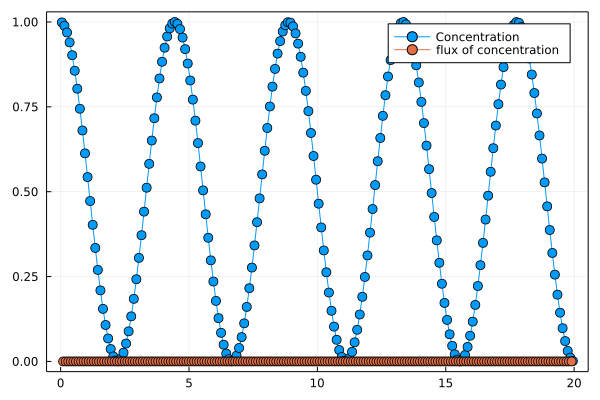

In [9]:
using Plots
plot( xc               , C , label="Concentration"        , linewidth=1.0, markershape=:circle, markersize=5, framestyle=:box)
plot!(xc[1:end-1].+dx/2, qx, label="flux of concentration", linewidth=1.0, markershape=:circle, markersize=5, framestyle=:box)

Let's implement the diffusion solver

In [10]:
using Plots,Plots.Measures,Printf
default(size=(1200,400),framestyle=:box,label=false,grid=false,margin=10mm,lw=6,labelfontsize=20,tickfontsize=20,titlefontsize=24)
@views function diffusion_1D()
    # physics
    lx   = 20.0
    dc   = 1.0
    # numerics
    nx   = 200
    nvis = 5
    # derived numerics
    dx   = lx/nx
    dt   = dx^2/dc/2
    nt   = nx^2 ÷ 100
    xc   = LinRange(dx/2,lx-dx/2,nx)
    # array initialisation
    C    = @. 0.5cos(9π*xc/lx)+0.5; C_i = copy(C)
    qx   = zeros(Float64, nx-1)
    # time loop
    @gif for it = 1:nt
        qx          .= .-dc.*diff(C )./dx
        C[2:end-1] .-=   dt.*diff(qx)./dx
        plot(xc,[C_i,C];xlims=(0,lx), ylims=(-0.1,1.1), xlabel="lx", ylabel="Concentration", title="time = $(round(it*dt,digits=1))")
    end every nvis
end

diffusion_1D (generic function with 1 method)

And execute it

┌ Info: Saved animation to 
│   fn = /Users/ludovic/Documents/git/github_vaw/course-101-0250-00/slide-notebooks/notebooks/tmp.gif
└ @ Plots /Users/ludovic/.julia/packages/Plots/FCUr0/src/animation.jl:137


Plots.AnimatedGif("/Users/ludovic/Documents/git/github_vaw/course-101-0250-00/slide-notebooks/notebooks/tmp.gif")
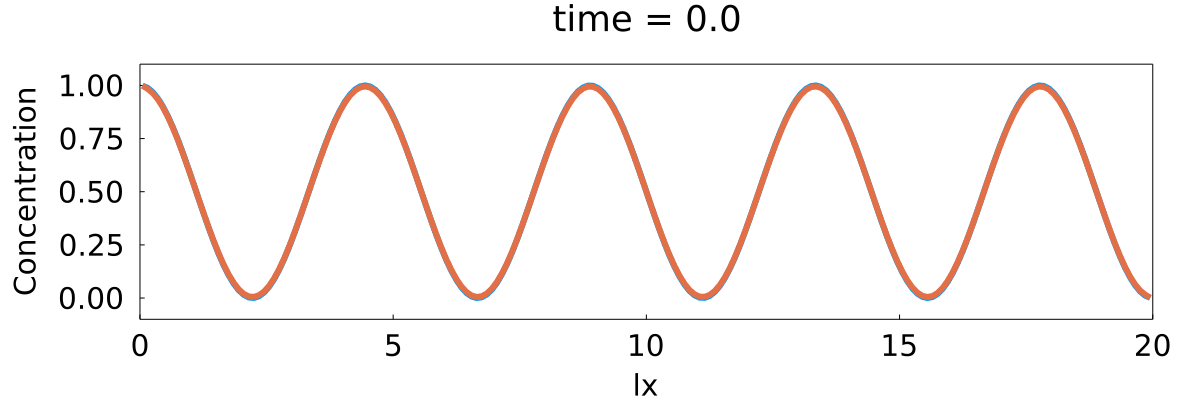

In [11]:
diffusion_1D()

Note: plotting and visualisation is slow. A convenient workaround is to only visualise or render the figure every `nvis` iteration within the time loop

```julia
@gif for it = 1:nt
    # plot(...)
end every nvis
```

## Hyperbolic PDEs - acoustic wave propagation

### The wave equation

... is a second-order partial differential equation.

> The [wave equation](https://en.wikipedia.org/wiki/Wave_equation) is a second-order linear partial differential equation for the description of waves—as they occur in classical physics—such as mechanical waves (e.g. water waves, sound waves and seismic waves) or light waves. [_Wikipedia_](https://en.wikipedia.org/wiki/Wave_equation)

The hyperbolic equation reads

$$ \frac{∂^2P}{∂t^2} = c^2 ∇^2 P~,$$

where
- $P$ is pressure (or, displacement, or another scalar quantity...)
- $c$ a real constant (speed of sound, stiffness, ...)

The wave equation can be elegantly derived, e.g., from [Hooke's law](https://en.wikipedia.org/wiki/Wave_equation#From_Hooke's_law) and second law of Newton considering masses interconnected with springs.

![hook](./figures/hooke.png)

$$ F_\mathrm{Newton}~~=~~F_\mathrm{Hook}~,$$

$$ m⋅a(t)~~=~~k x_+ - k x_-~,$$

where $m$ is the mass, $k$ de spring stiffness, and $x_+$, $x_-$ the oscillations of the masses (small distances).

$$ m⋅a(t)~~=~~k x_+ - k x_-~,$$

The acceleration $a(t)$ can be substituted by the second derivative of displacement $u$ as function of time $t$, $∂^2u/∂t^2$, while balancing $x_+ - x_-$ and taking the limit leads to $∂^2u/∂x^2$.

### Back to the wave equation

The objective is to implement the wave equation in 1D (spatial discretisation) using an explicit time integration (forward Euler) as for the diffusion physics.

Our first task will be to modify the diffusion equation...

... in order to obtain and implement the acoustic wave equation:

<center>
  <video width="80%" autoplay loop controls src="./figures/acoustic_1D.mp4"/>
</center>

### From diffusion to acoustic wave propagation

We won't implement first the hyperbolic equation as introduced, but rather start from a first order system, similar to the one that we used to implement the diffusion equation.

To this end, we can rewrite the second order wave equation

$$ \frac{∂^2 P}{∂t^2} = c^2 ∇^2 P~,$$

as two first order equations

$$ \frac{∂V_x}{∂t} = -\frac{1}{ρ}~\frac{∂P}{∂x}~,$$

$$ \frac{∂P}{∂t}  = -\frac{1}{\beta}~\frac{∂V_x}{∂x}~.$$

Let's get started.

👉 [Download the `diffusion_1D.jl` script](https://github.com/eth-vaw-glaciology/course-101-0250-00/blob/main/scripts/) to get you started

We can start modifying the diffusion code's, adding `ρ` and `β` in `# physics` section, and taking a Gaussian (centred in `lx/2`) as initial condition for the pressure `Pr`

```julia
# physics
lx   = 20.0
ρ,β  = 1.0,1.0

# array initialisation
#Pr  =  exp.(...)
```

> 💡 hint: The time step needs a new definition: `dt = dx/sqrt(1/ρ/β)`

Then, the diffusion physics:

```julia
qx          .= .-dc.*diff(C )./dx
C[2:end-1] .-=   dt.*diff(qx)./dx
```

Should be modified to account for pressure `Pr` instead of concentration `C`, the velocity update (`Vx`) added, and the coefficients modified:

```julia
Vx          .-= ...
Pr[2:end-1] .-= ...
```

### Compare the equations

Comparing diffusive and wave physics, we can summarise following:

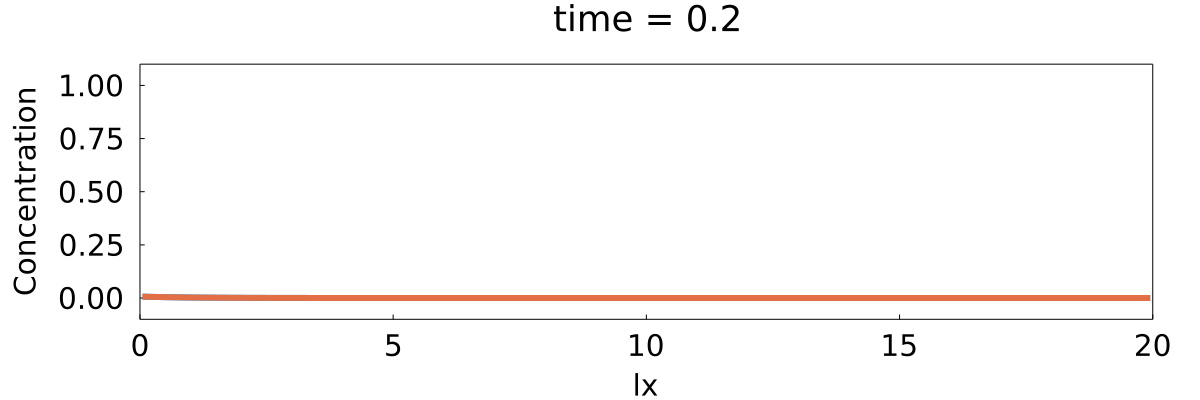

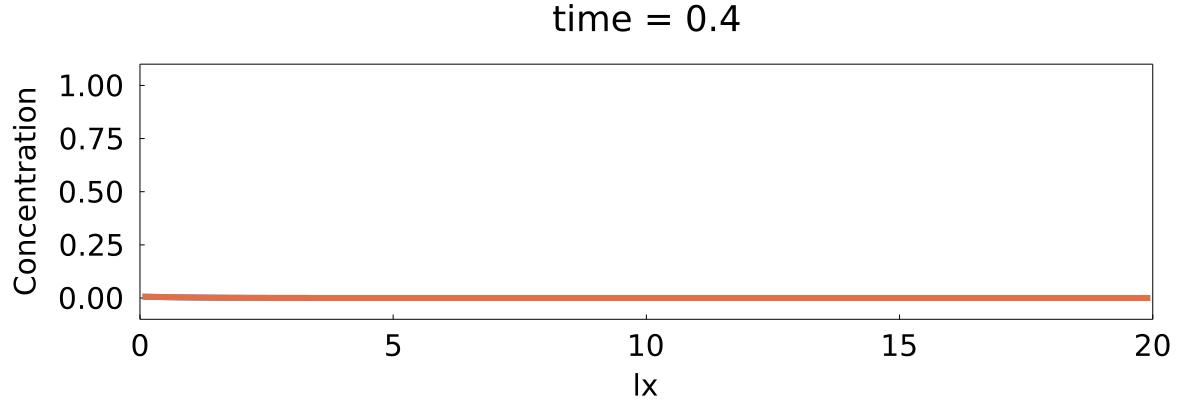

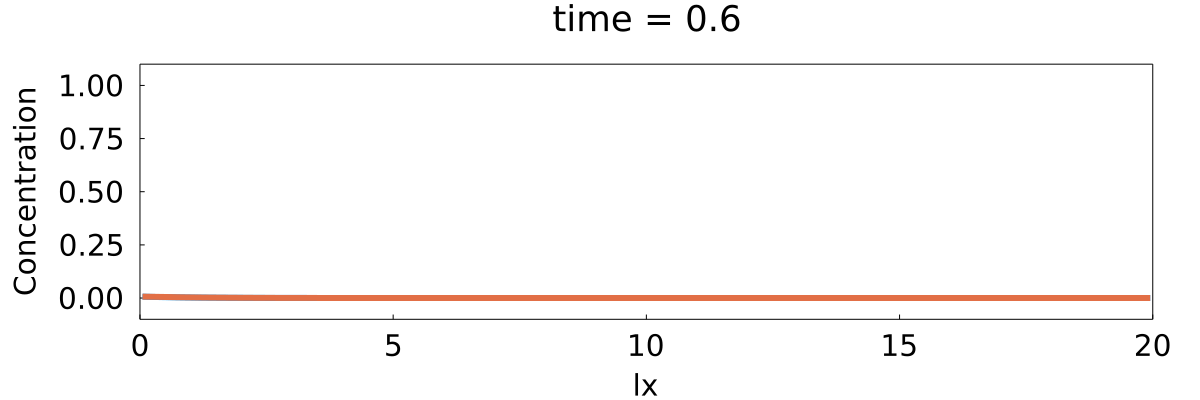

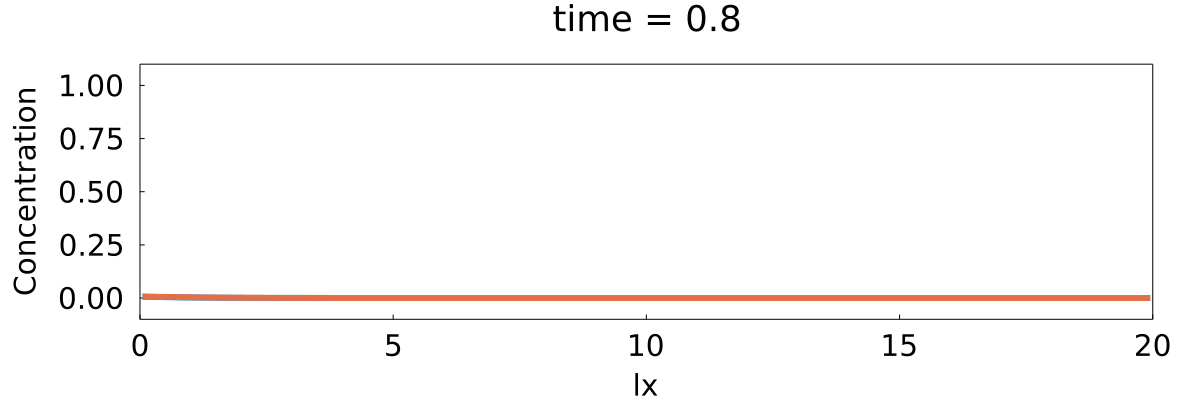

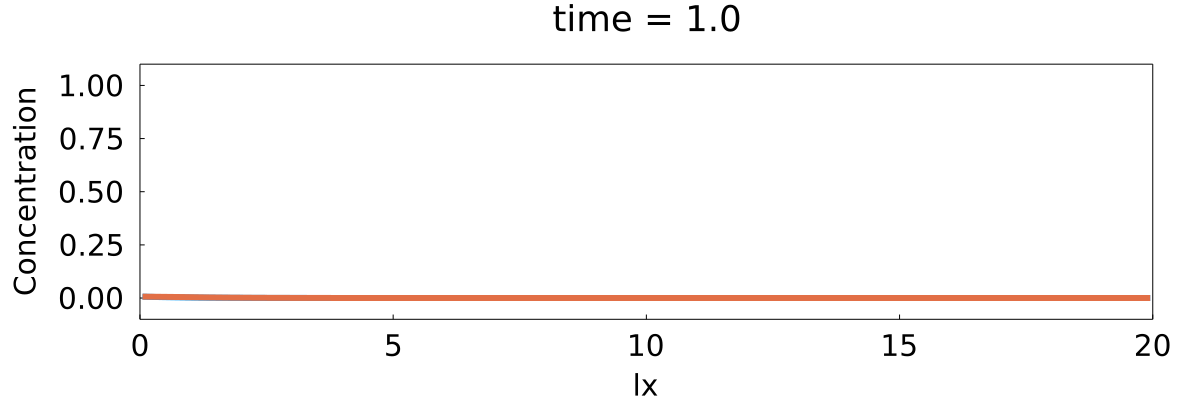

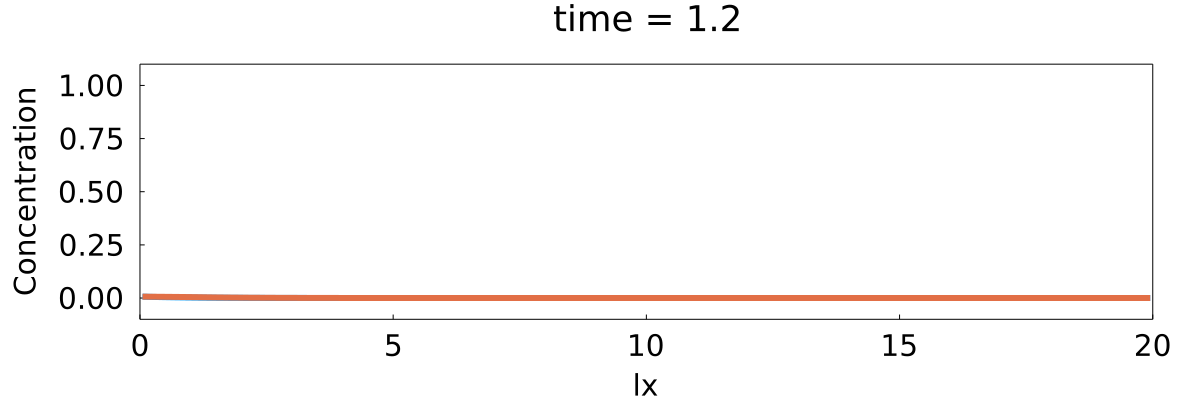

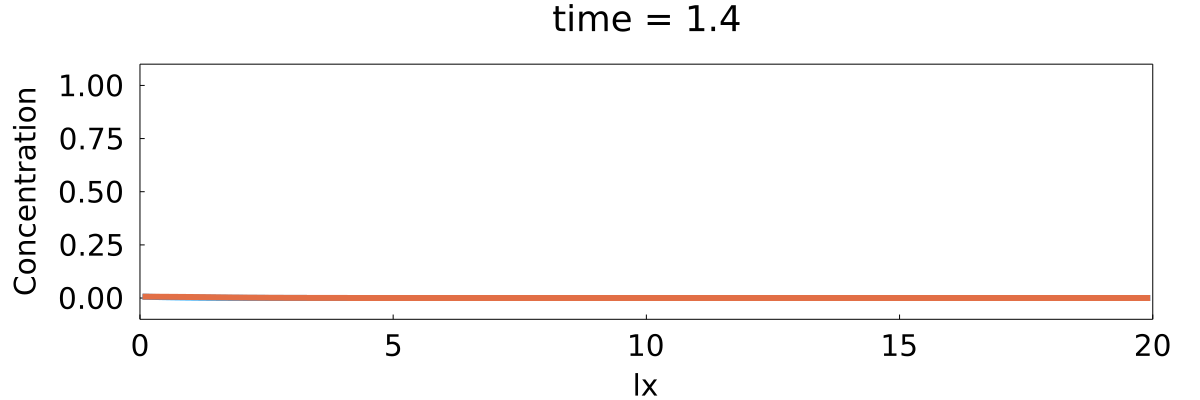

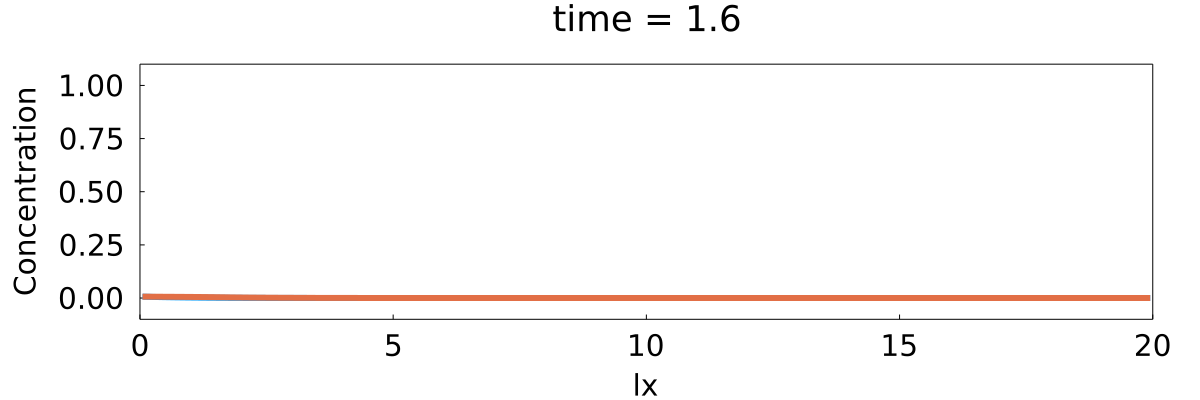

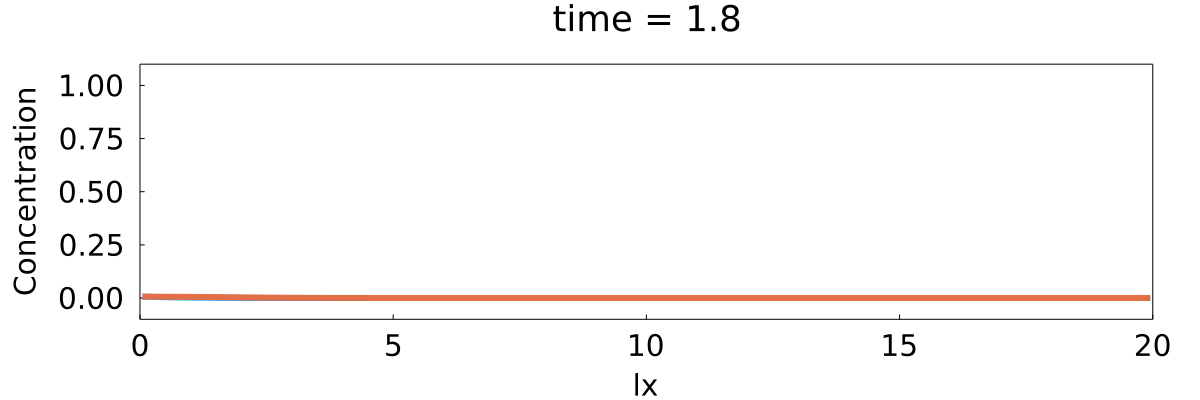

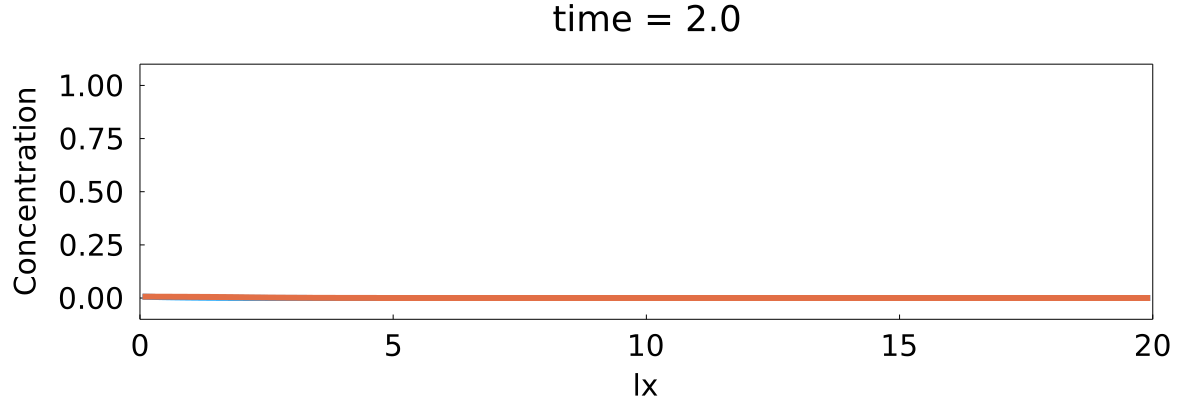

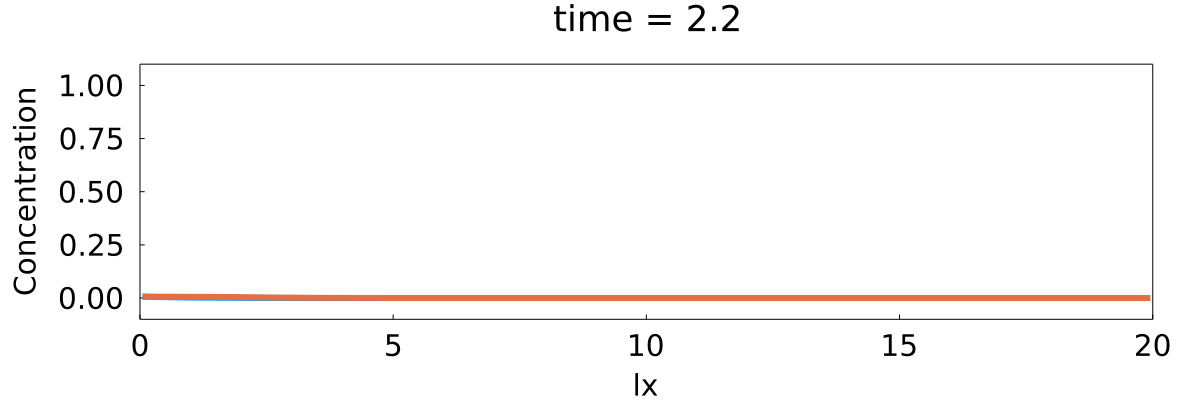

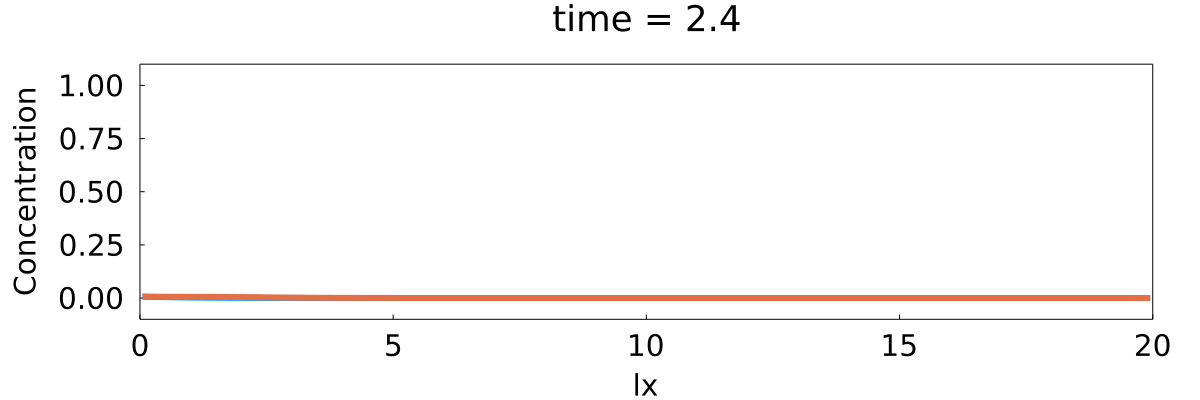

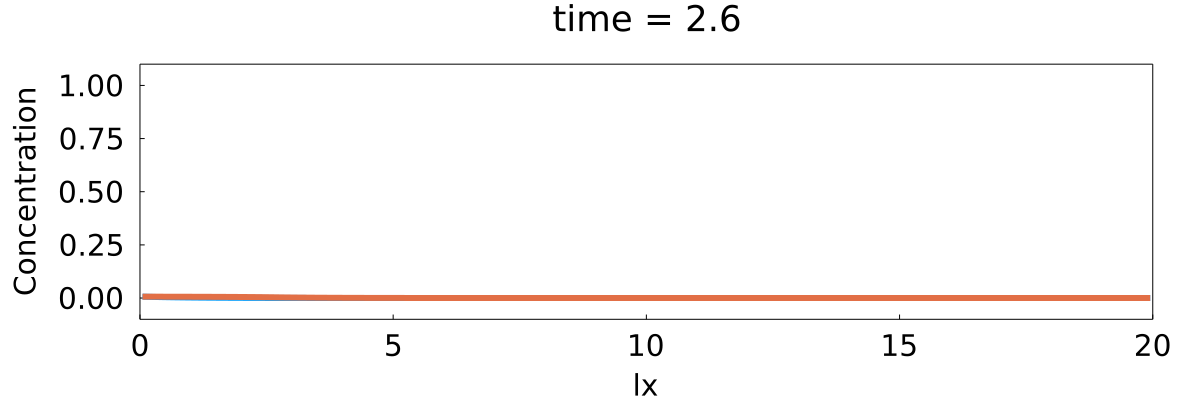

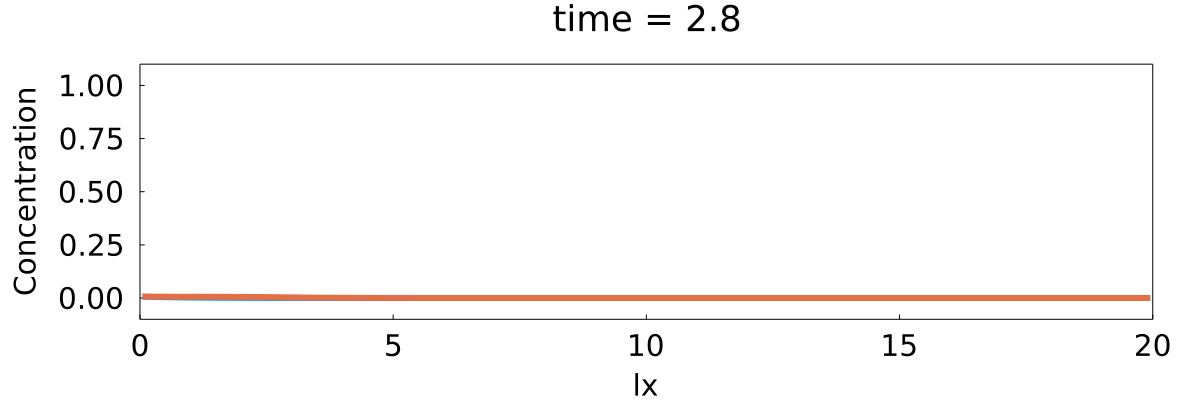

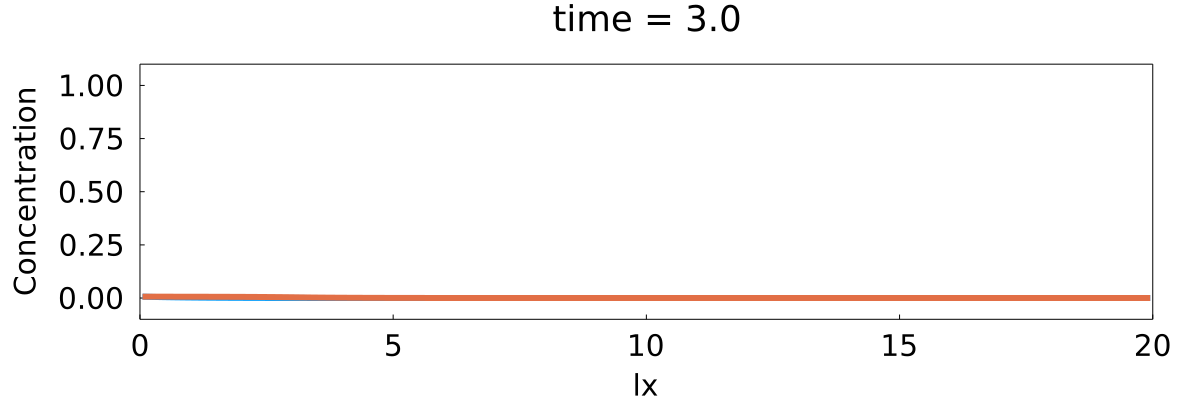

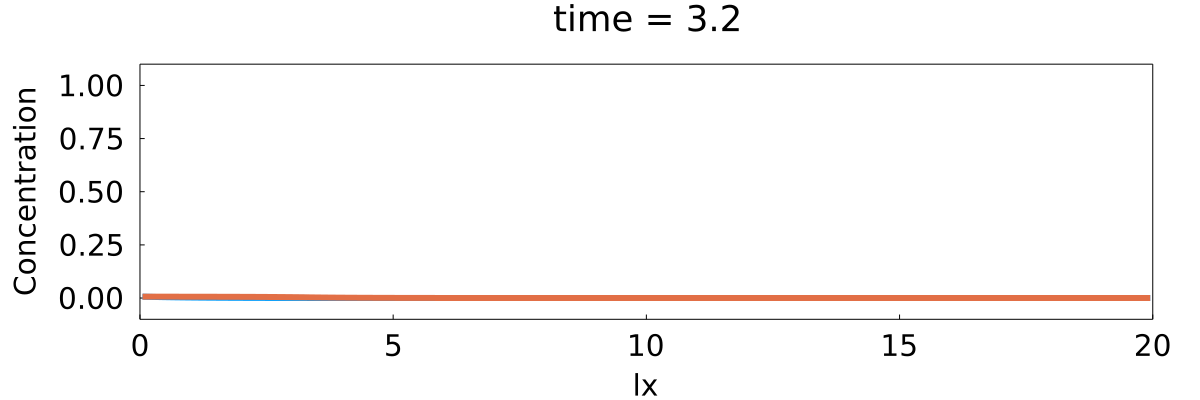

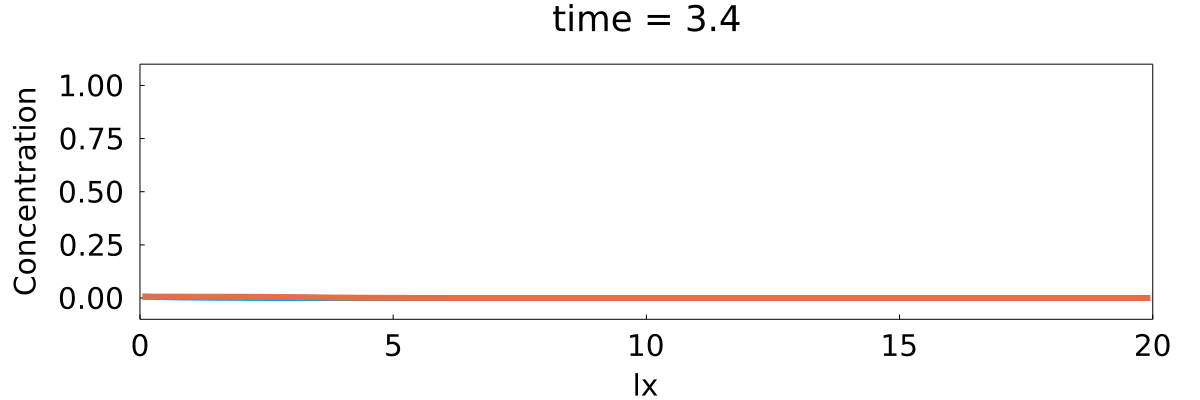

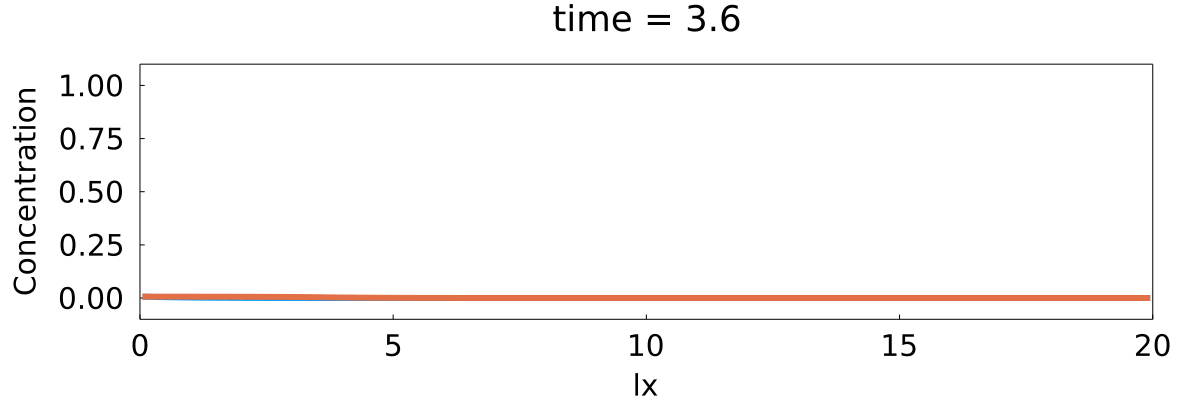

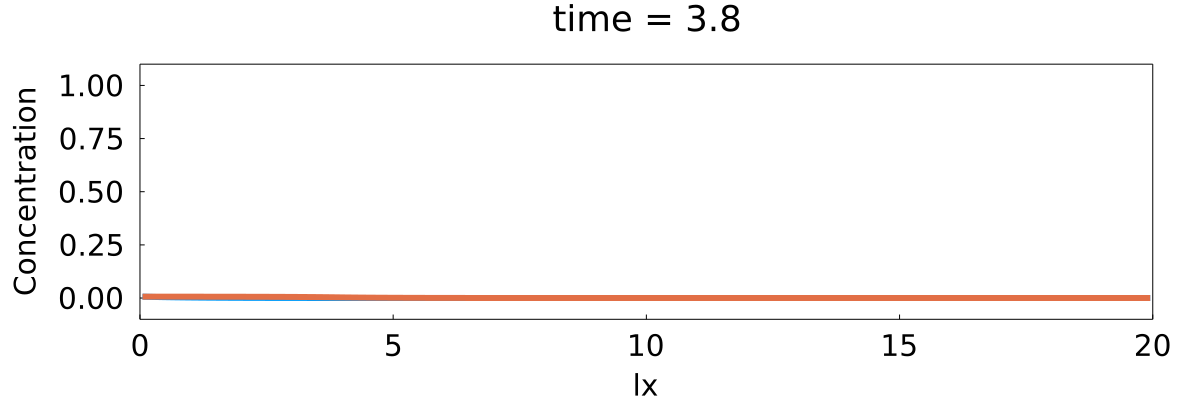

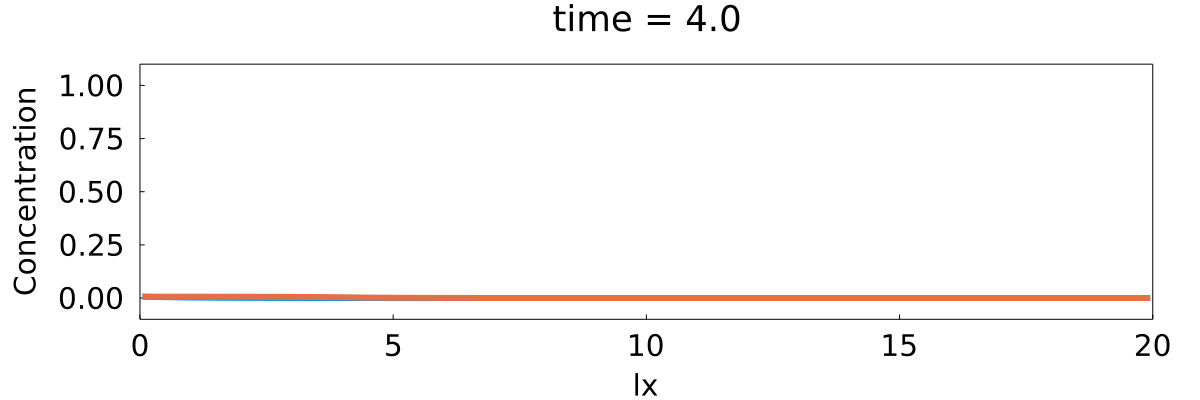

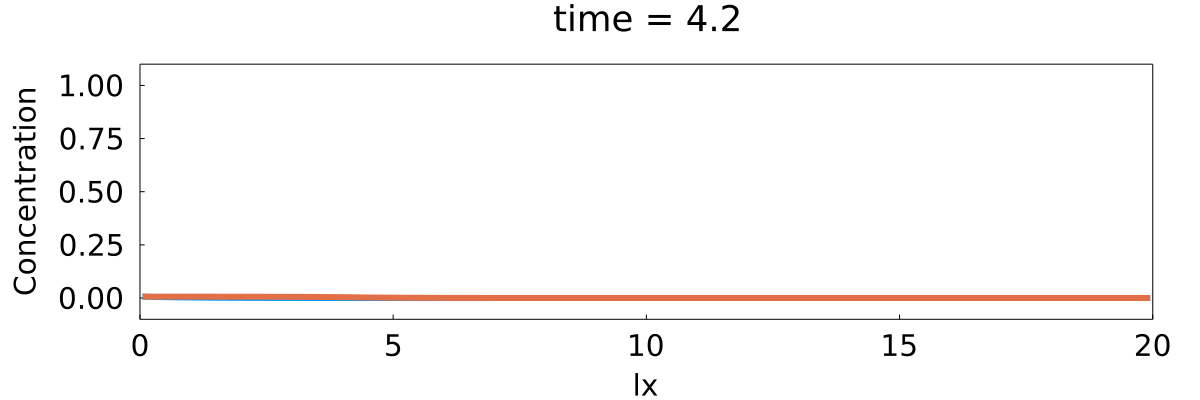

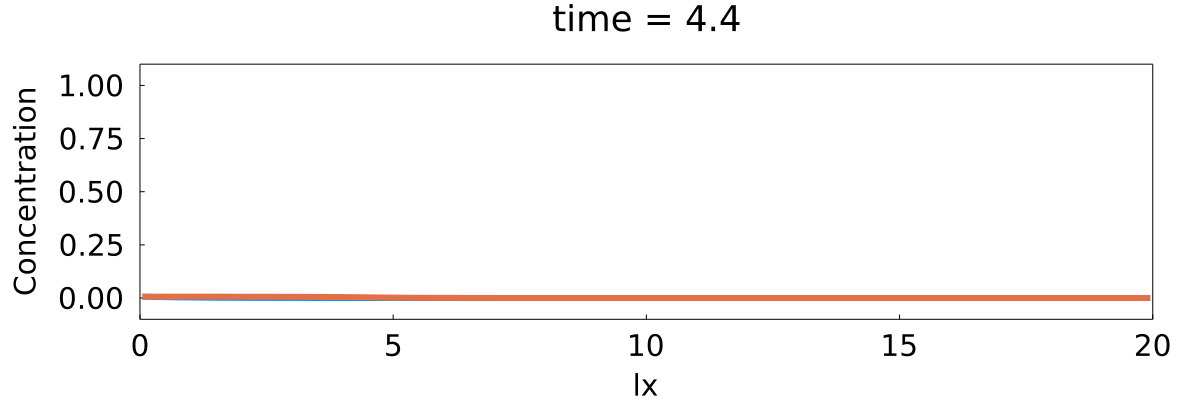

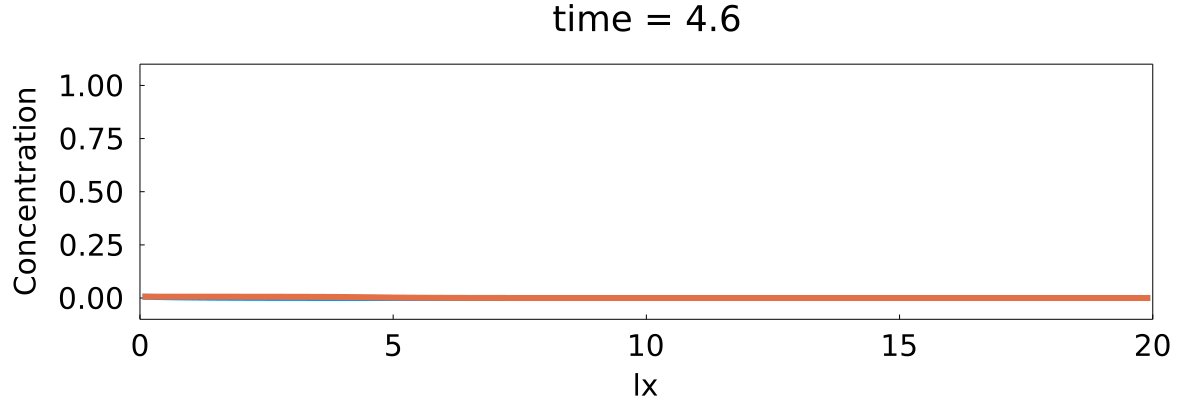

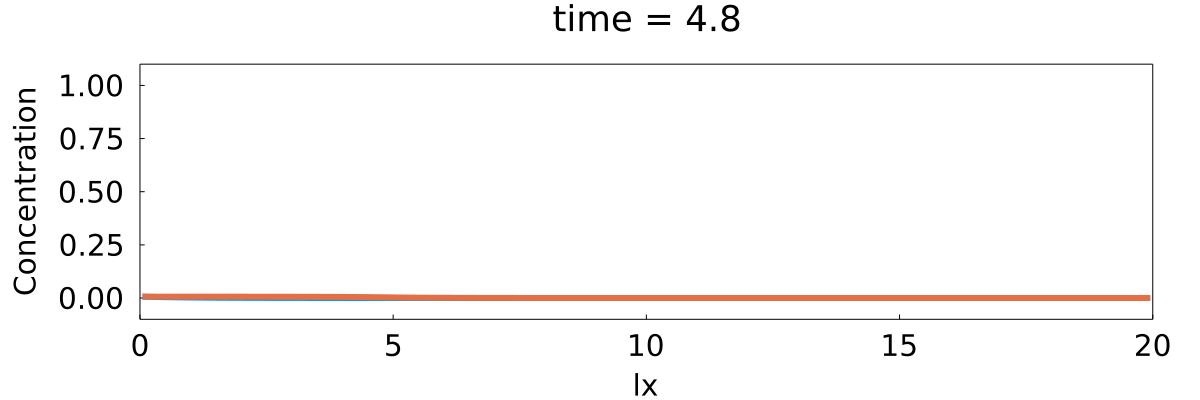

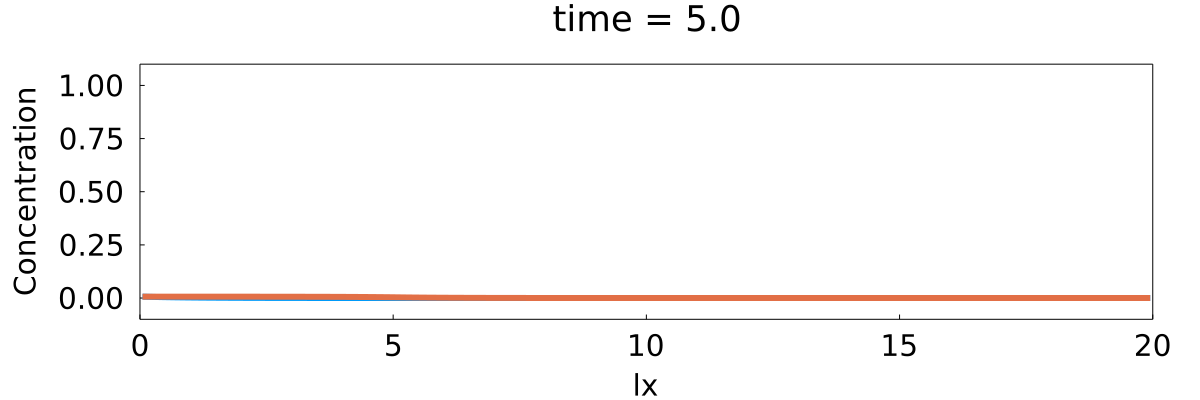

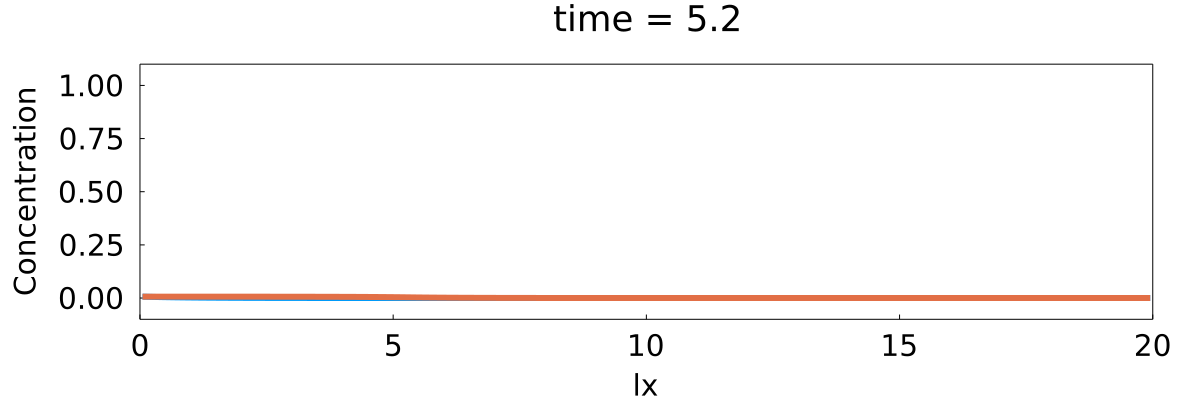

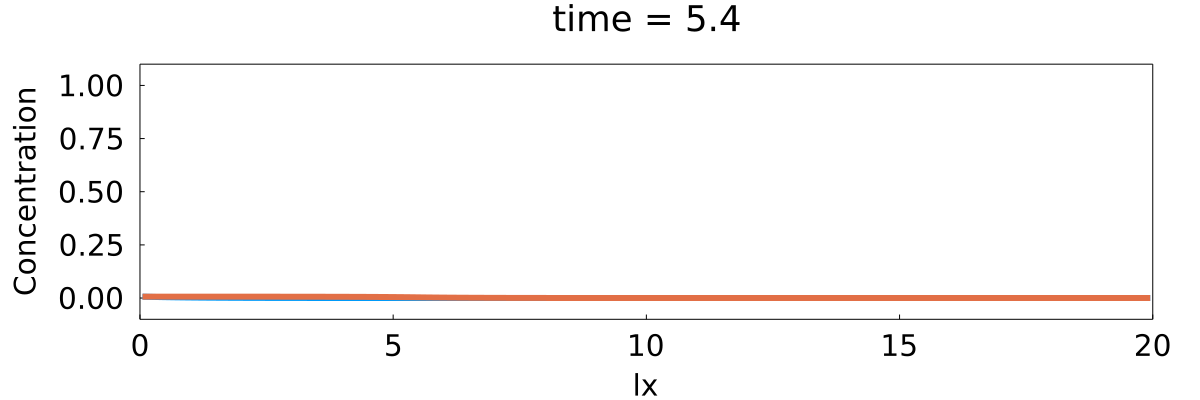

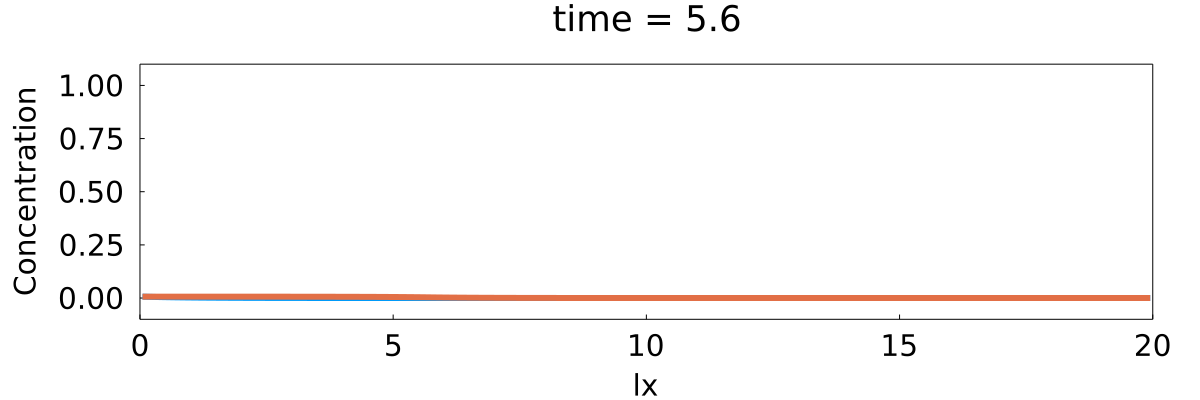

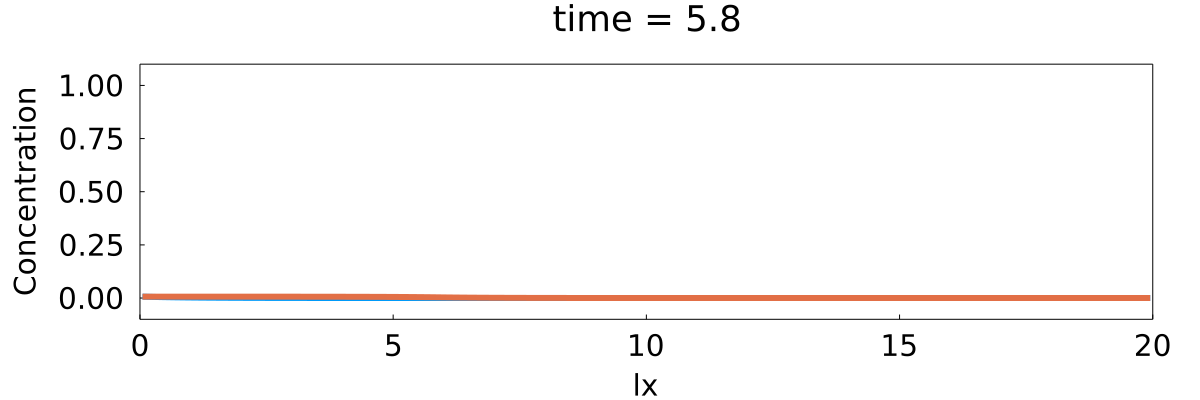

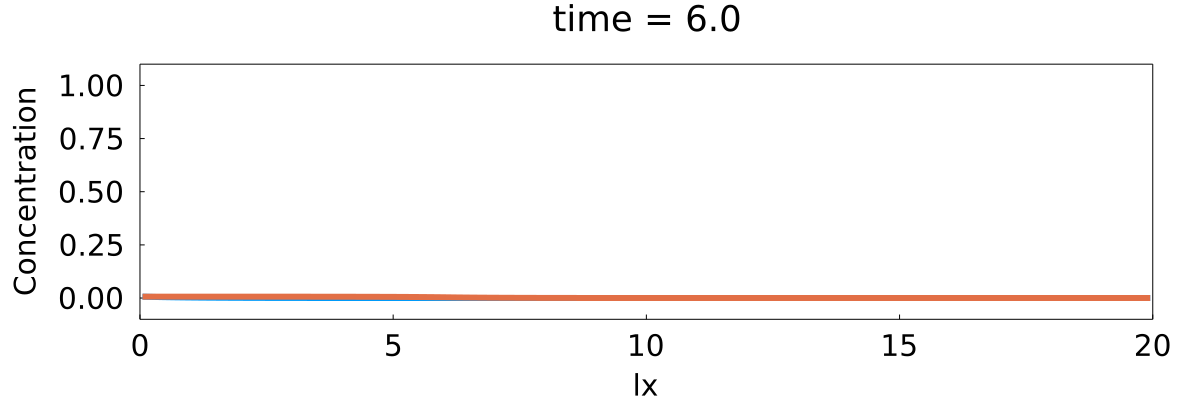

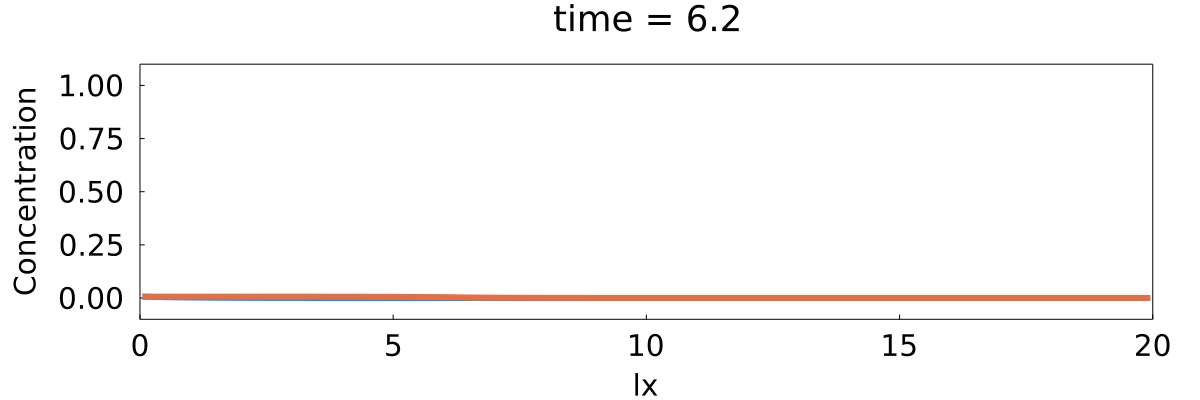

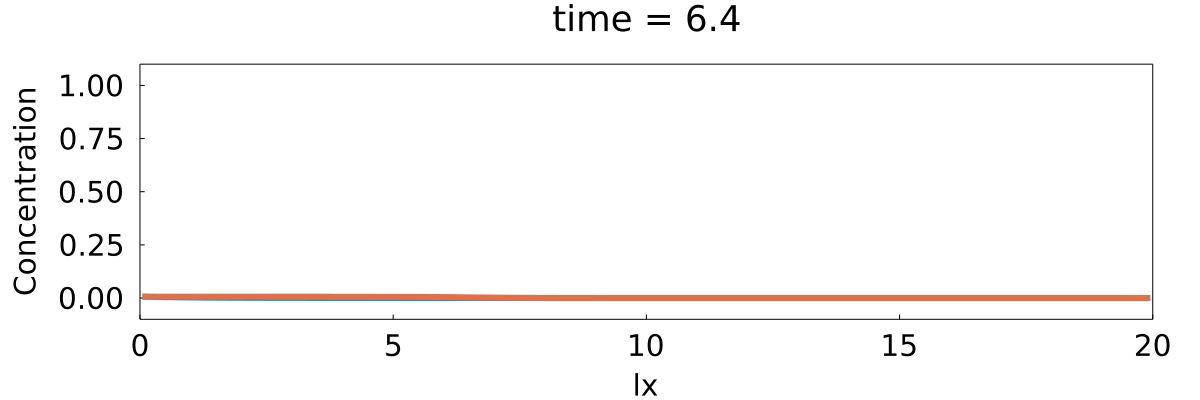

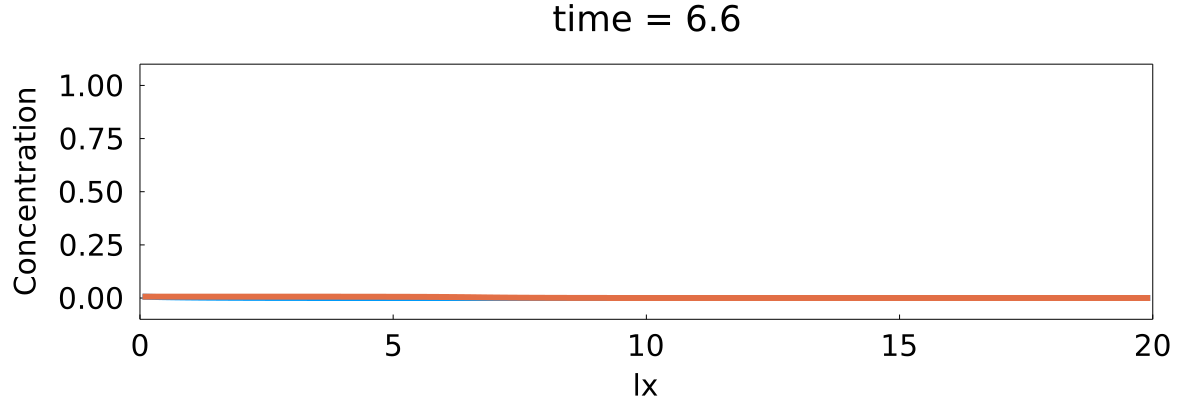

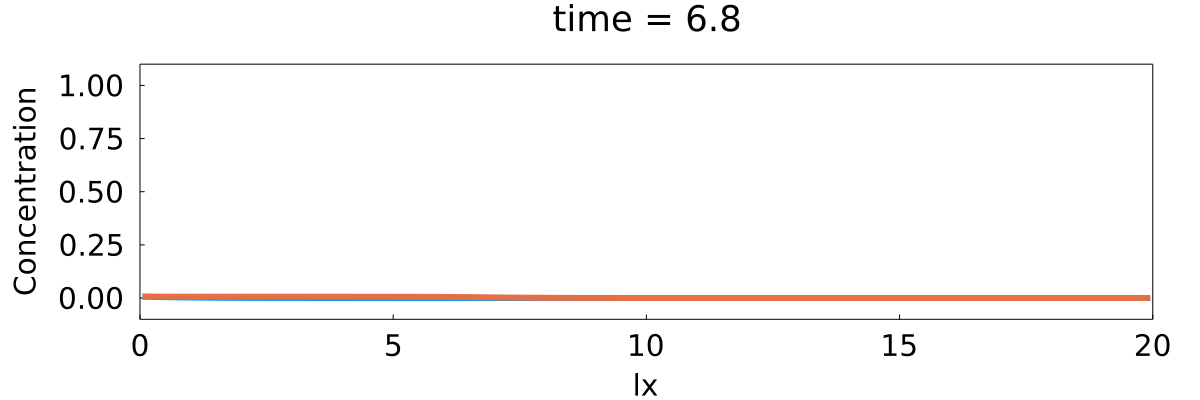

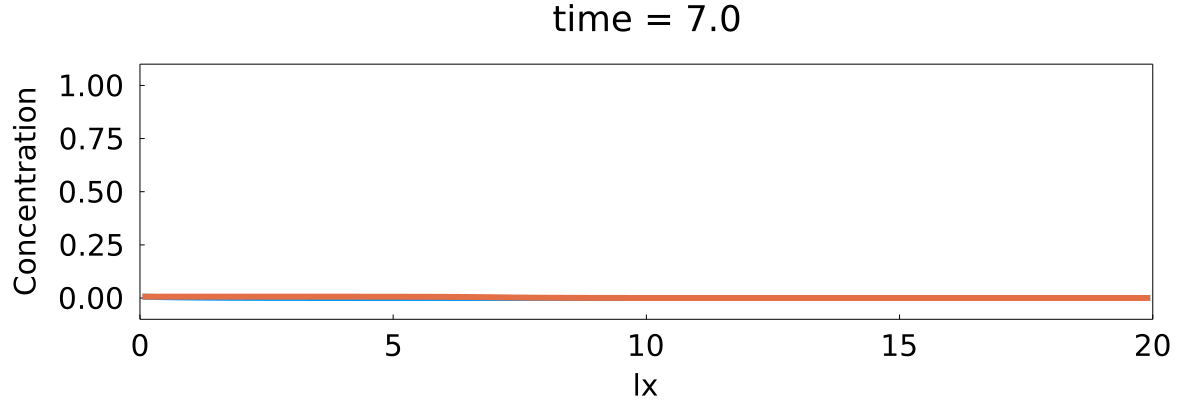

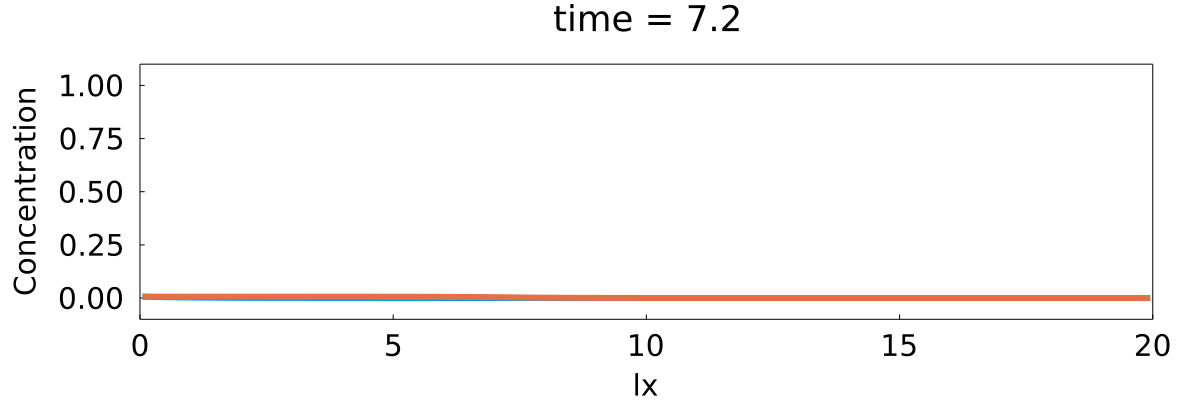

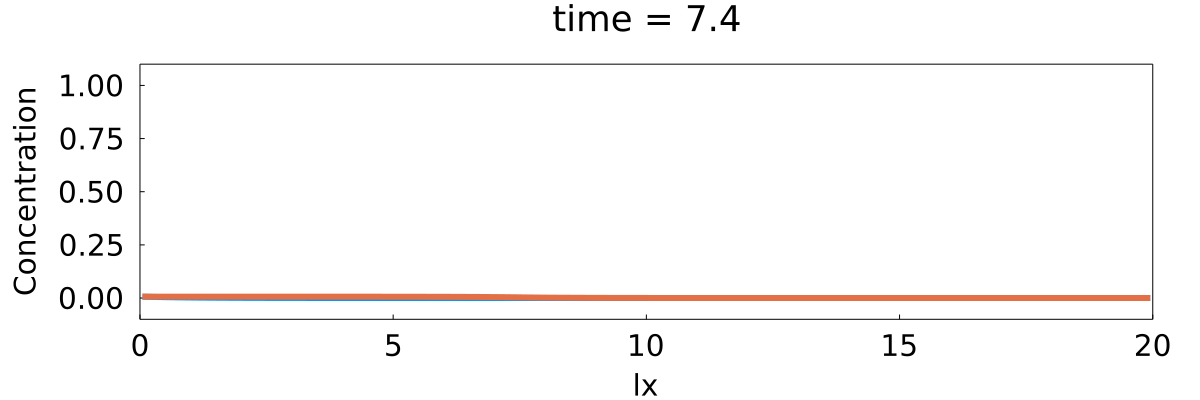

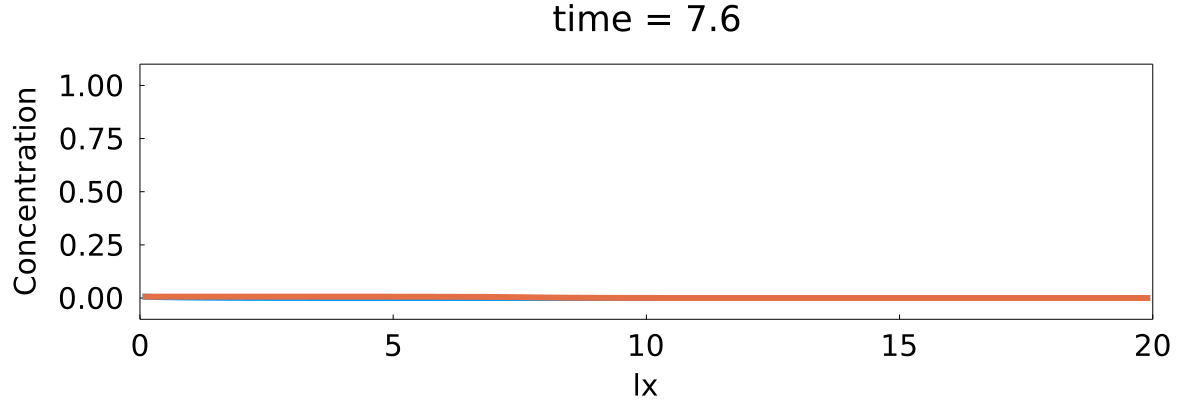

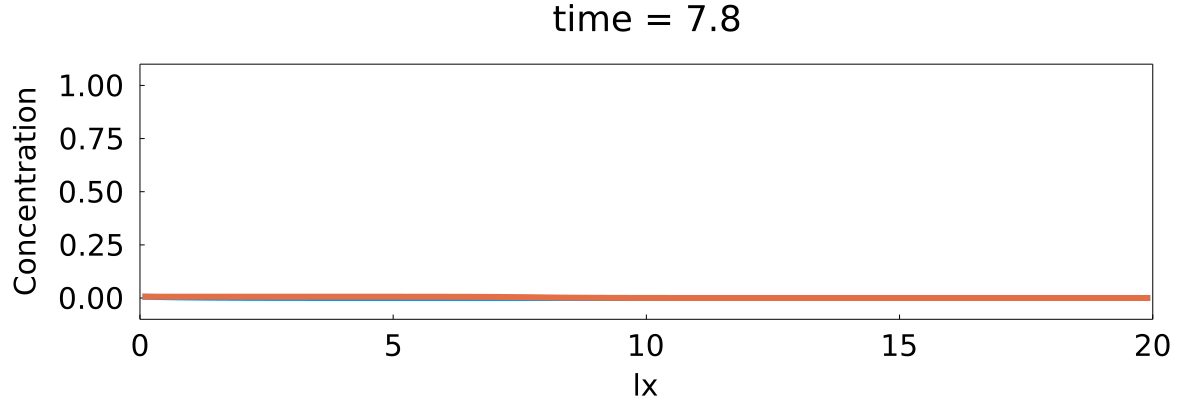

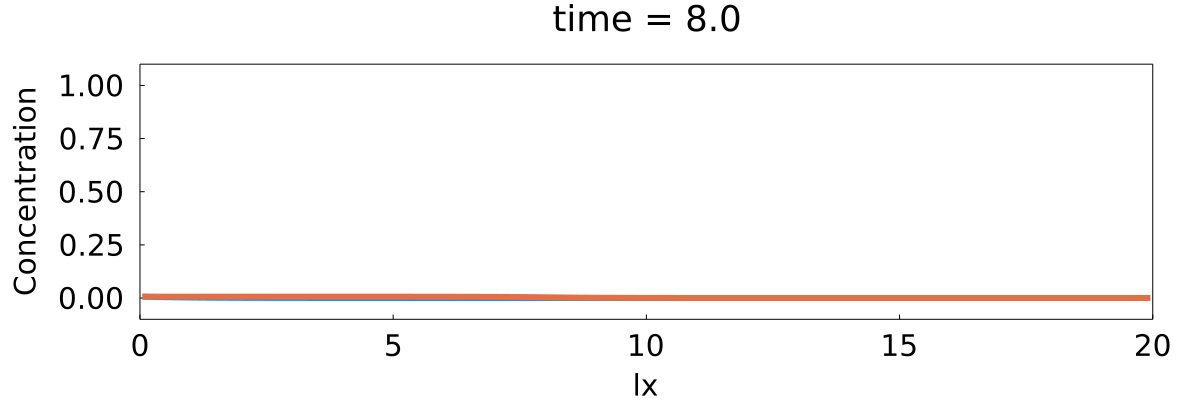

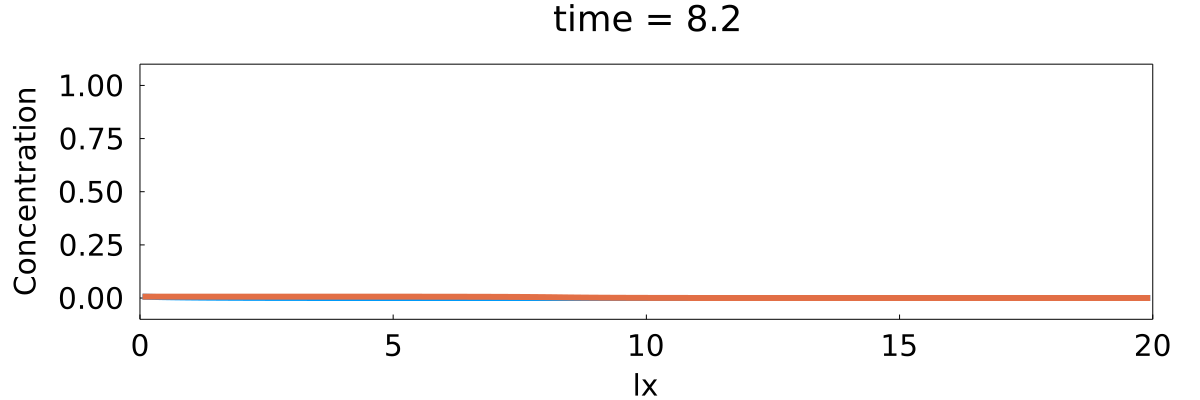

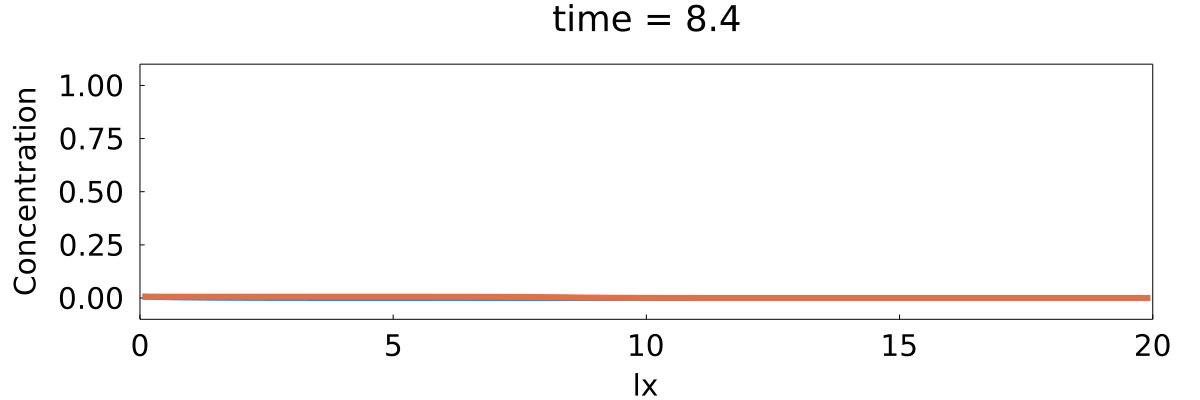

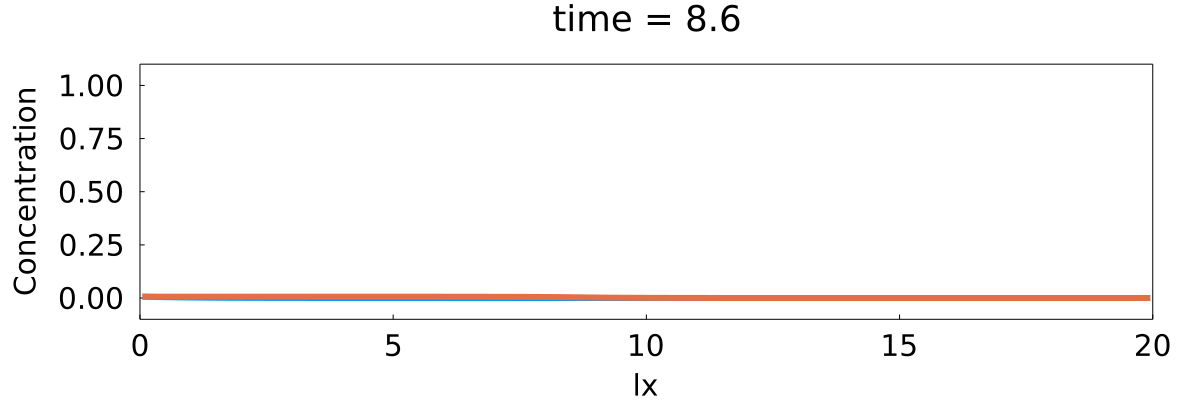

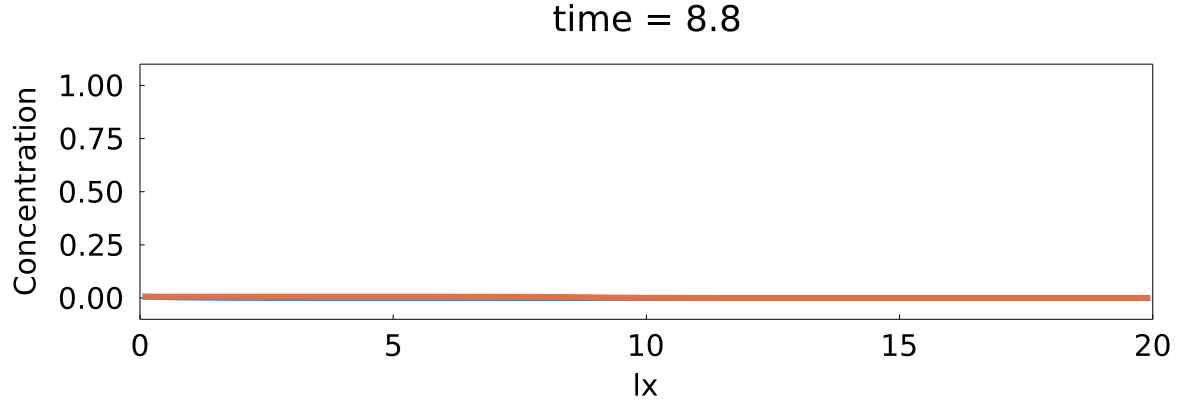

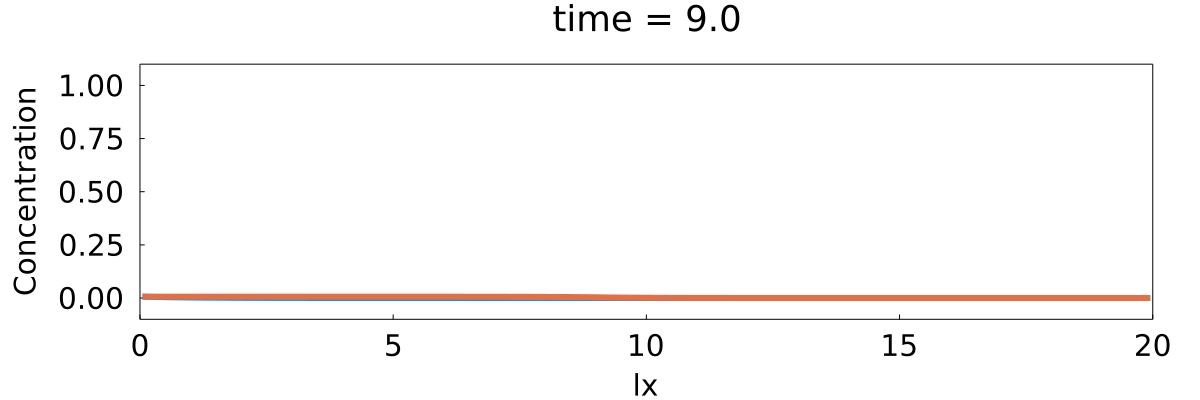

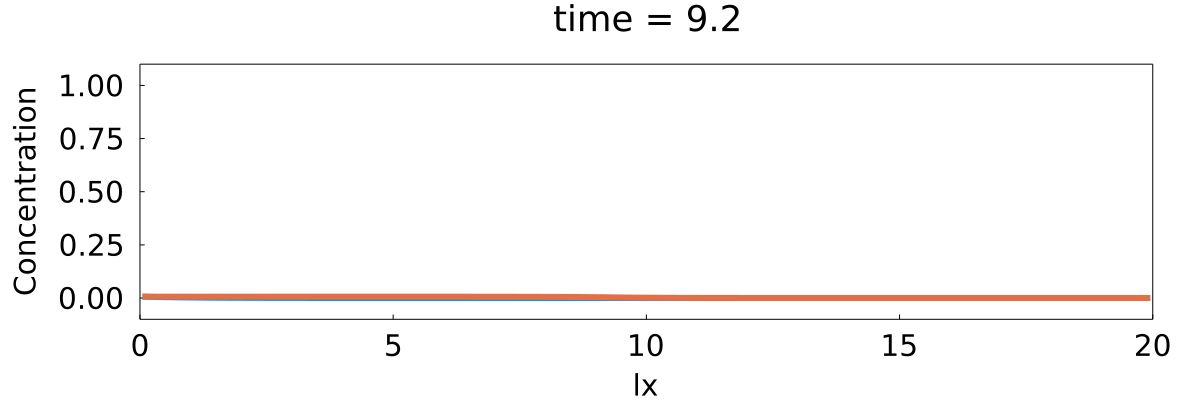

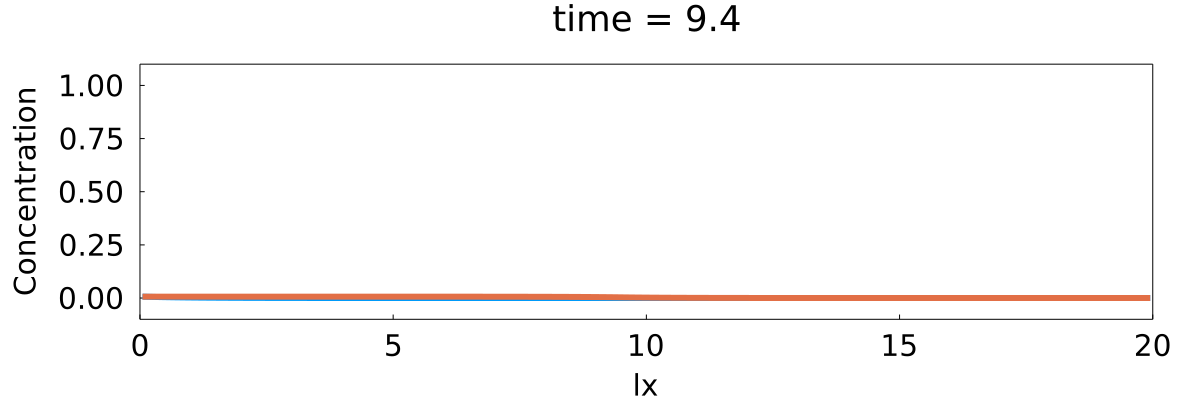

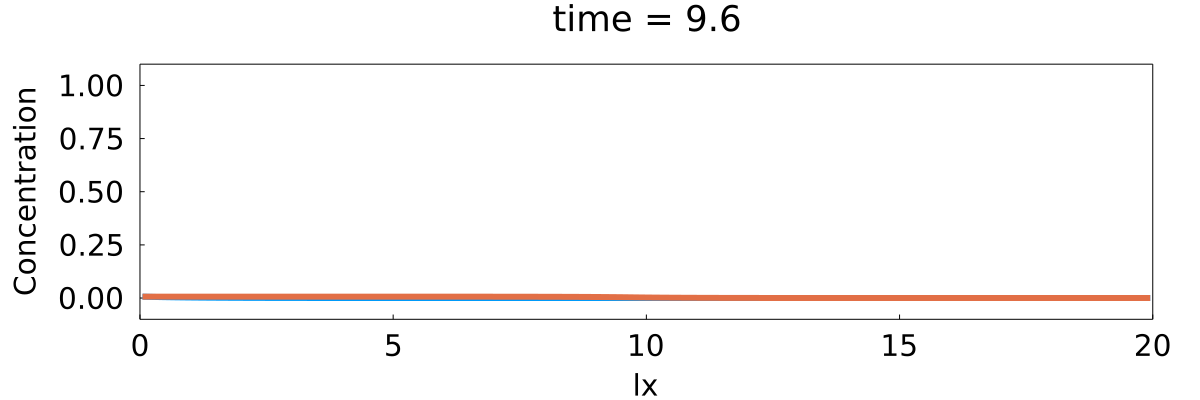

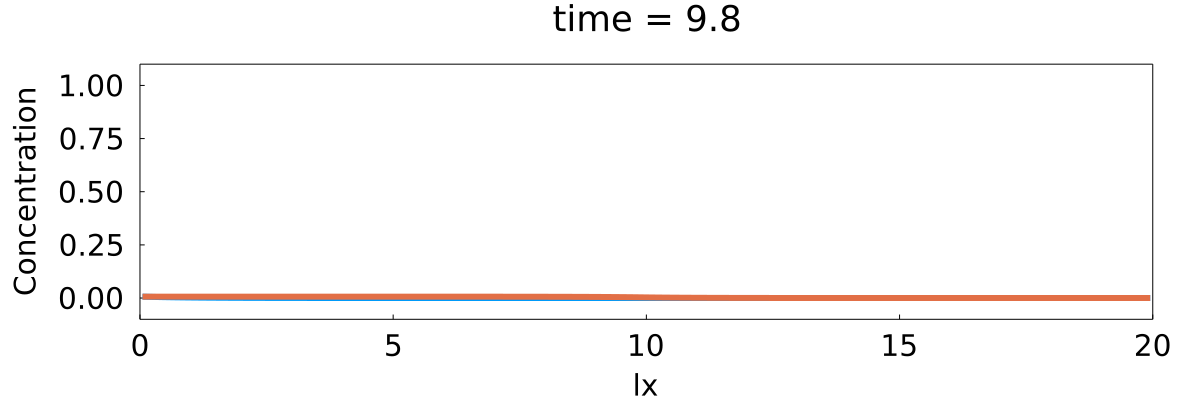

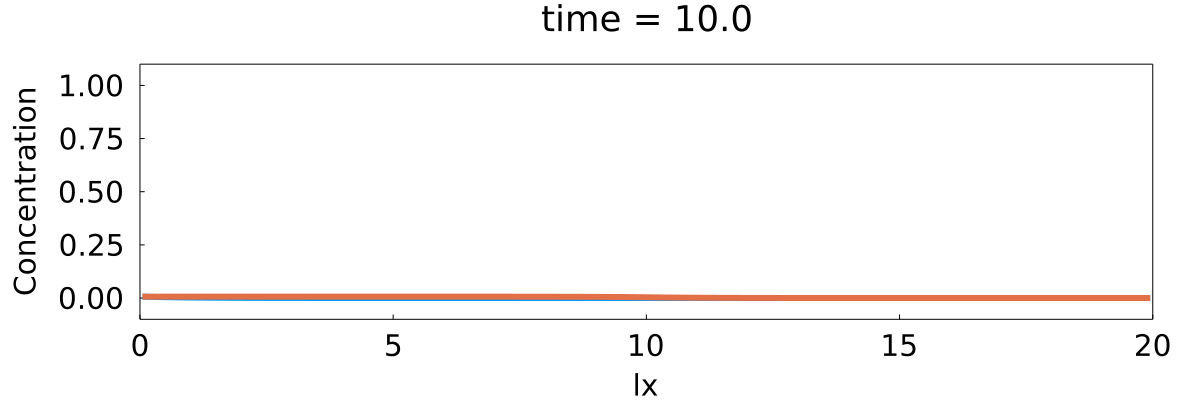

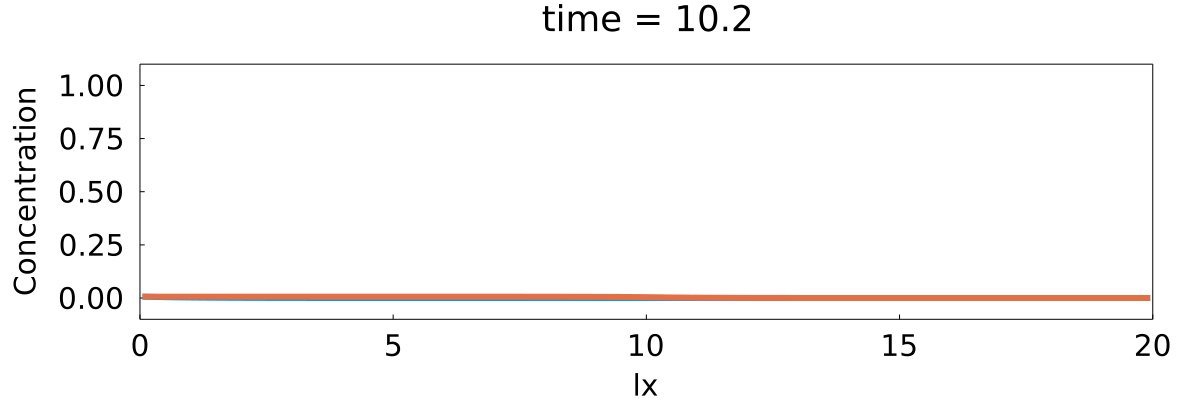

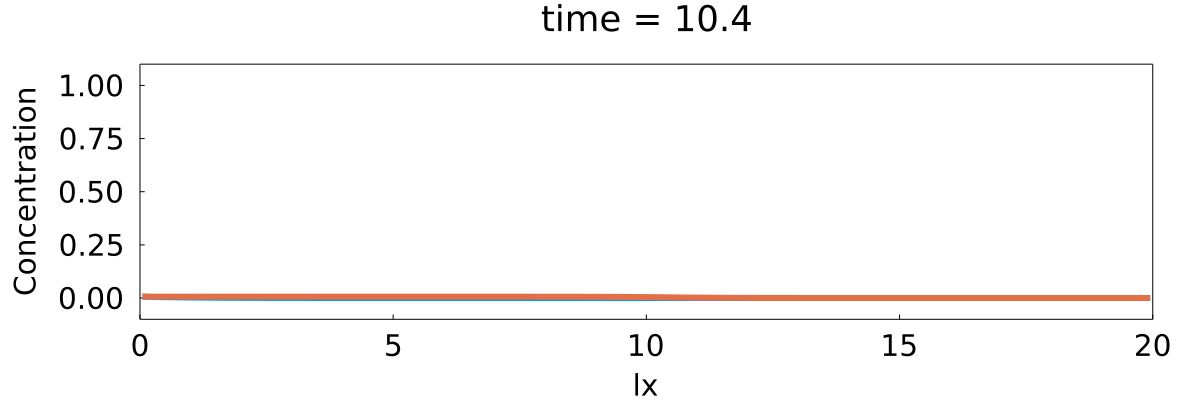

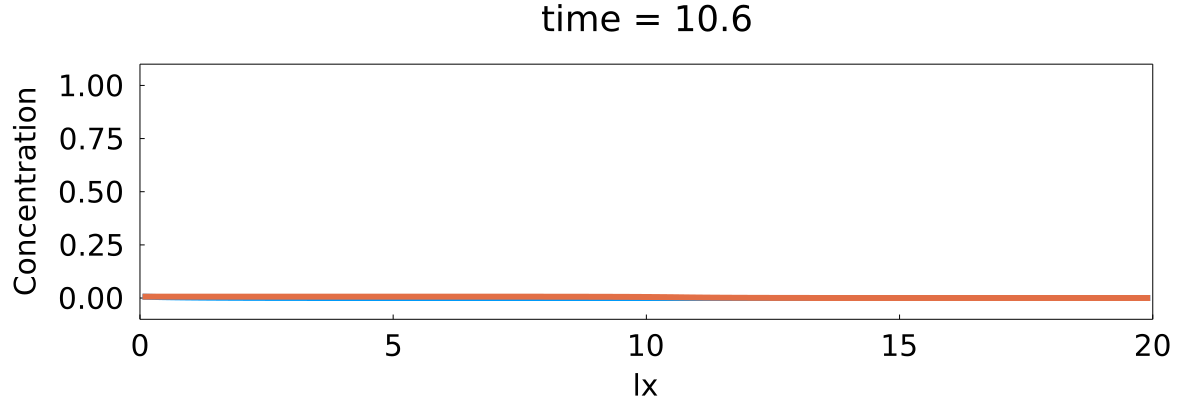

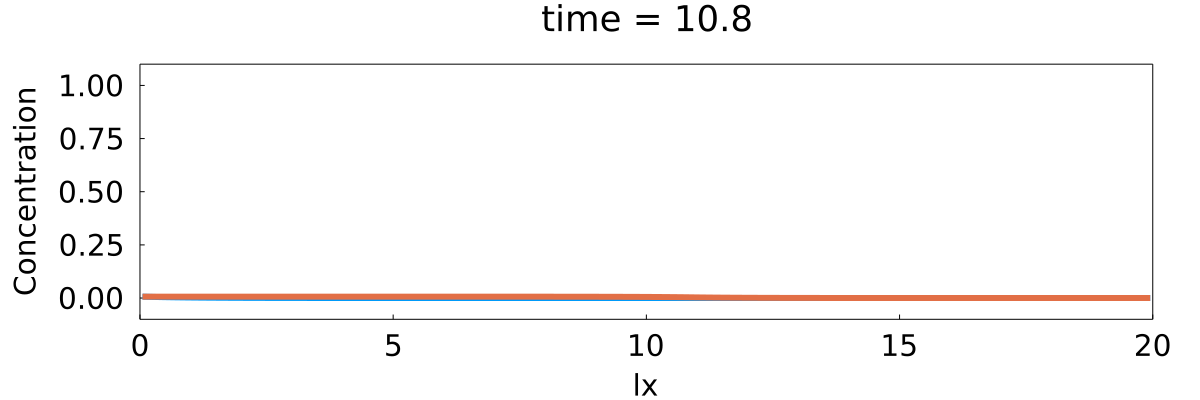

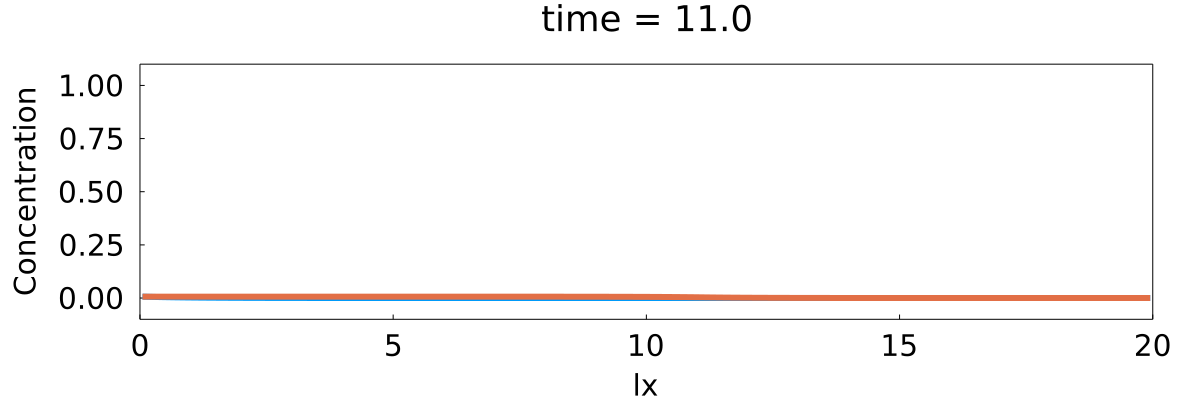

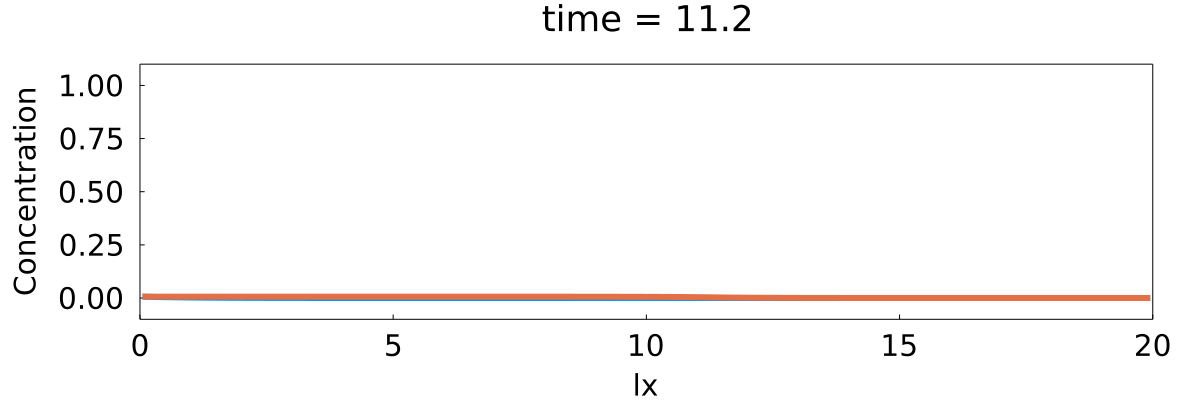

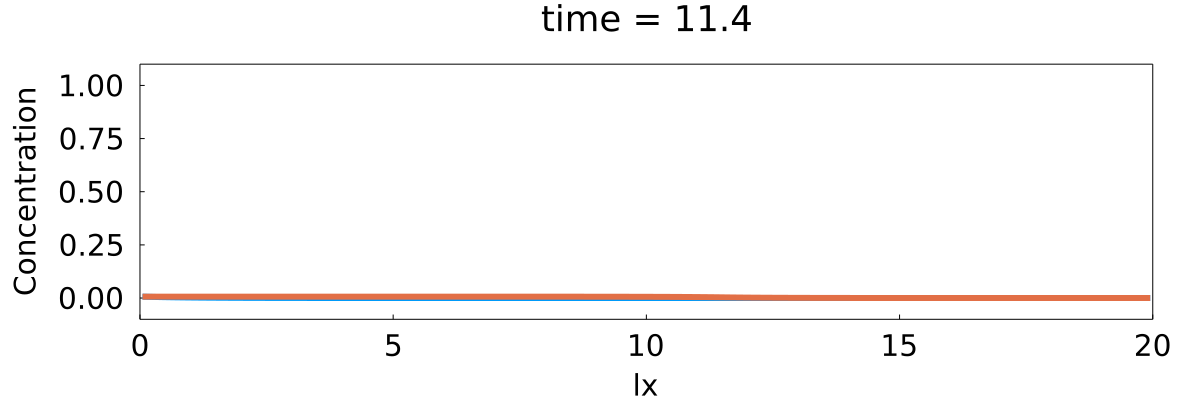

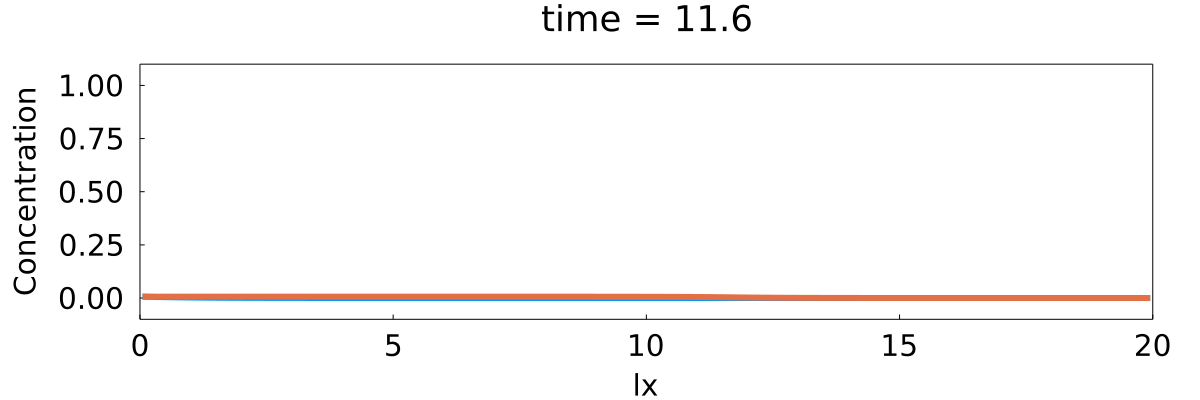

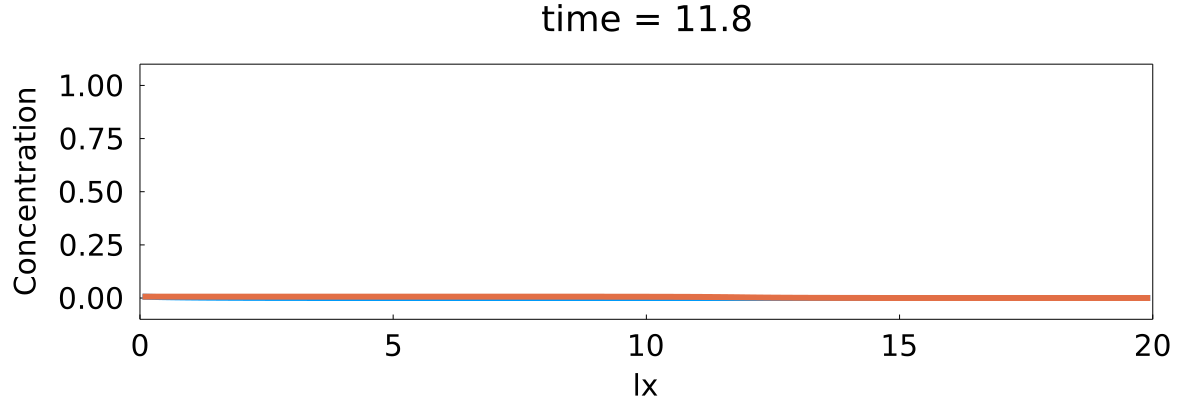

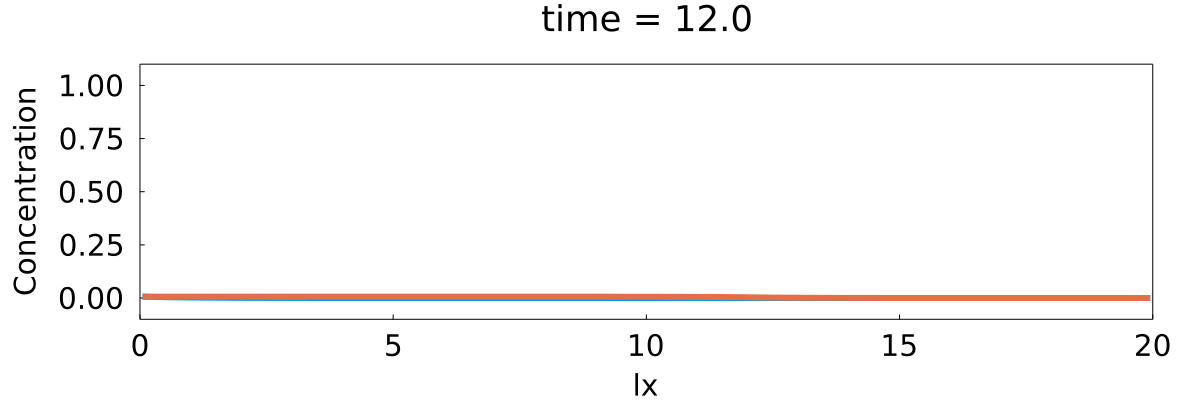

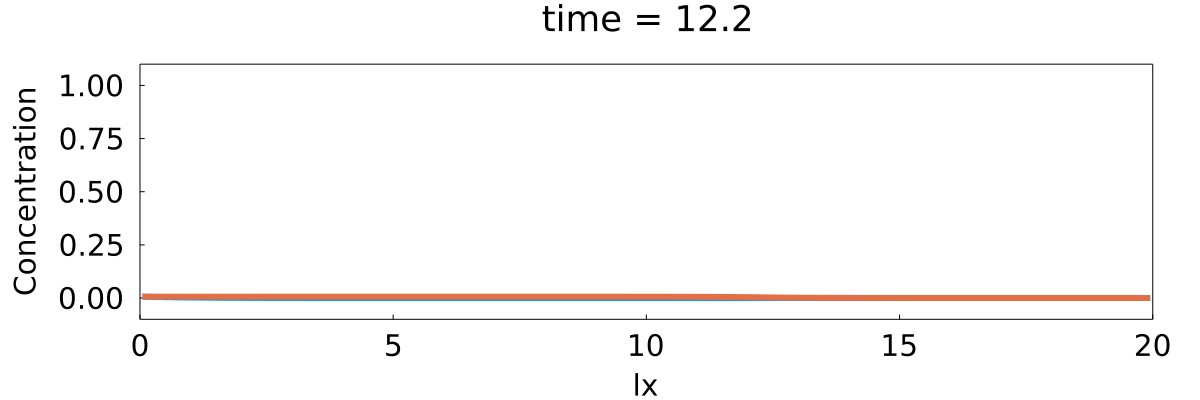

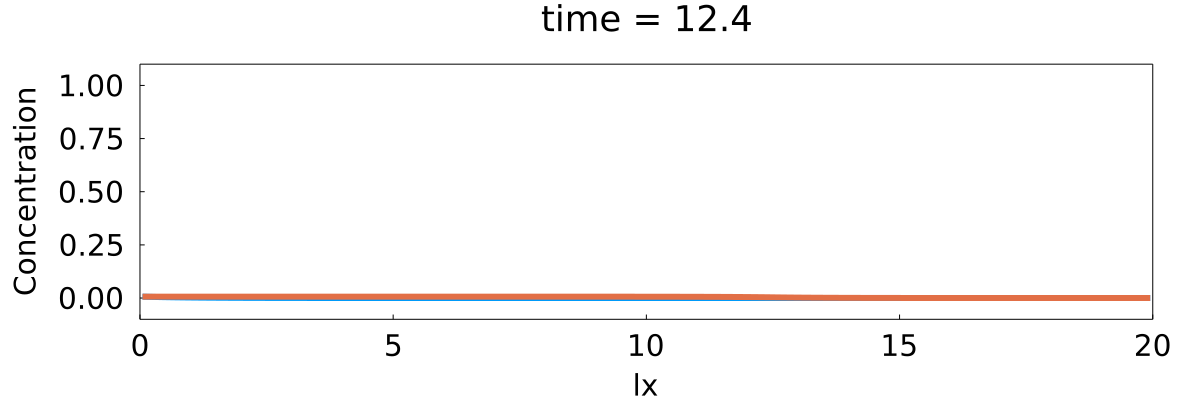

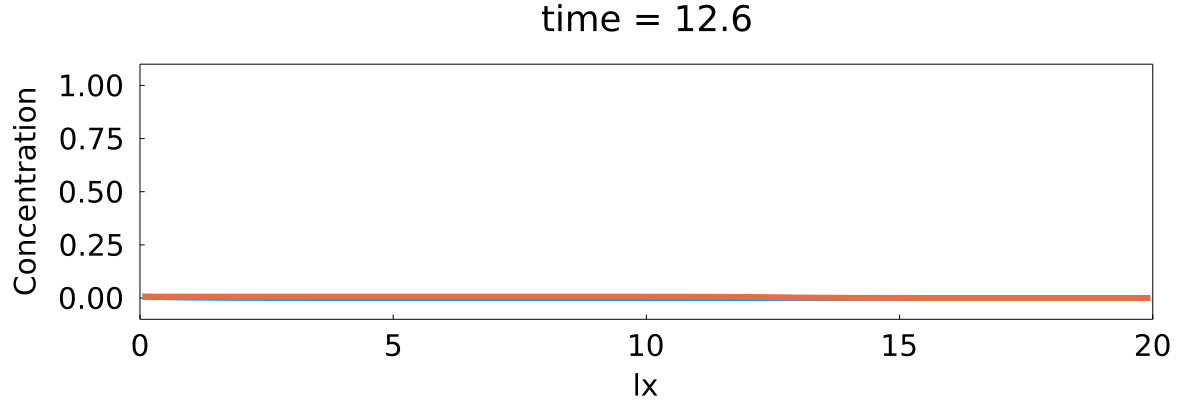

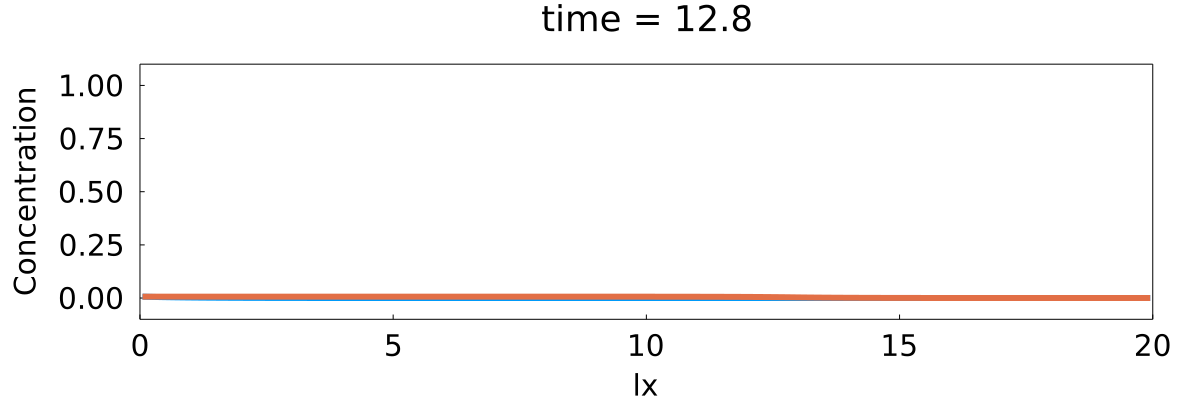

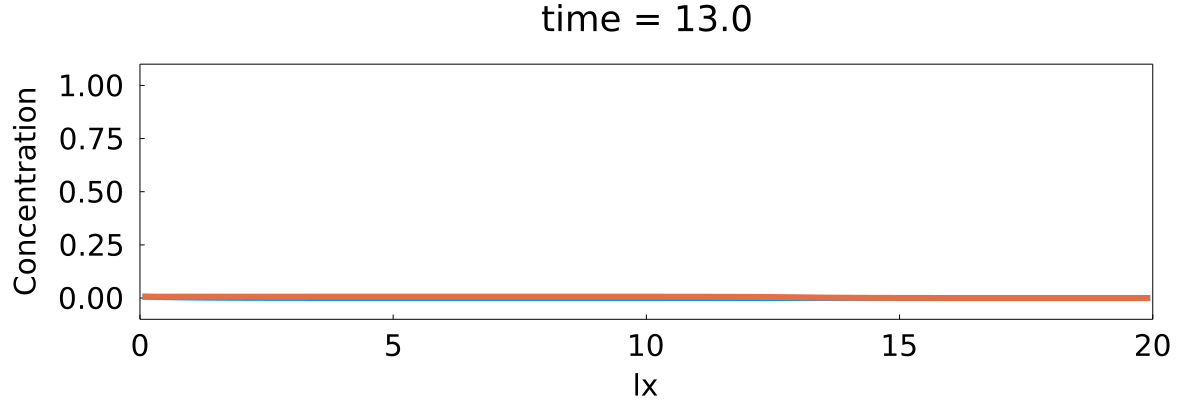

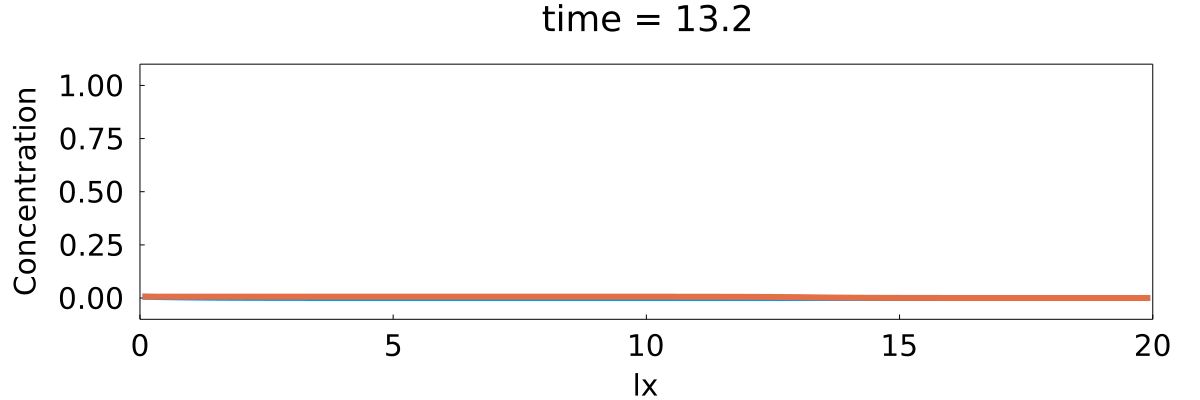

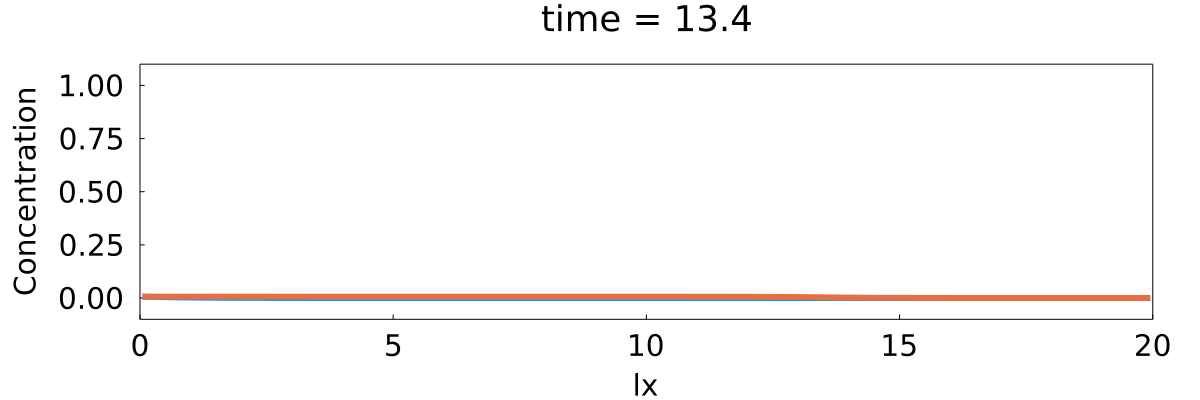

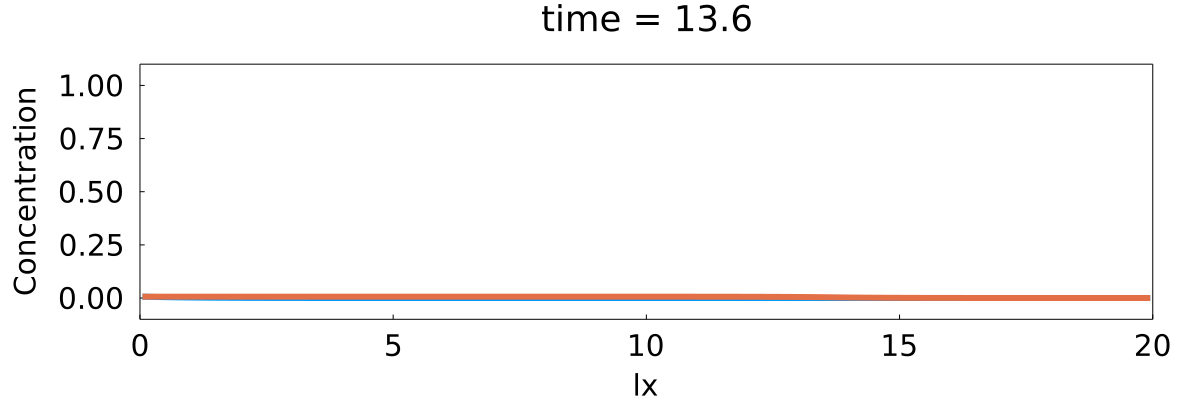

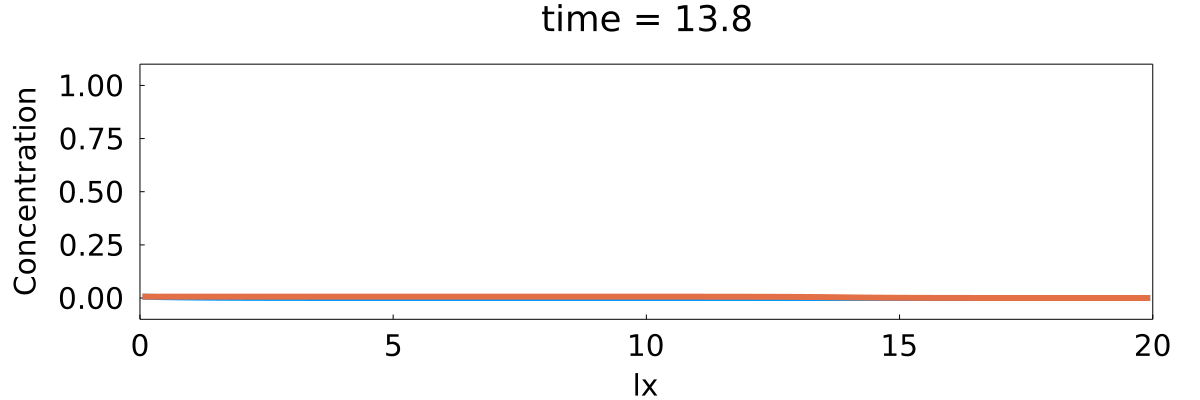

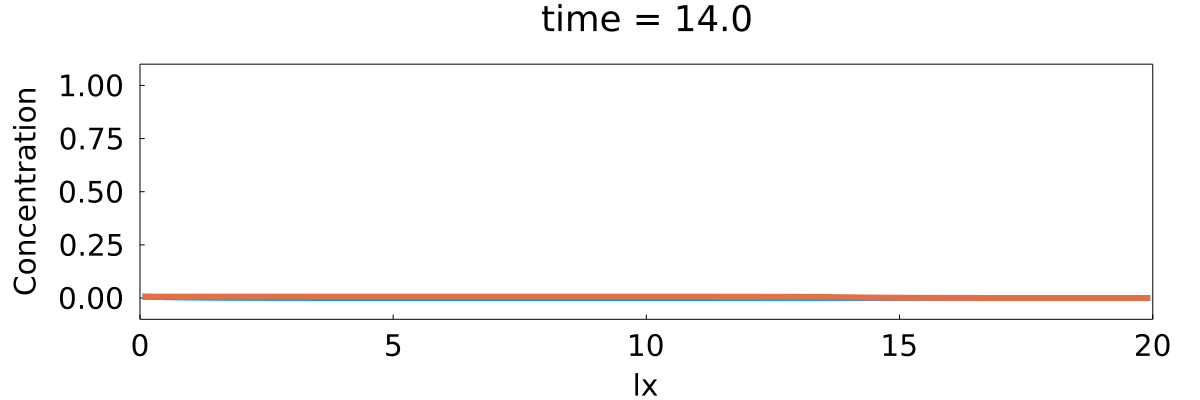

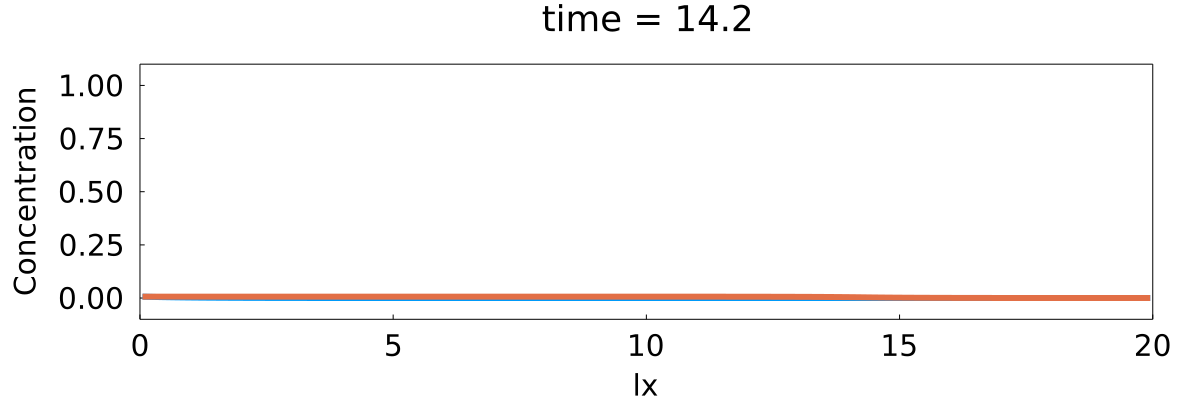

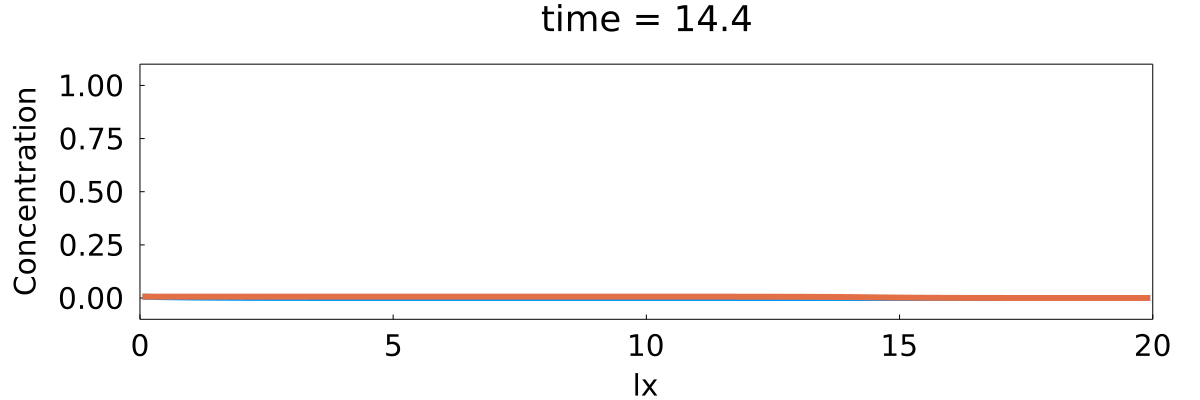

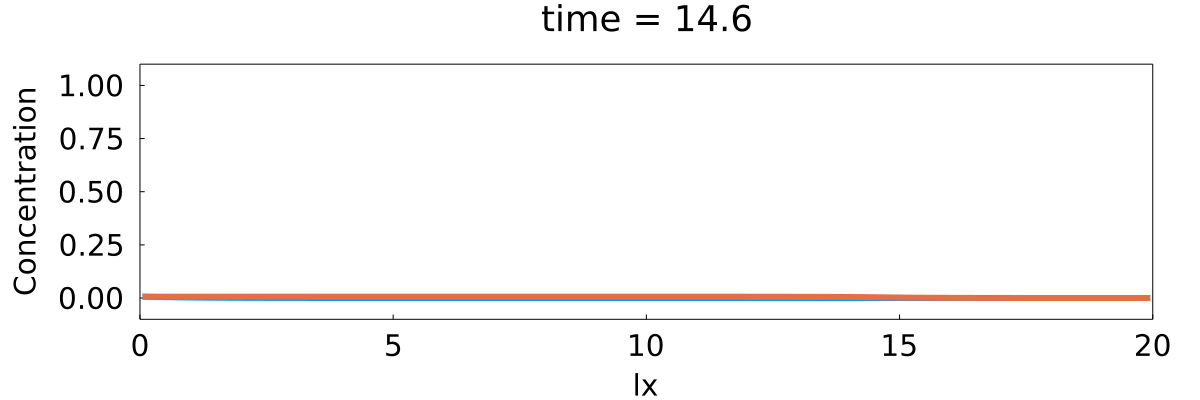

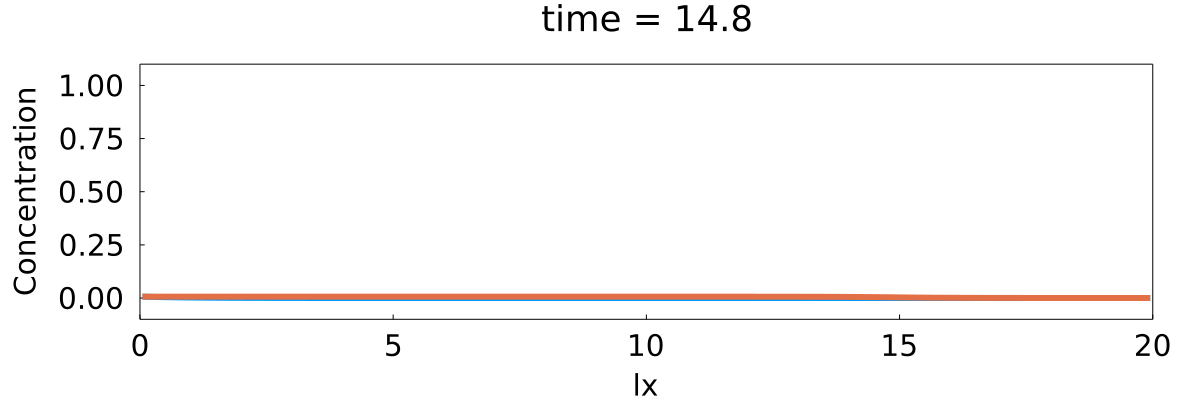

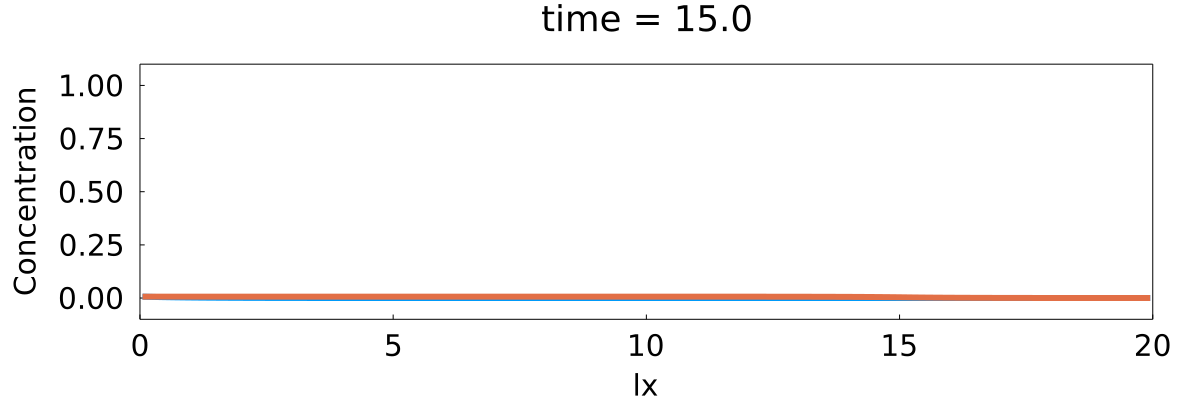

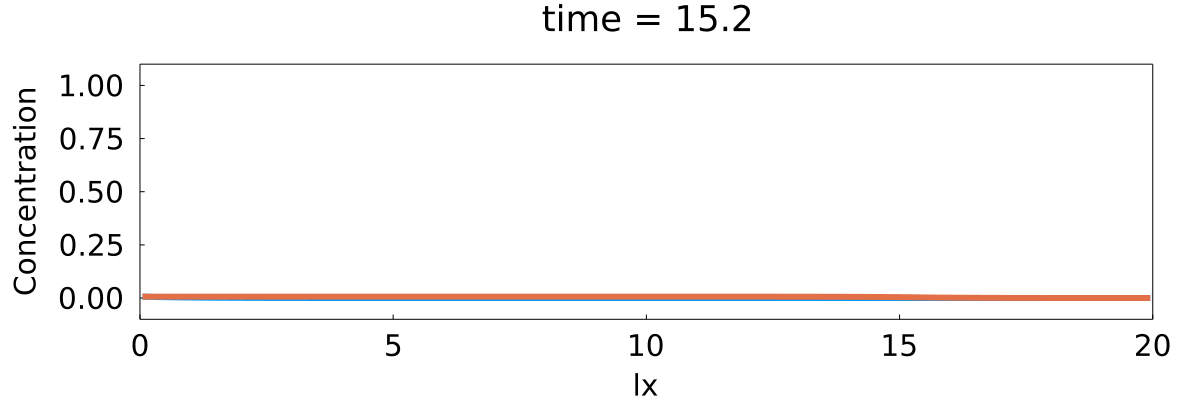

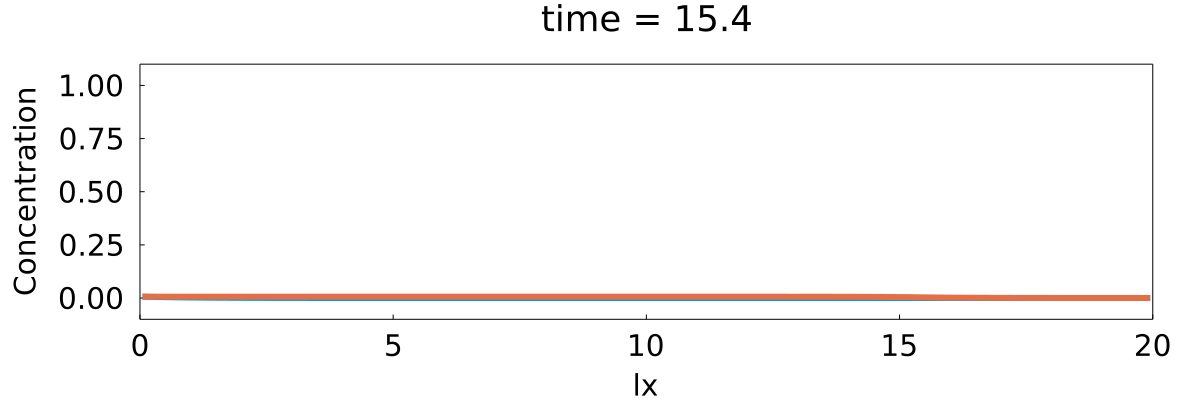

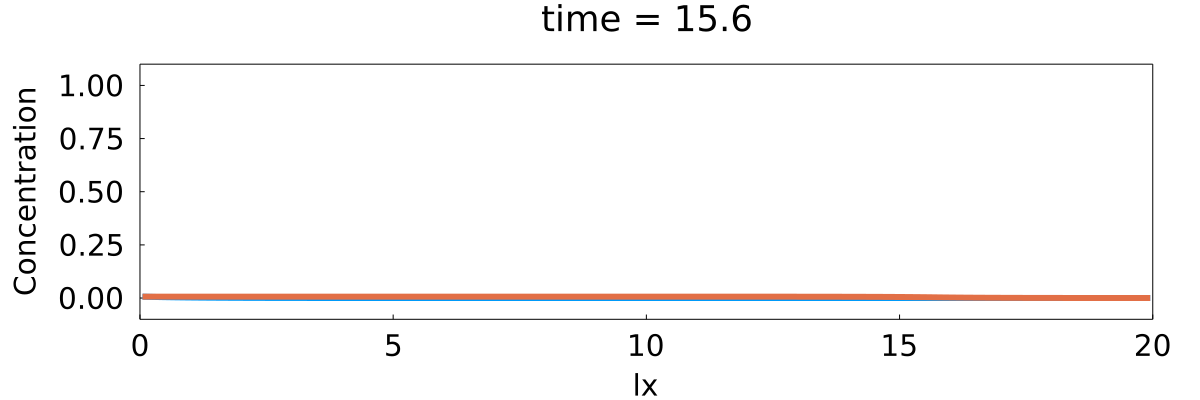

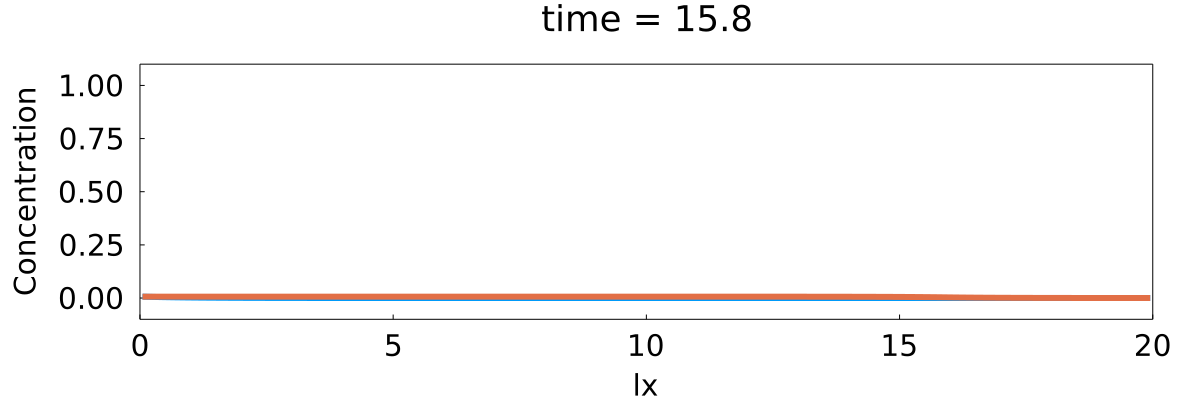

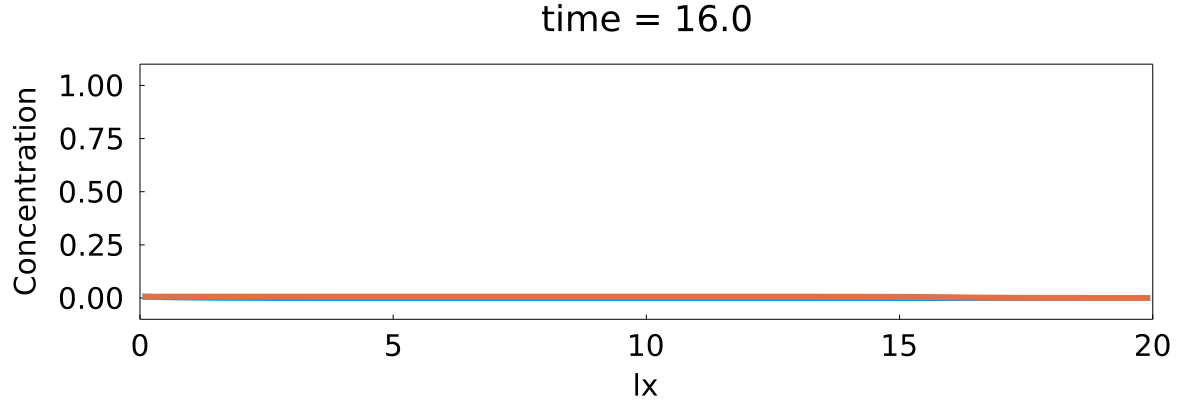

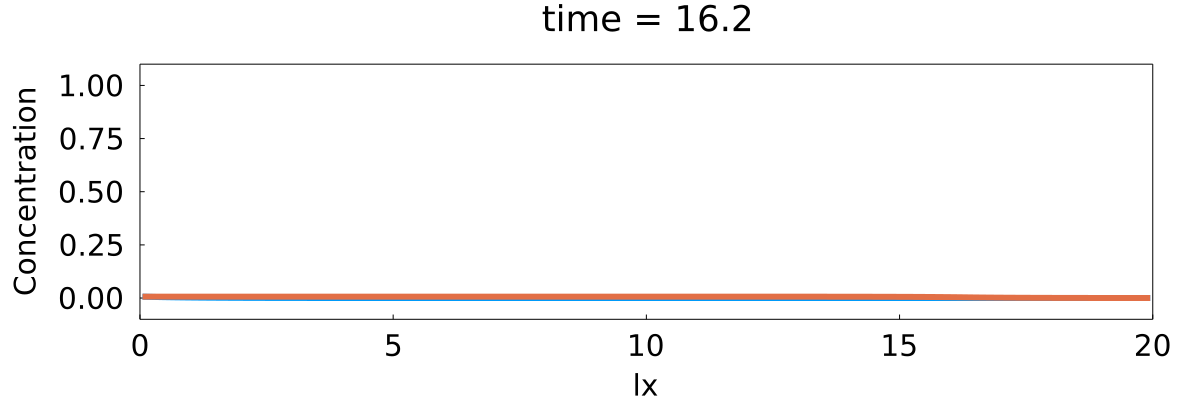

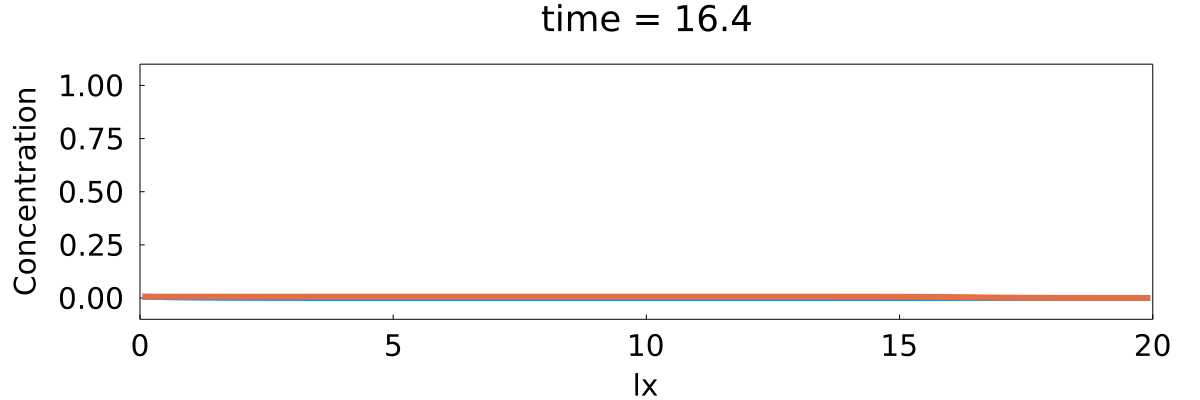

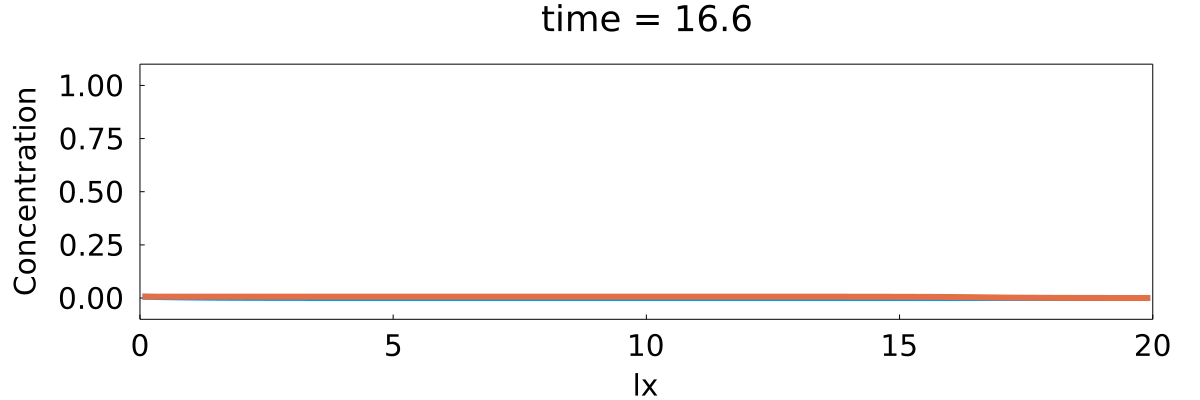

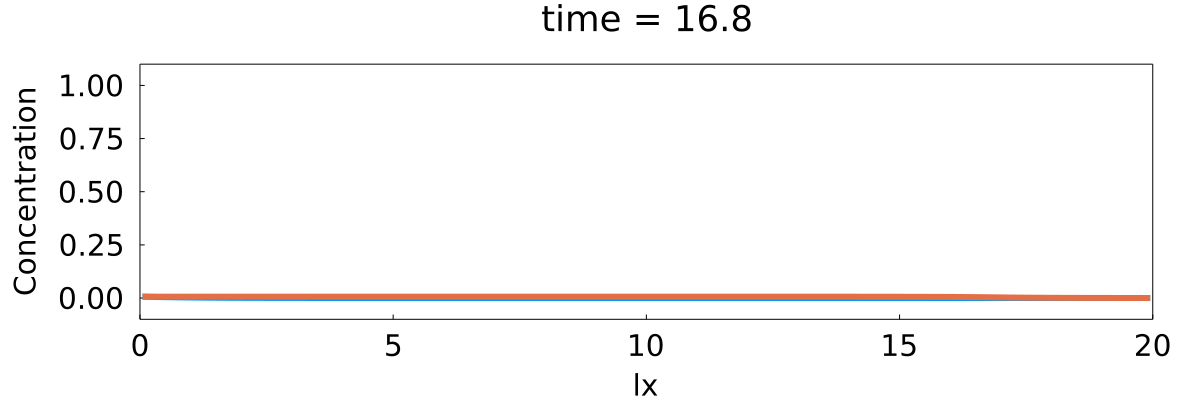

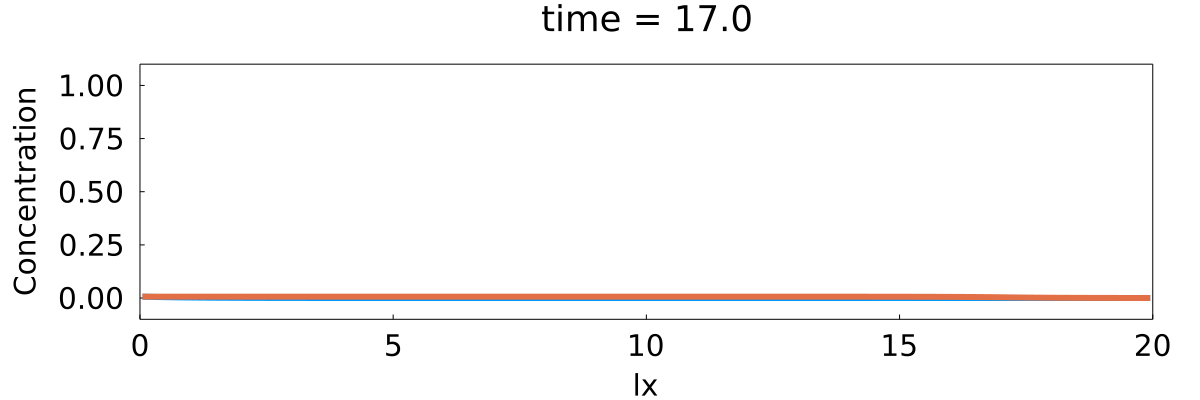

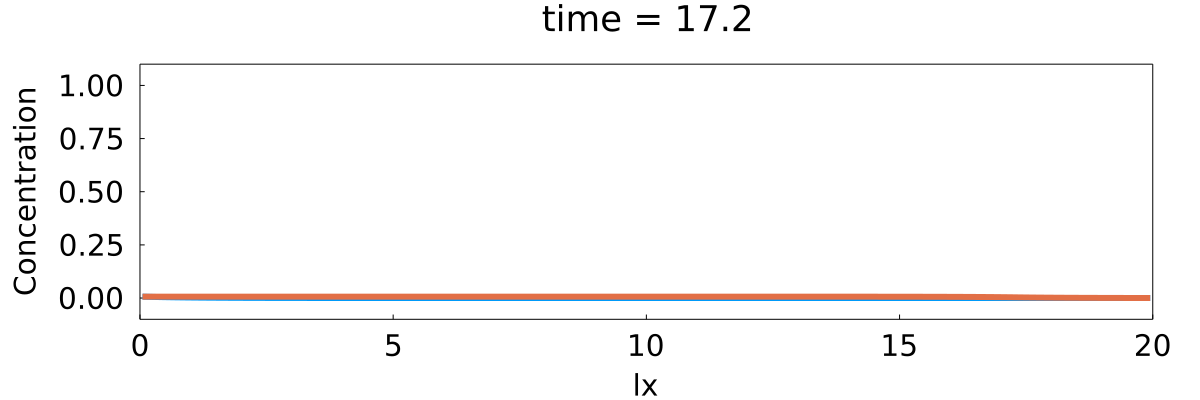

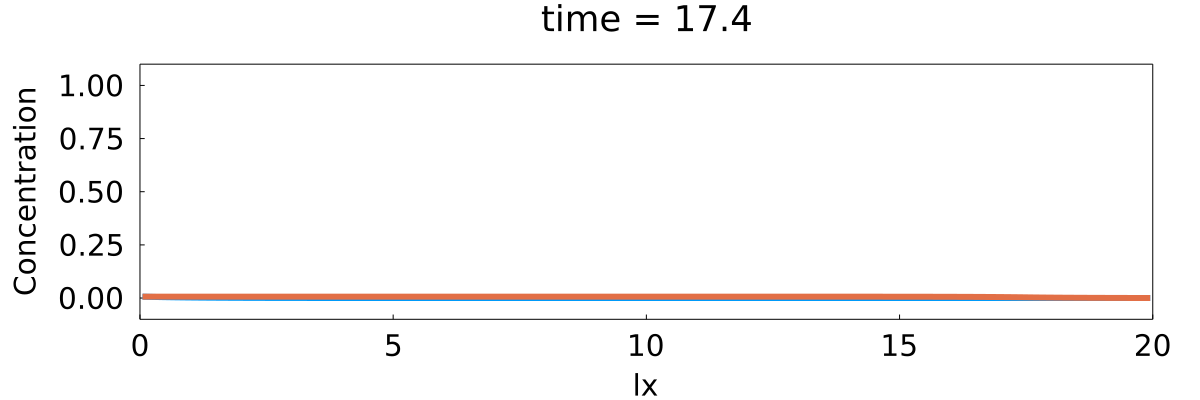

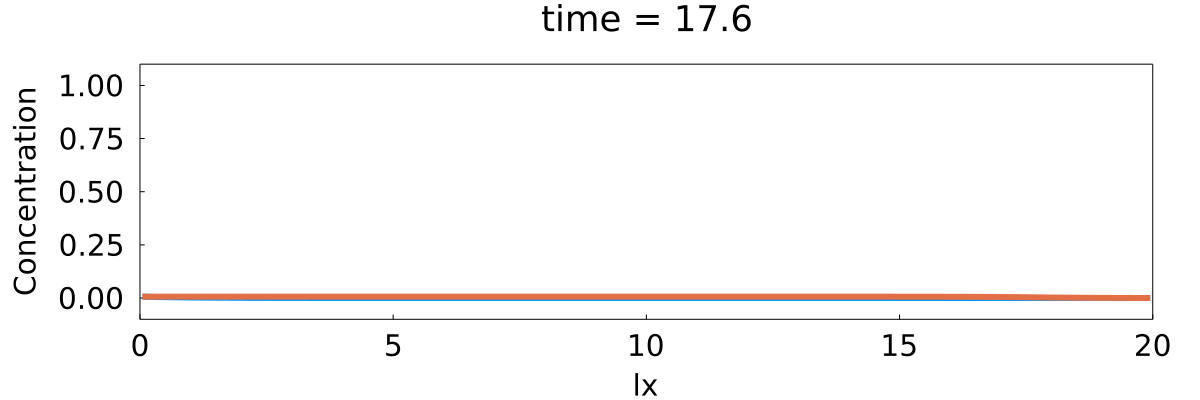

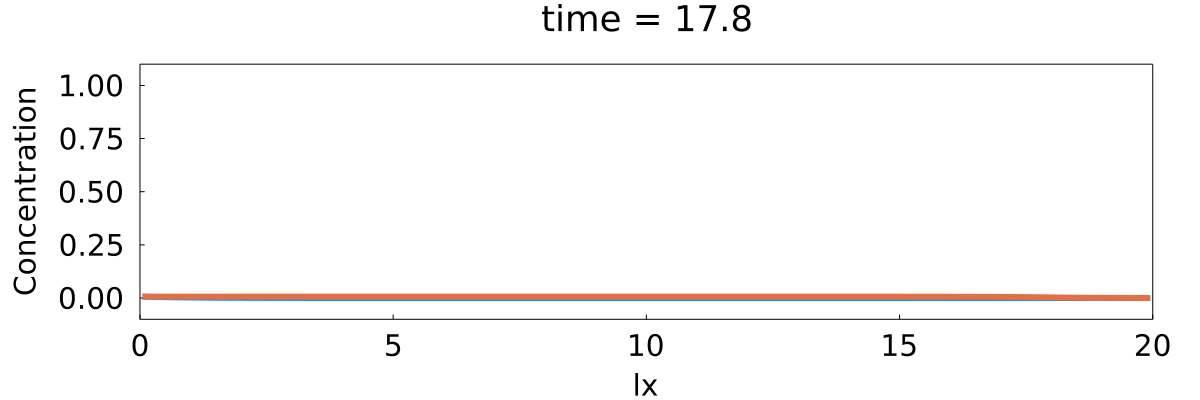

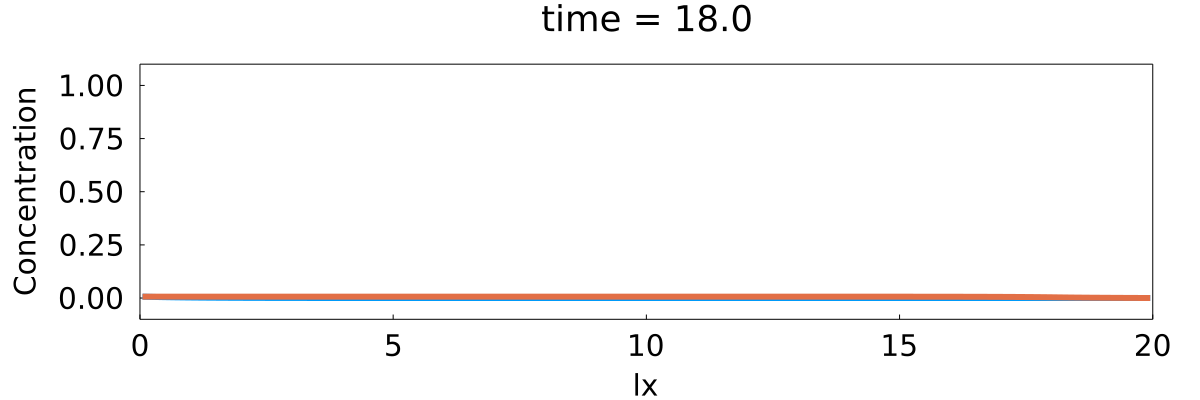

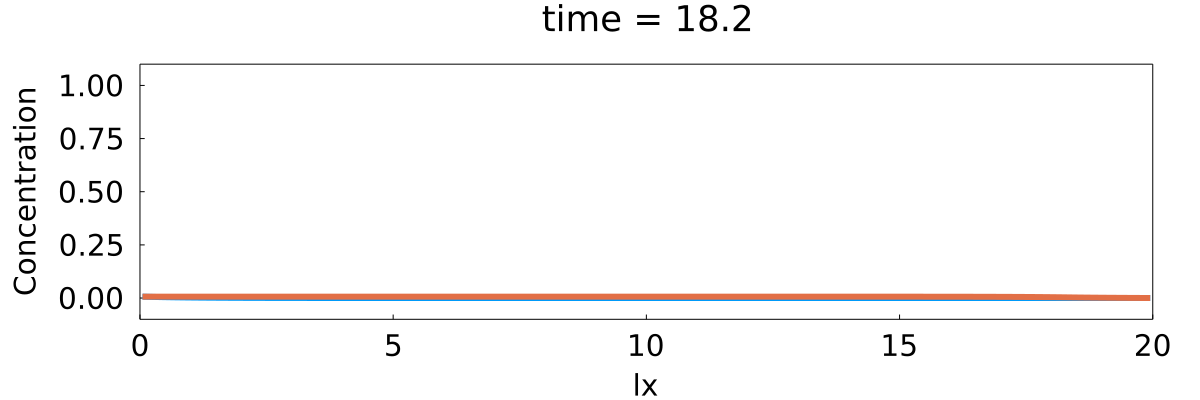

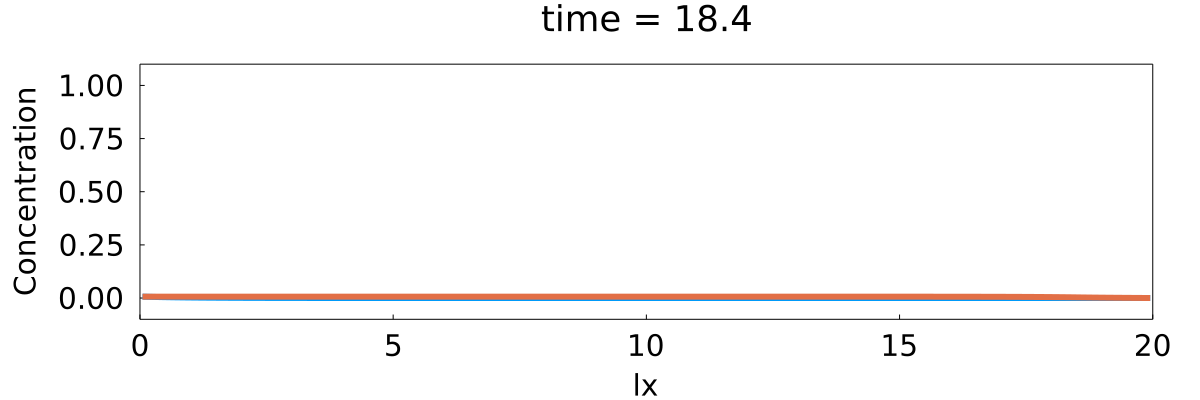

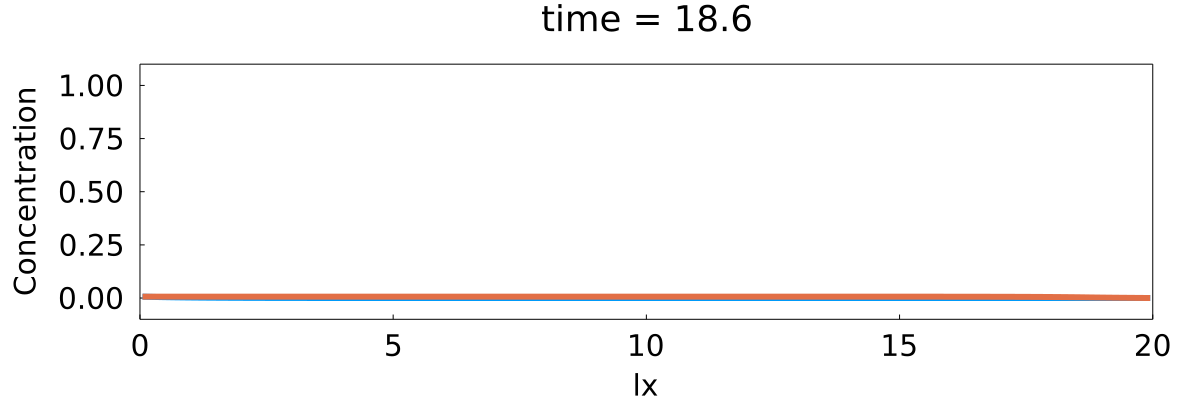

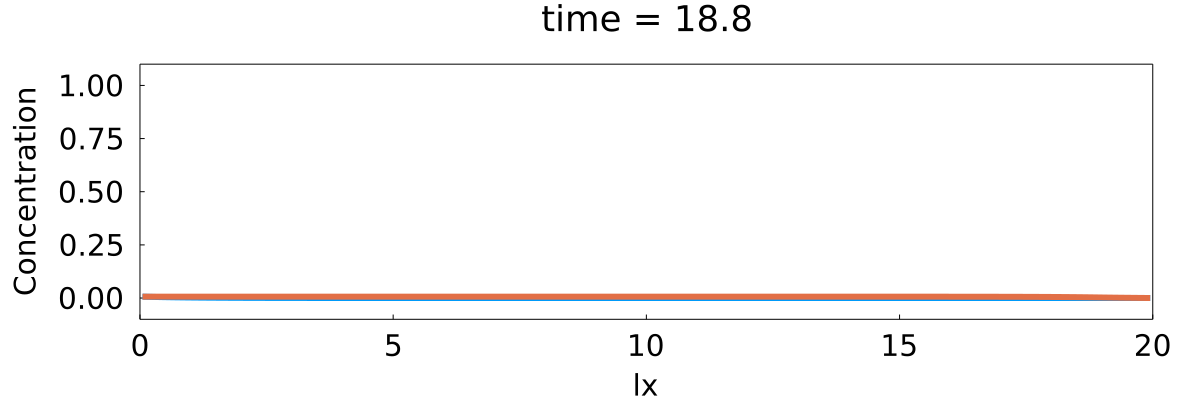

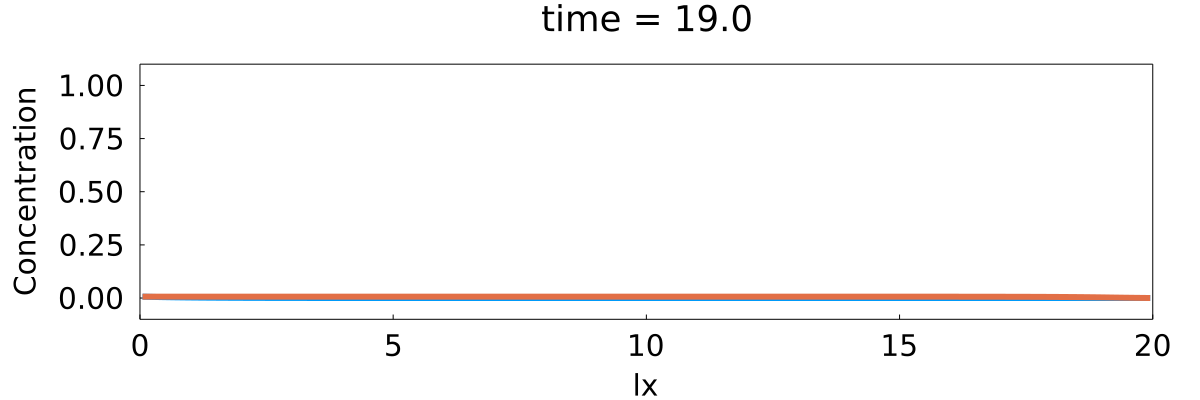

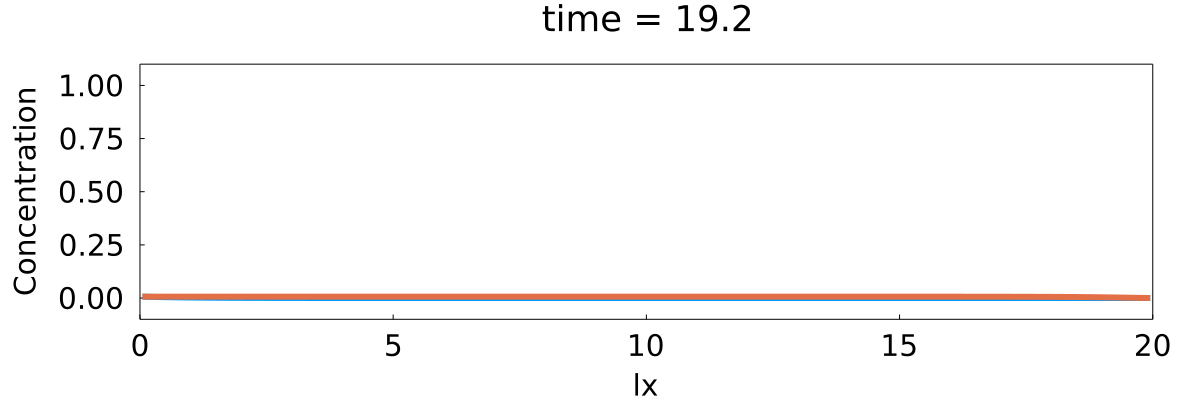

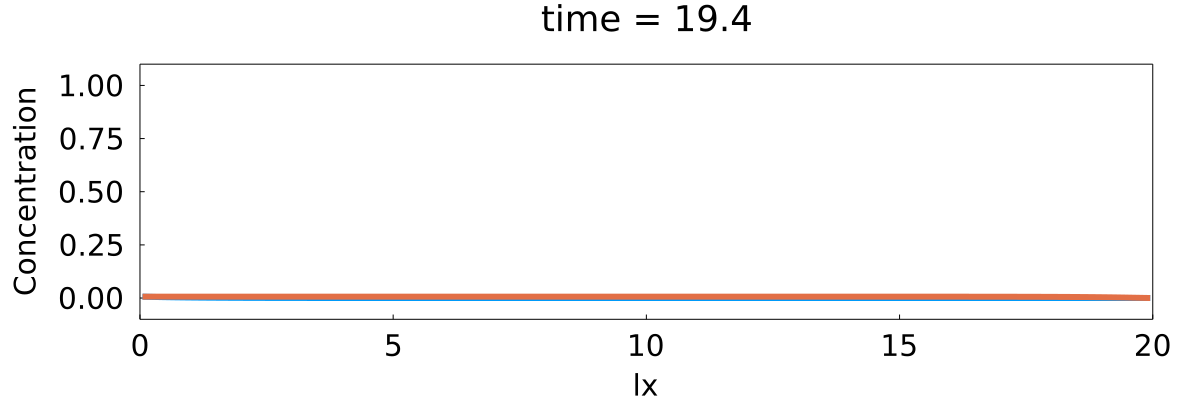

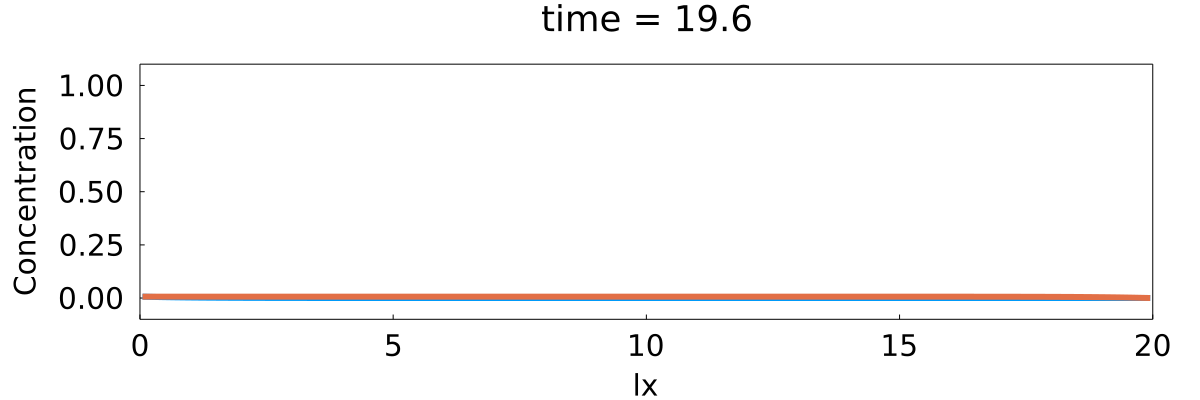

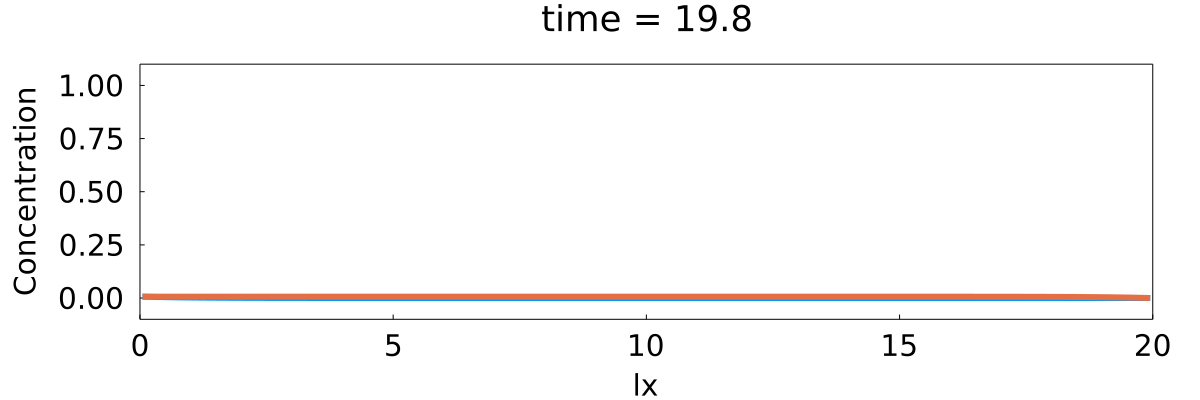

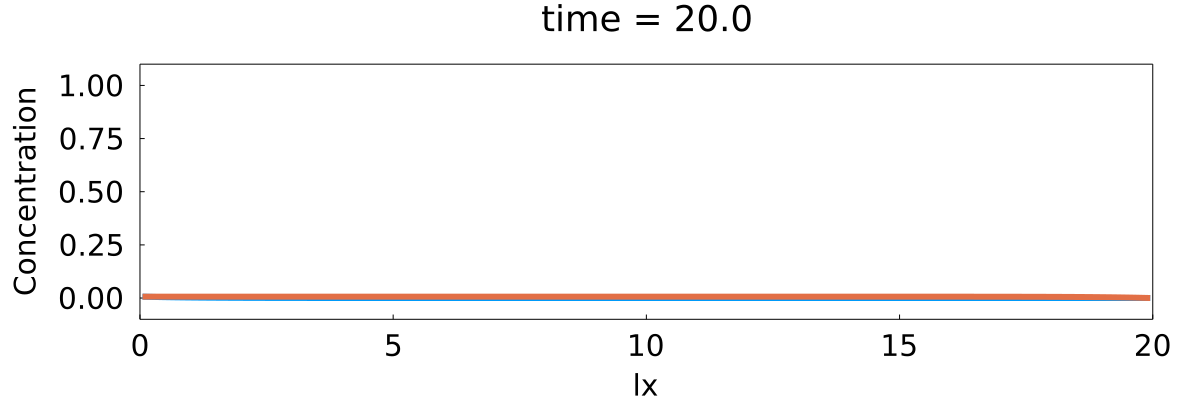

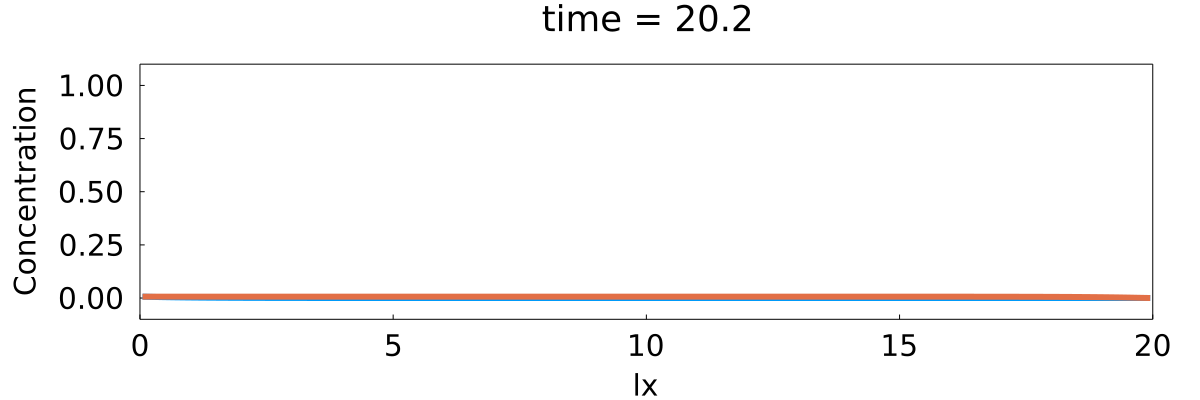

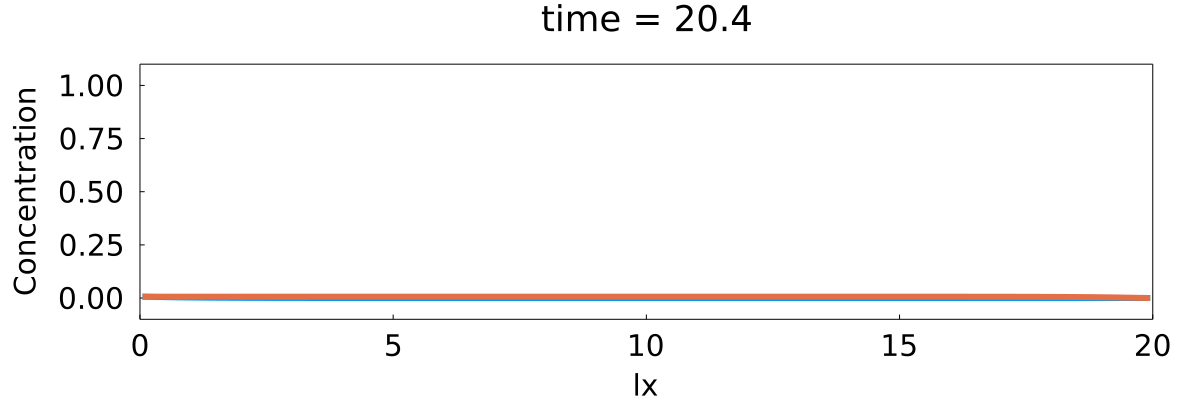

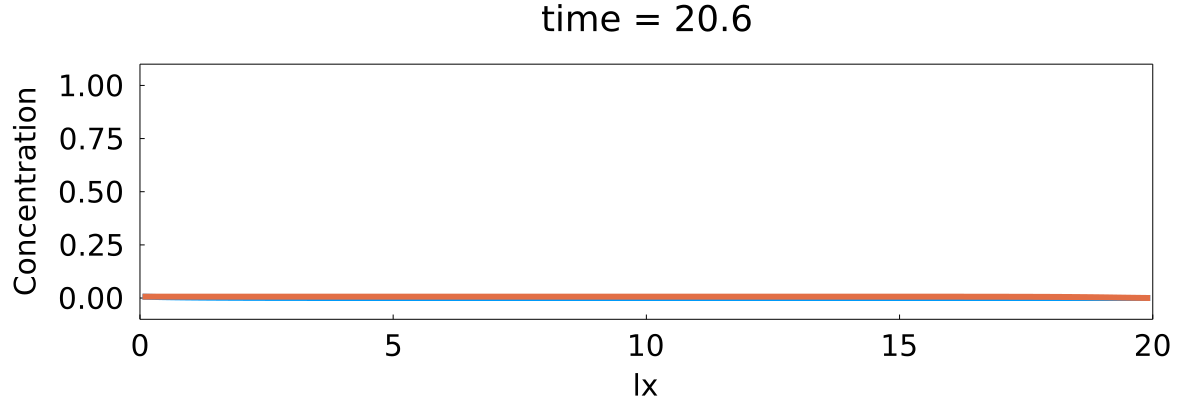

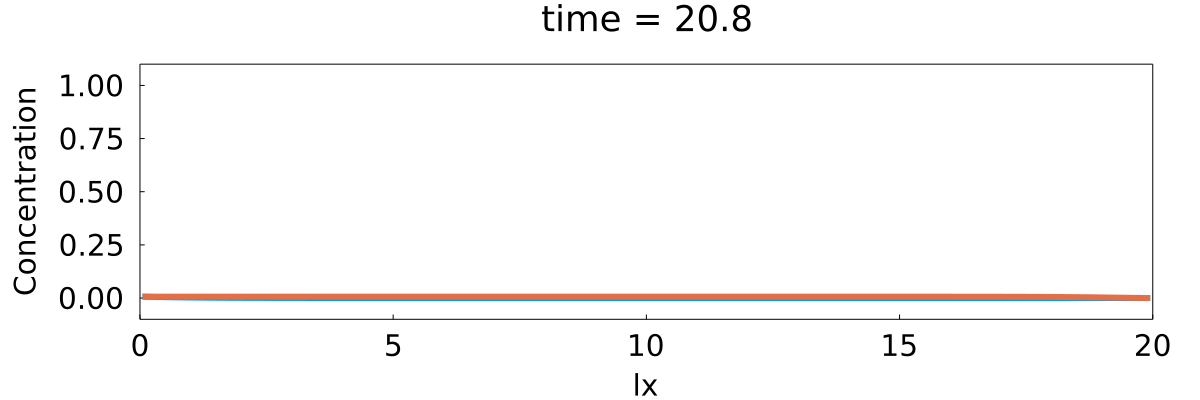

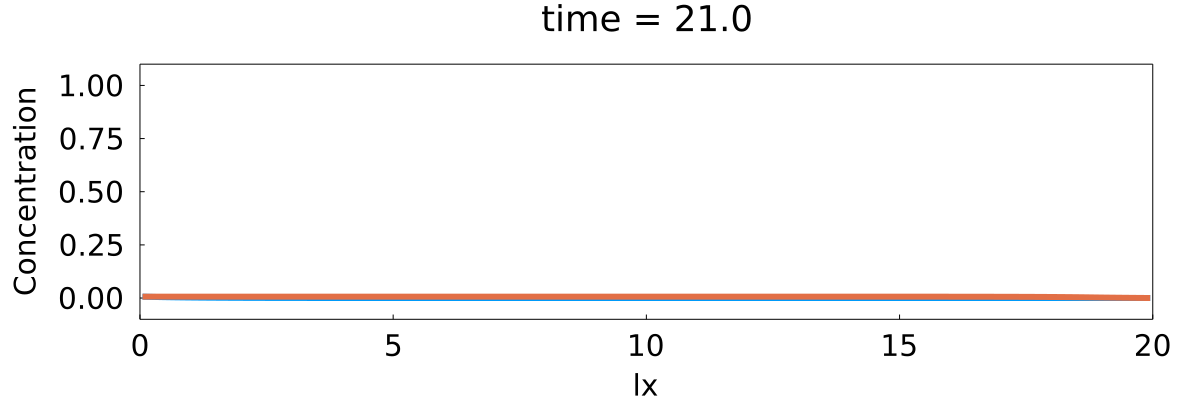

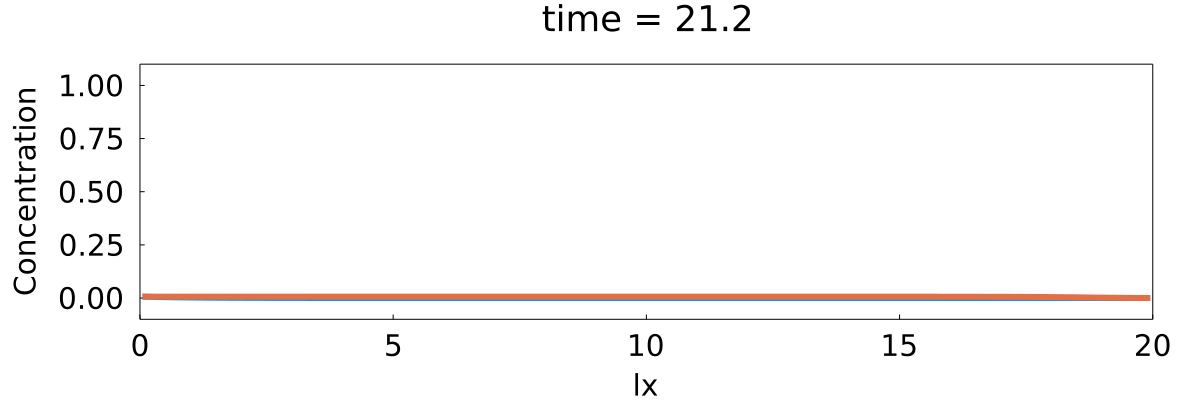

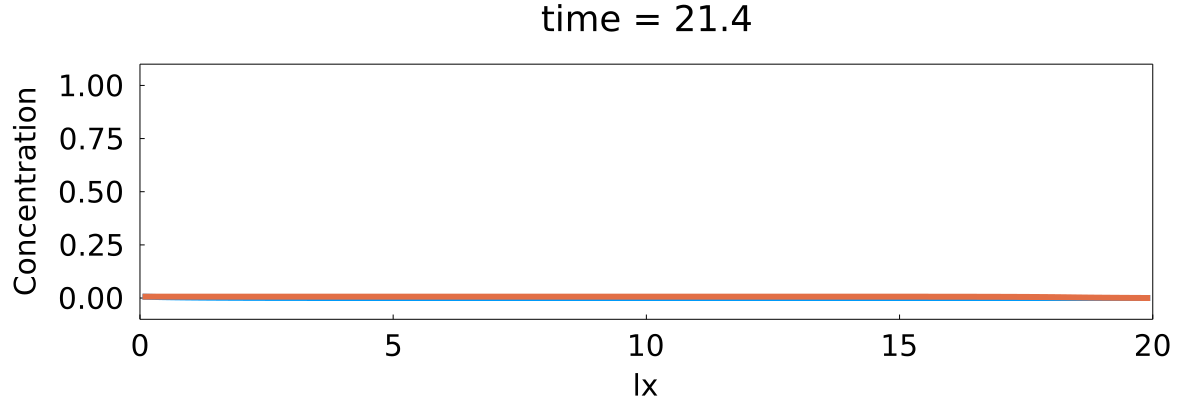

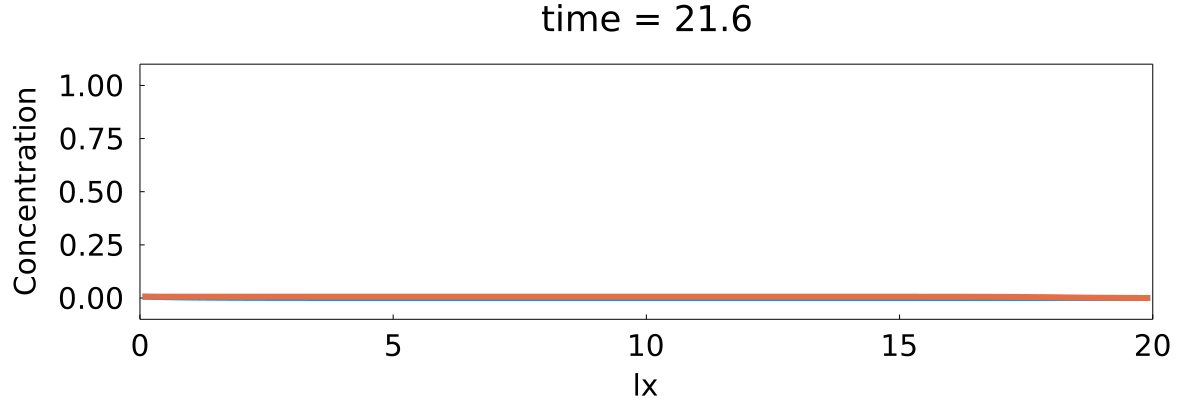

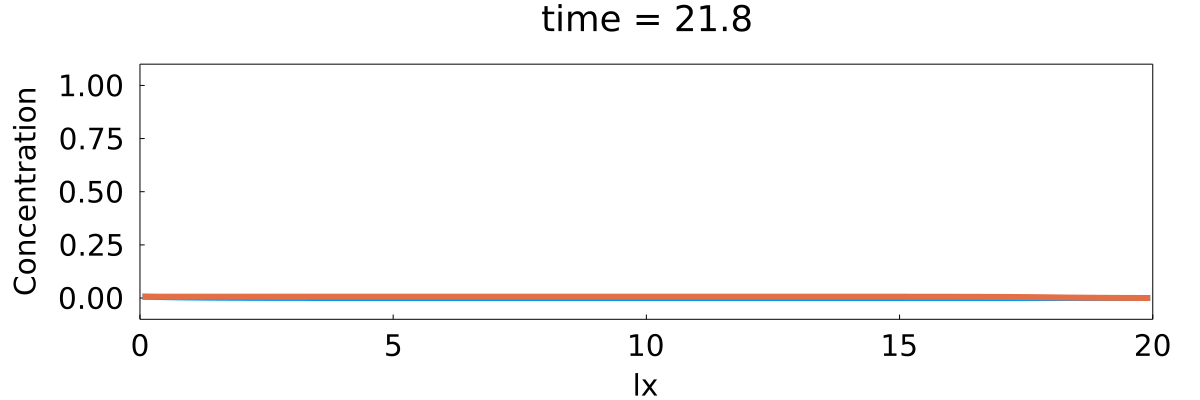

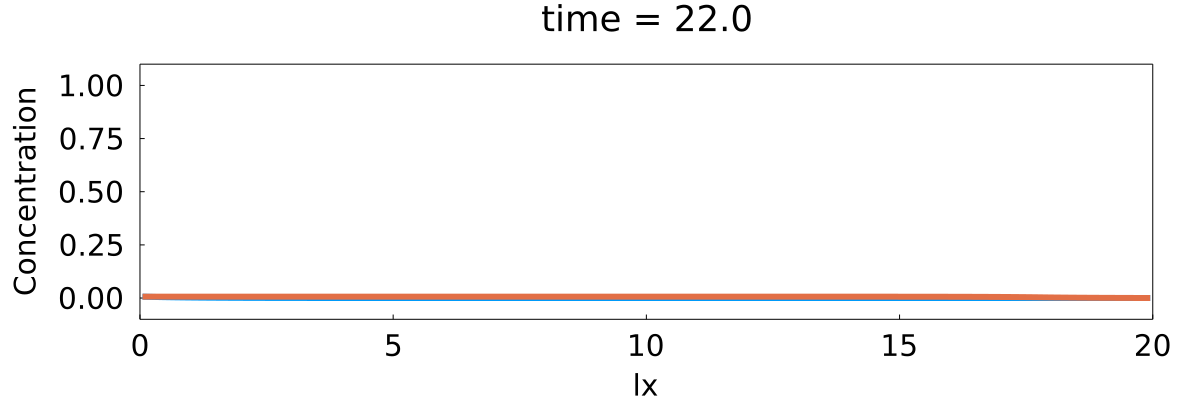

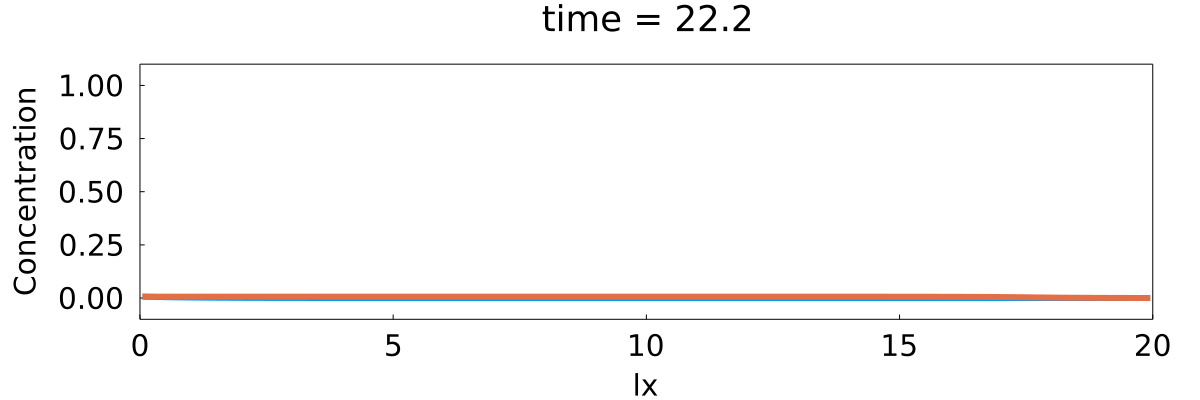

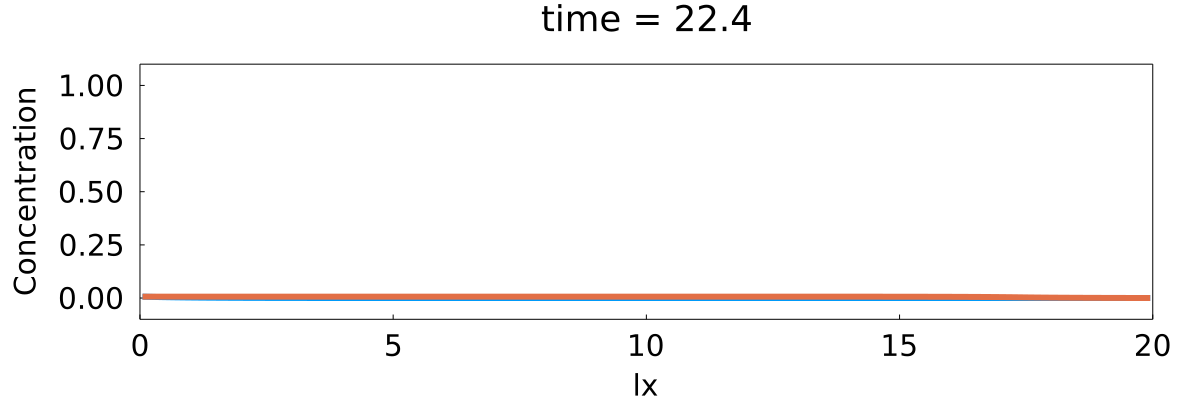

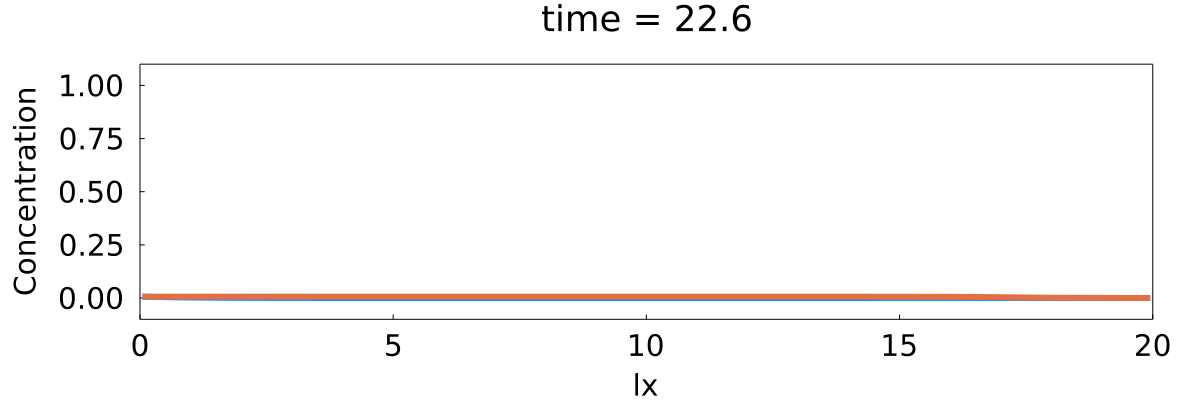

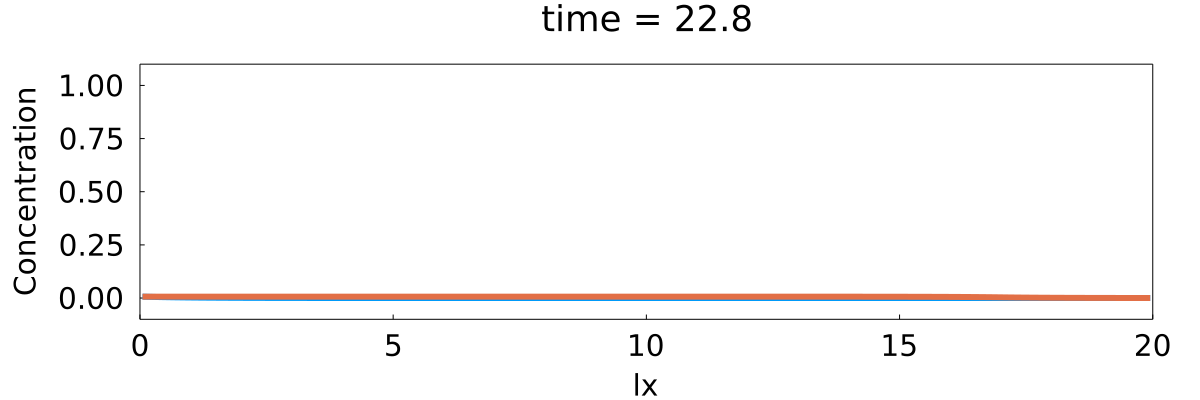

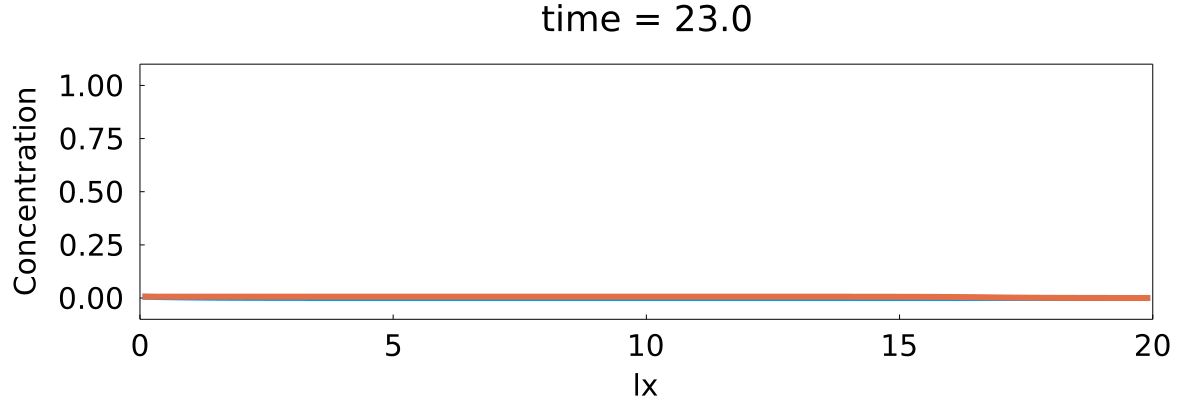

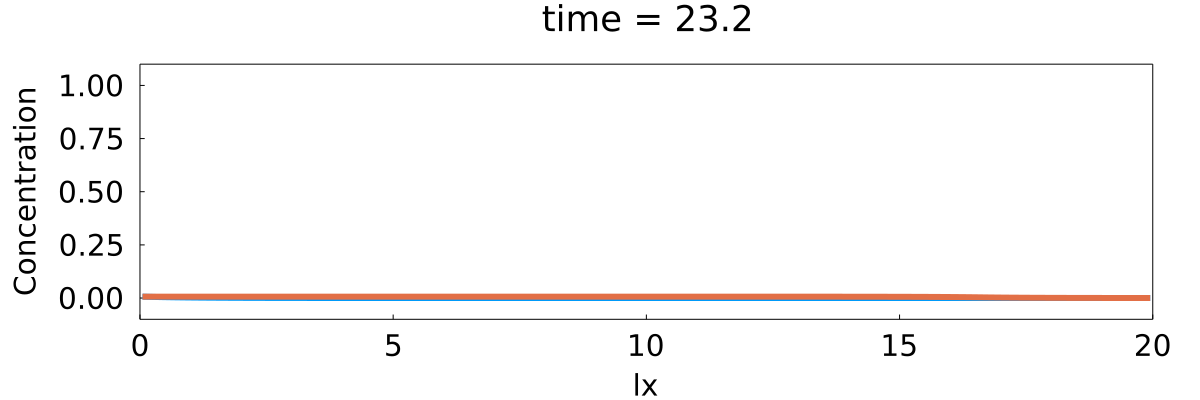

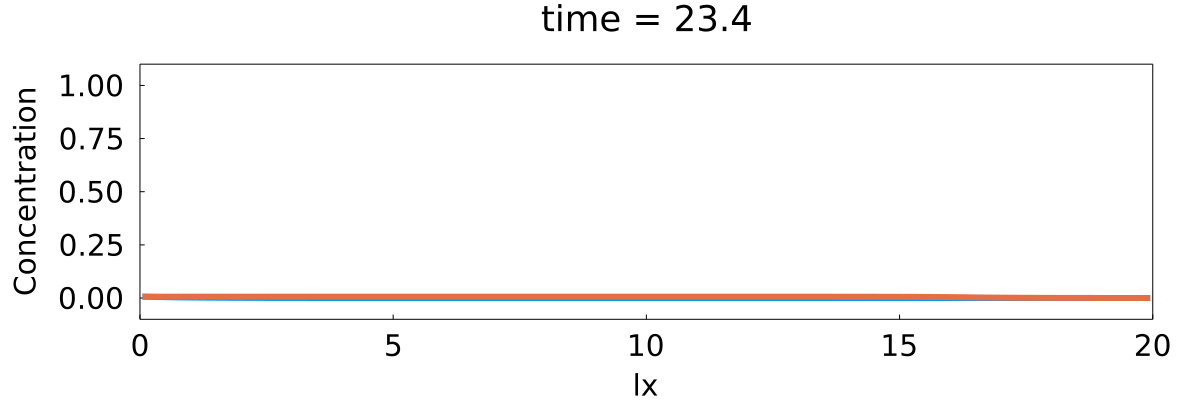

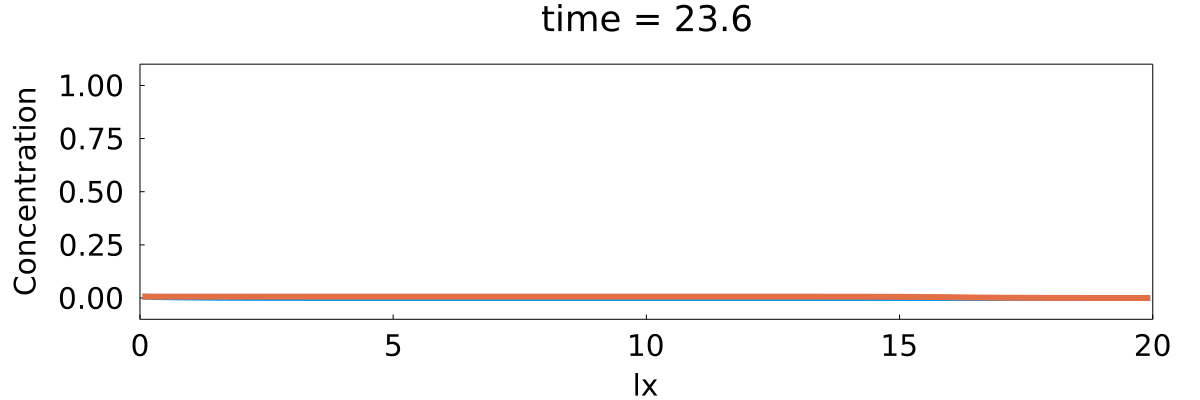

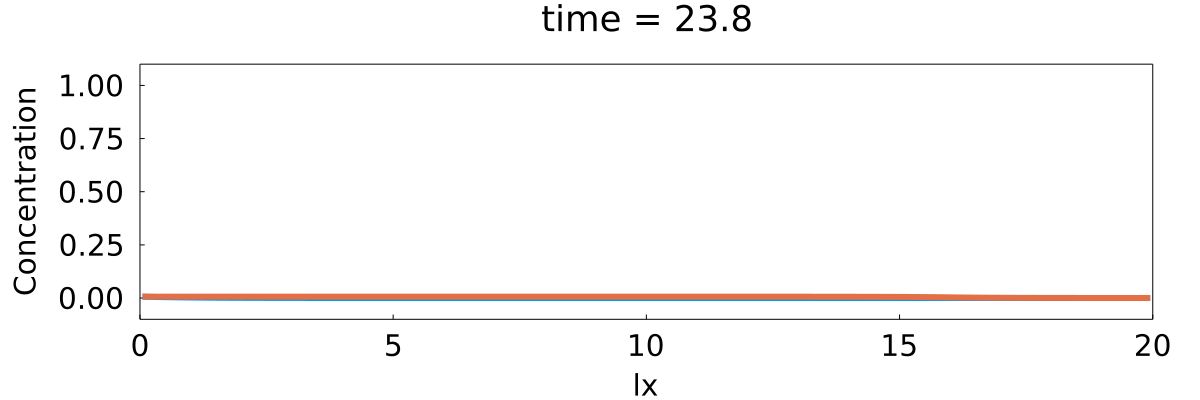

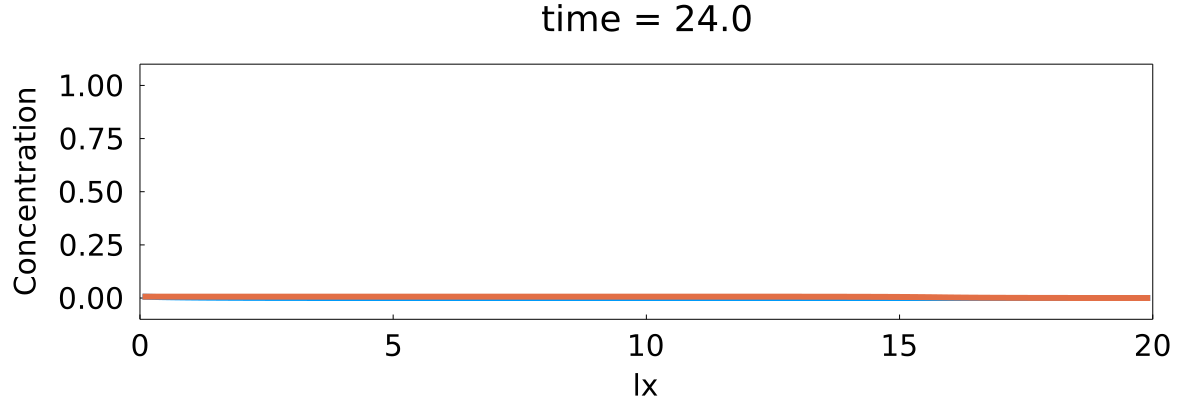

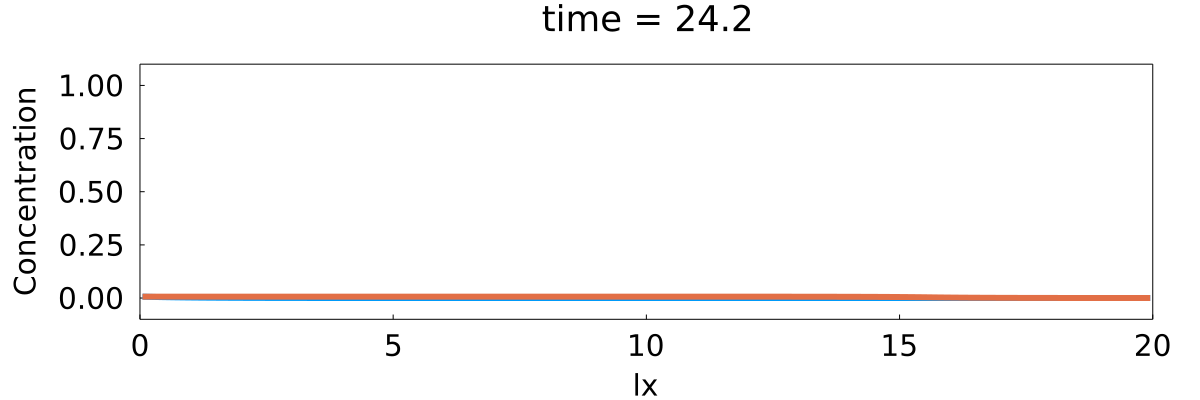

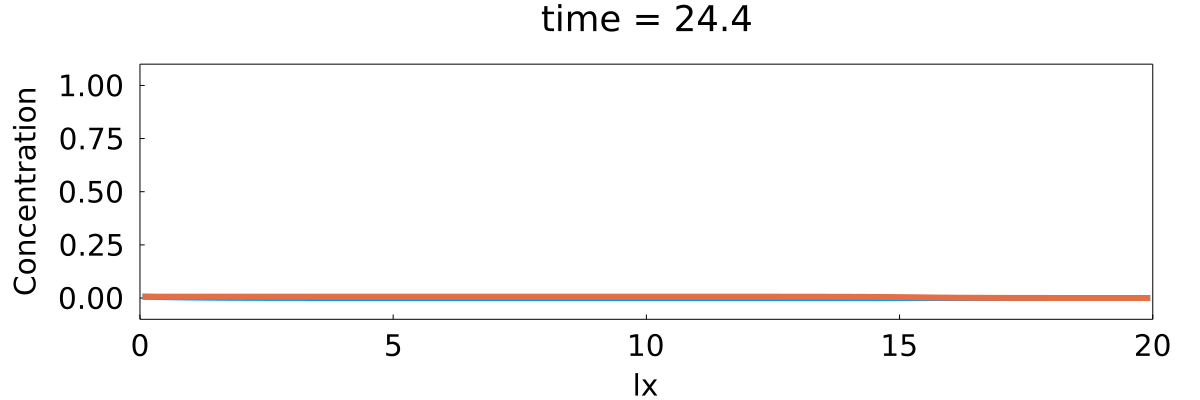

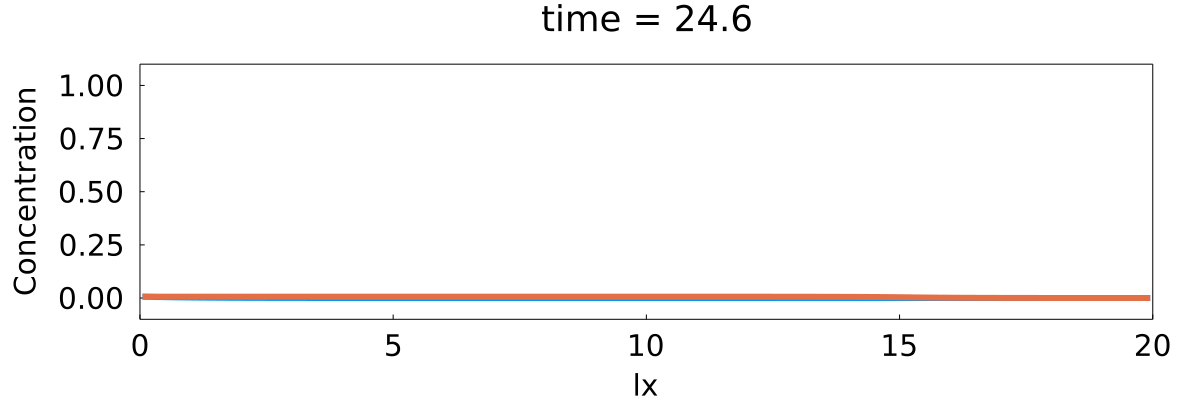

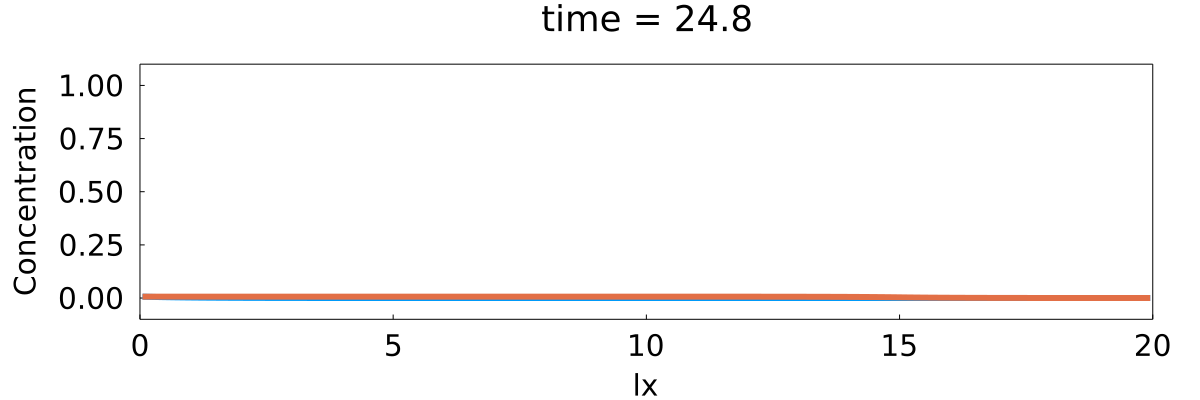

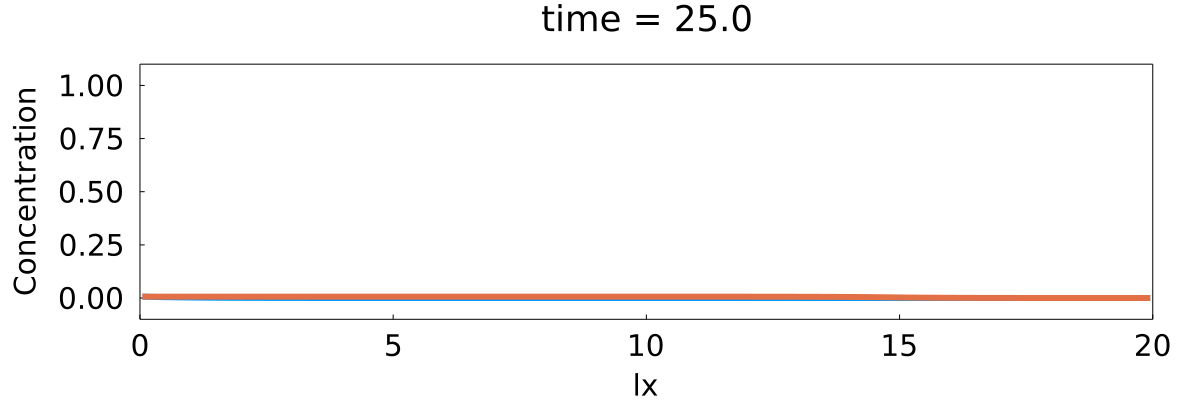

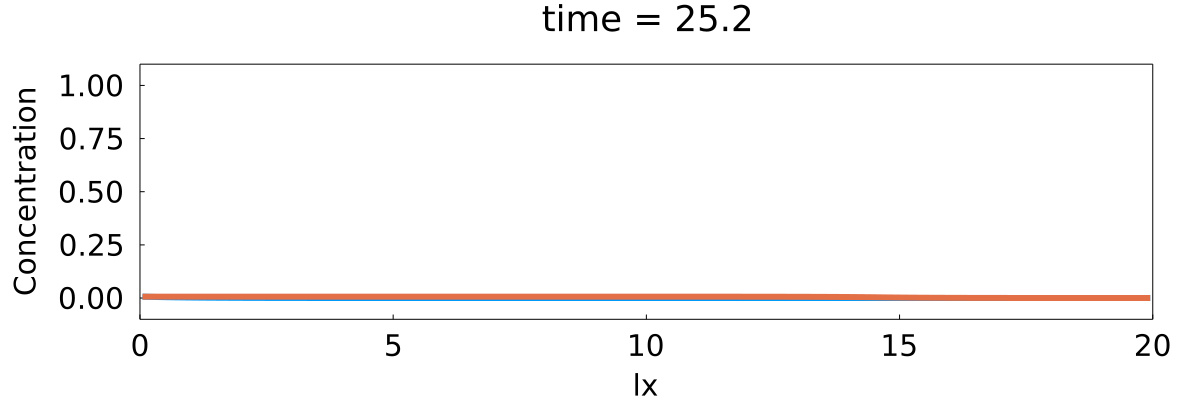

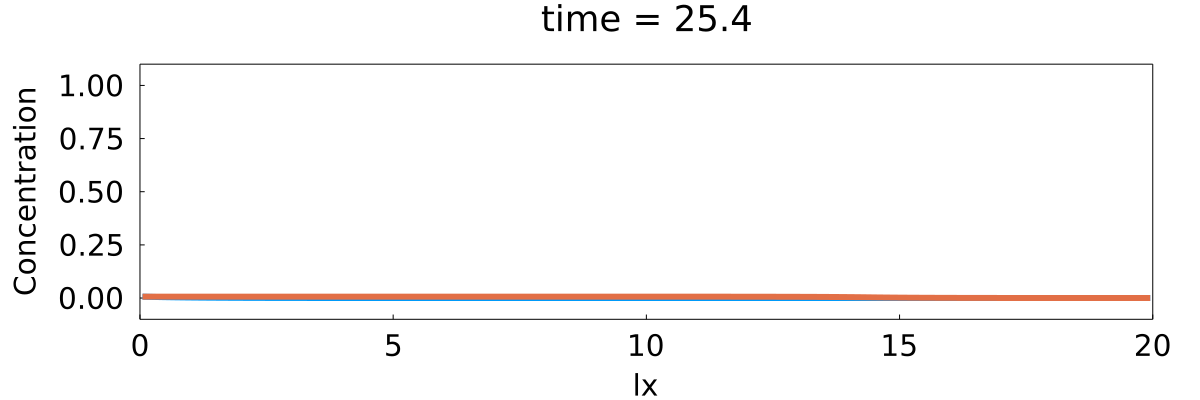

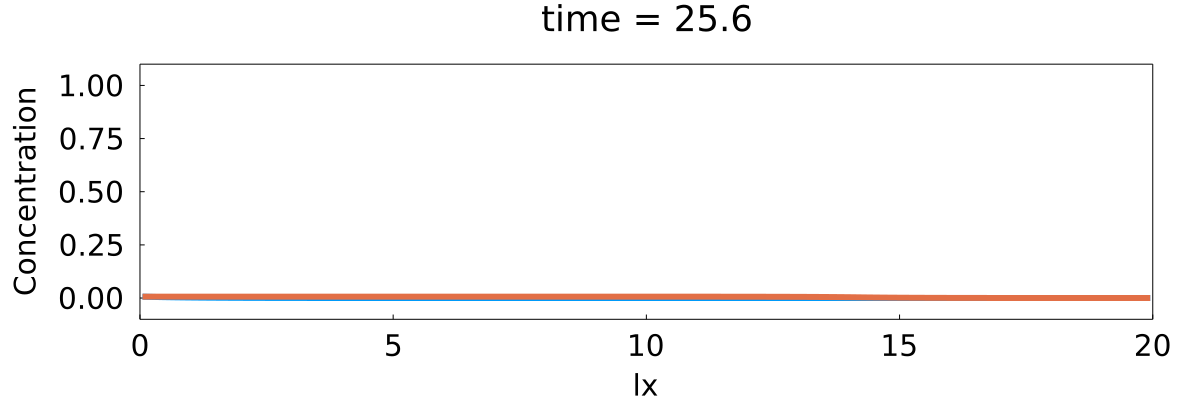

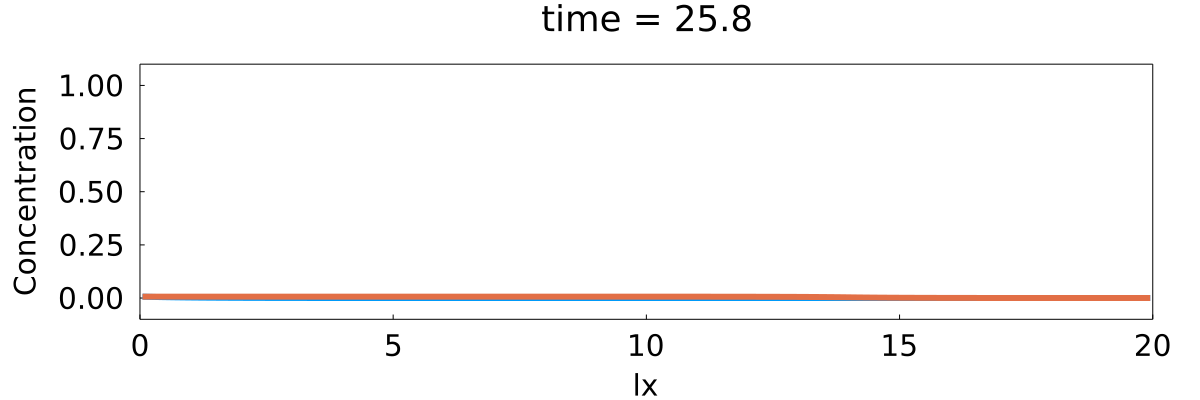

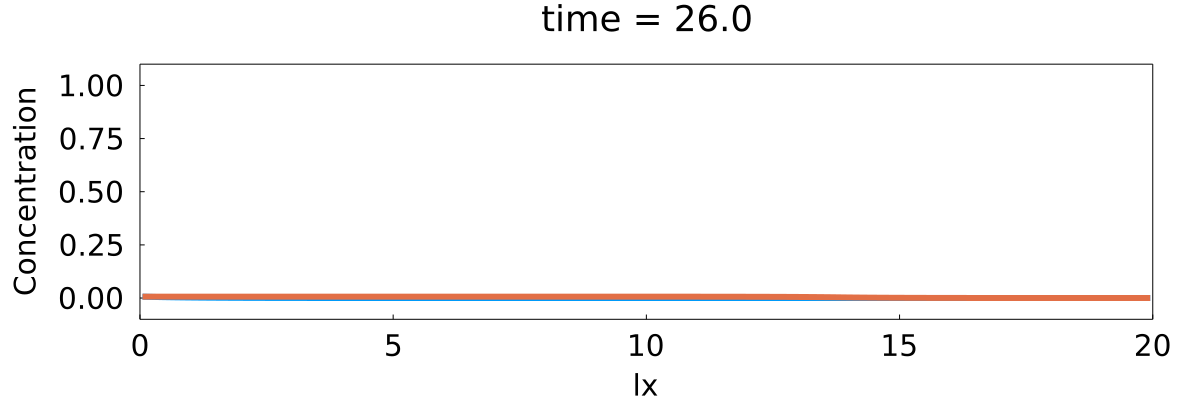

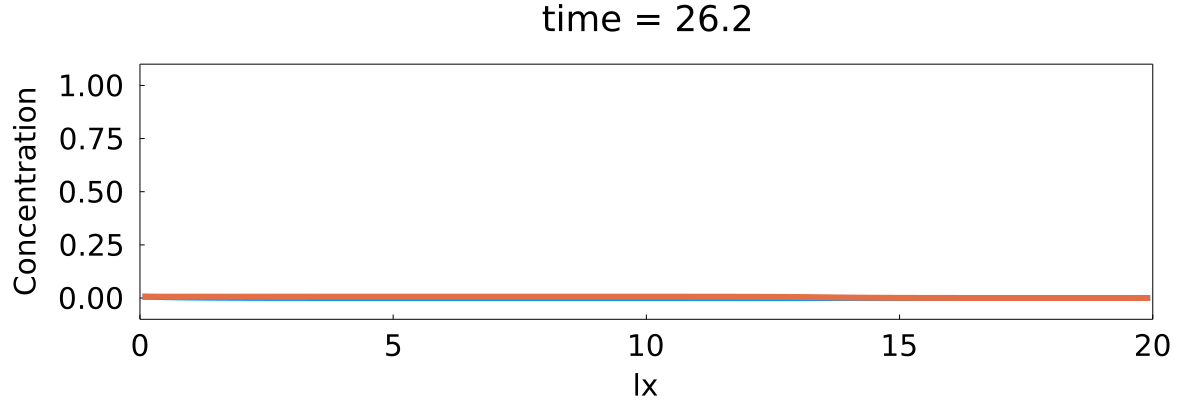

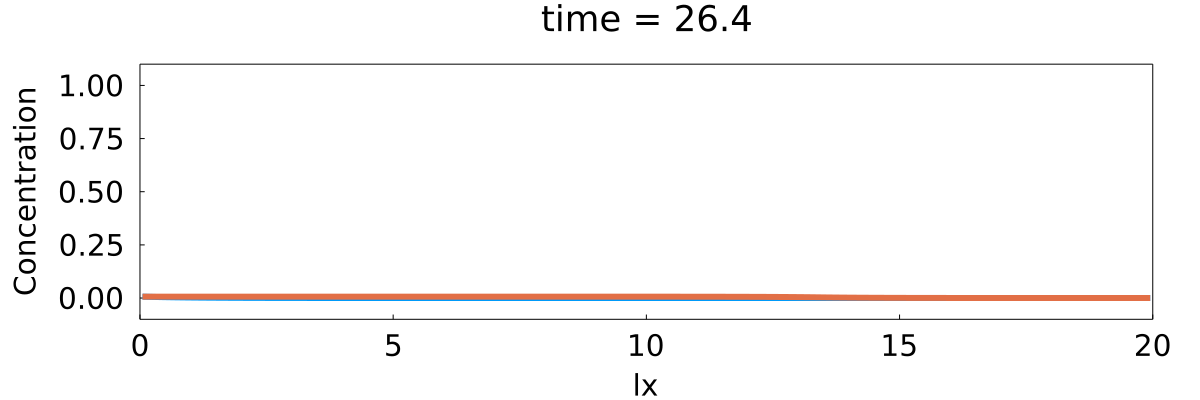

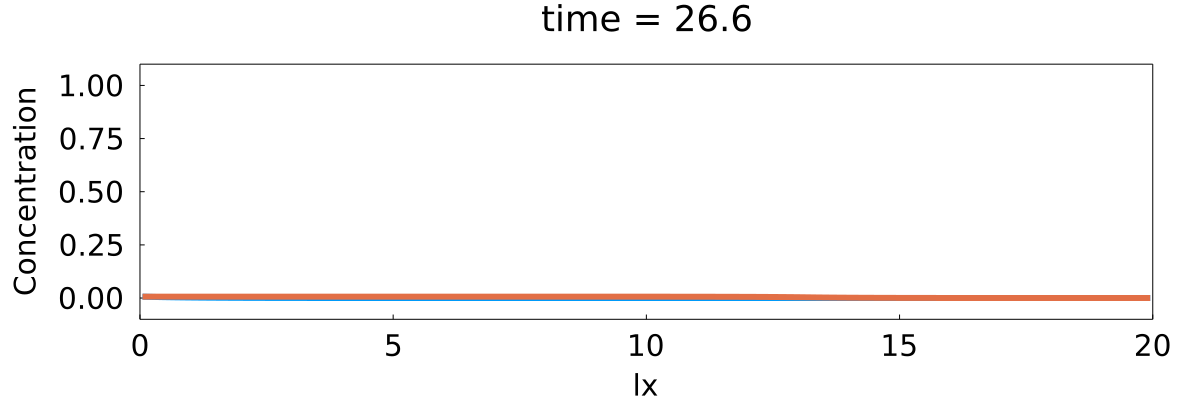

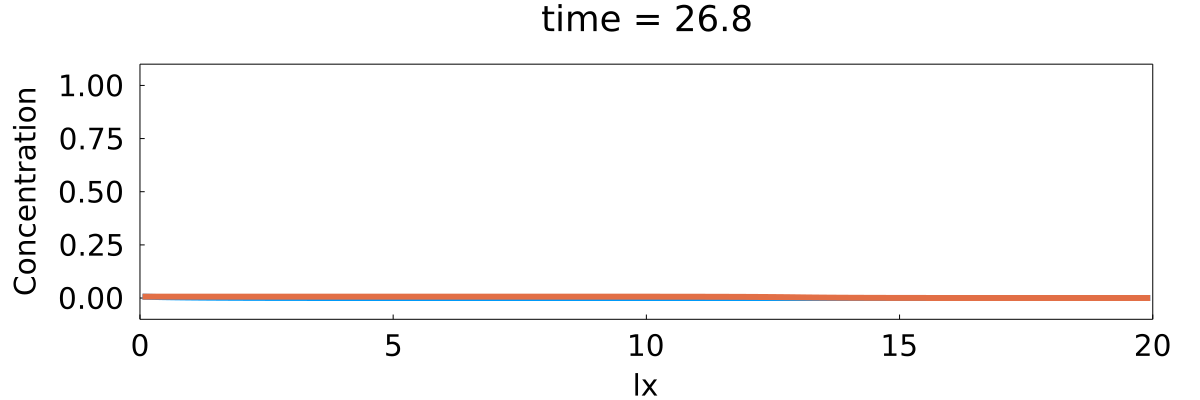

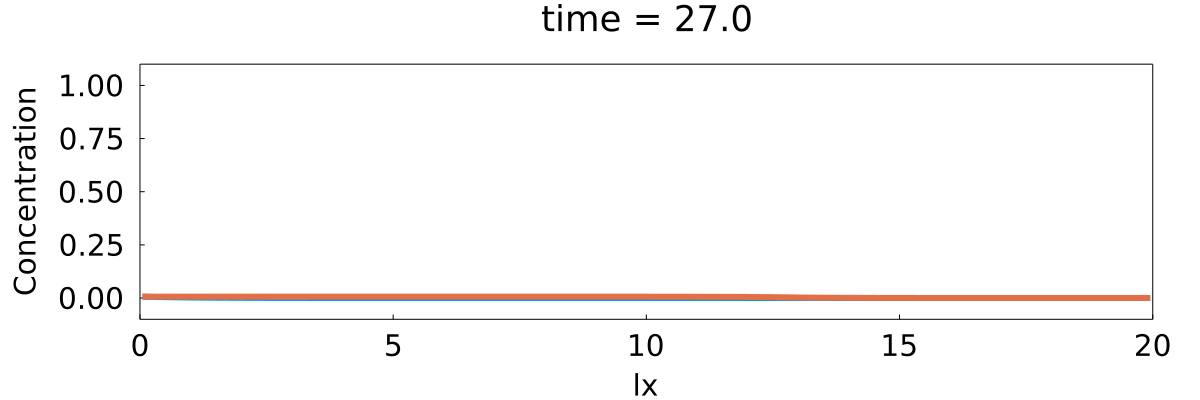

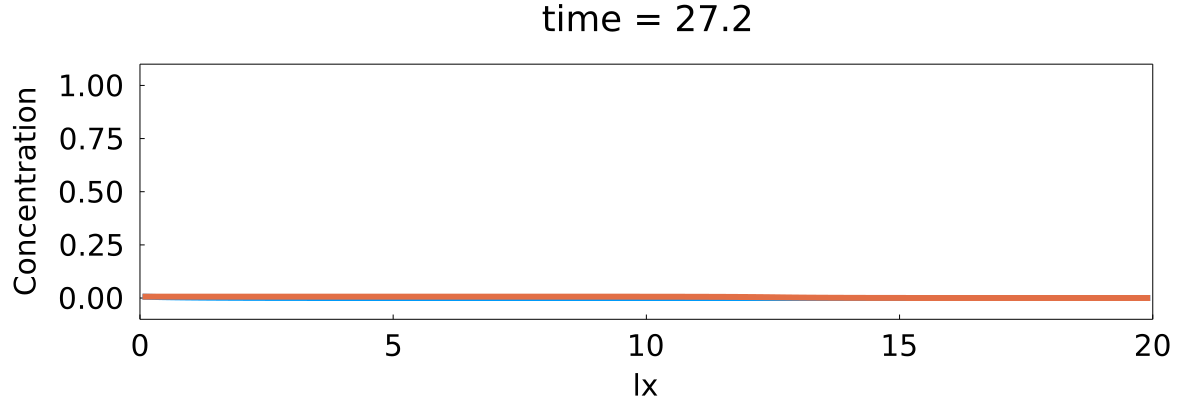

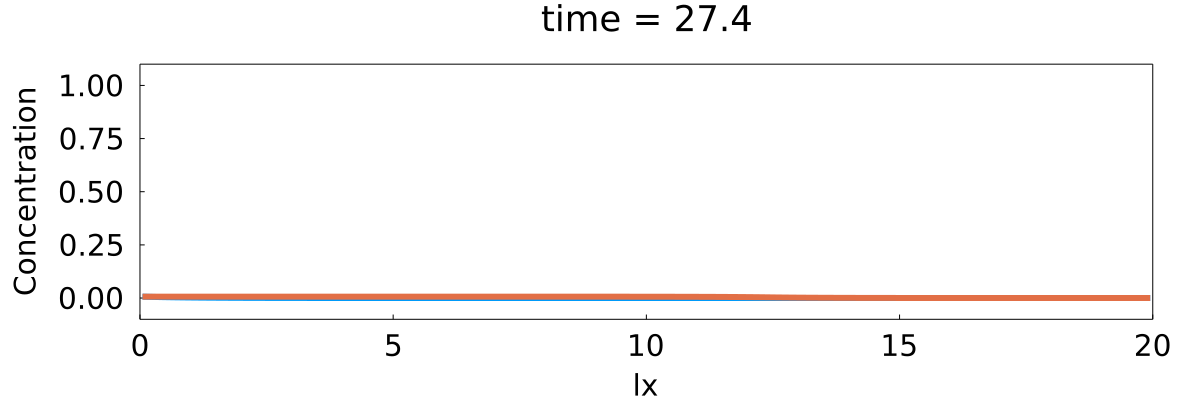

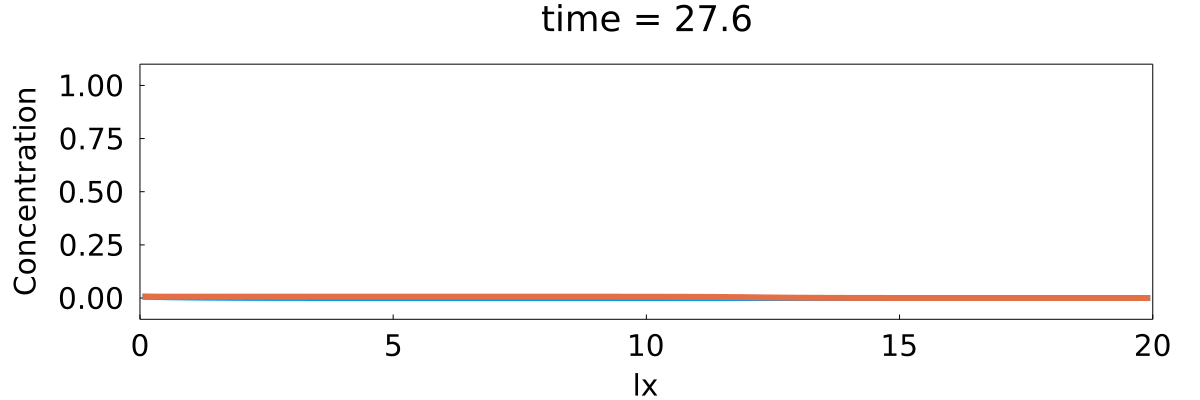

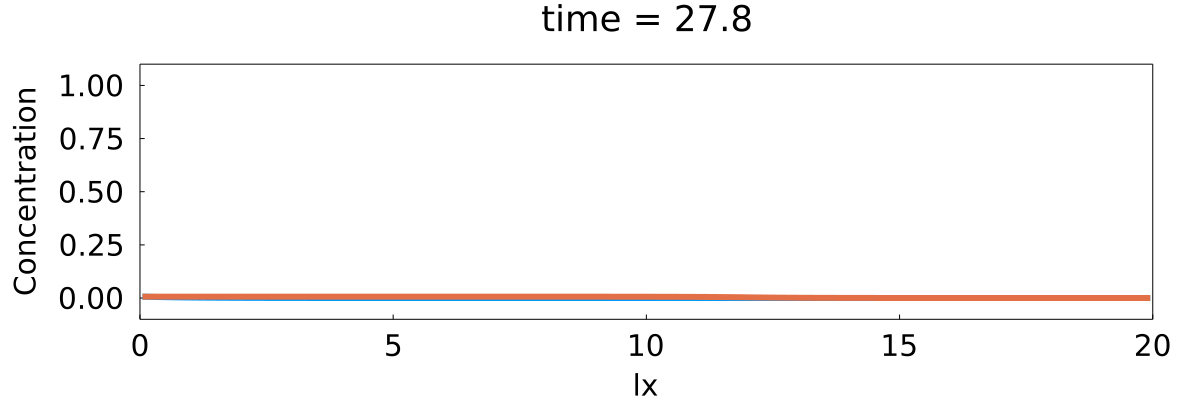

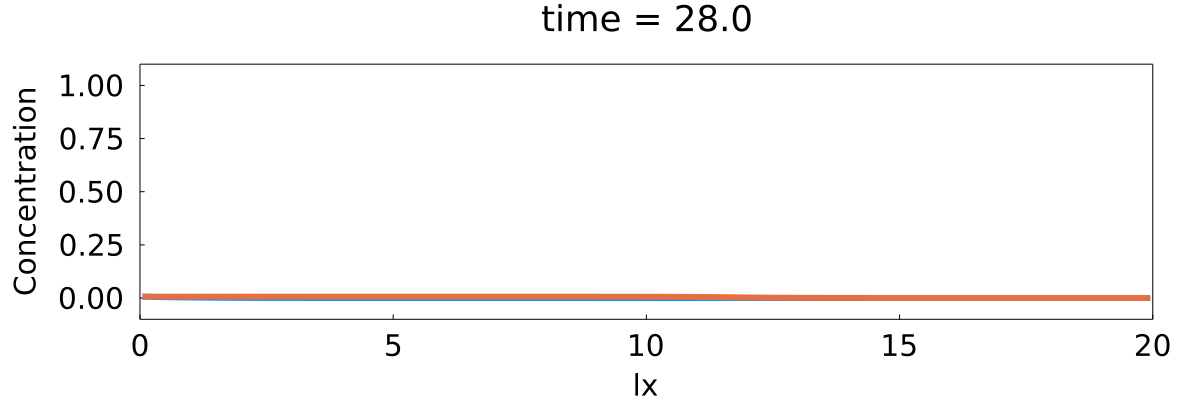

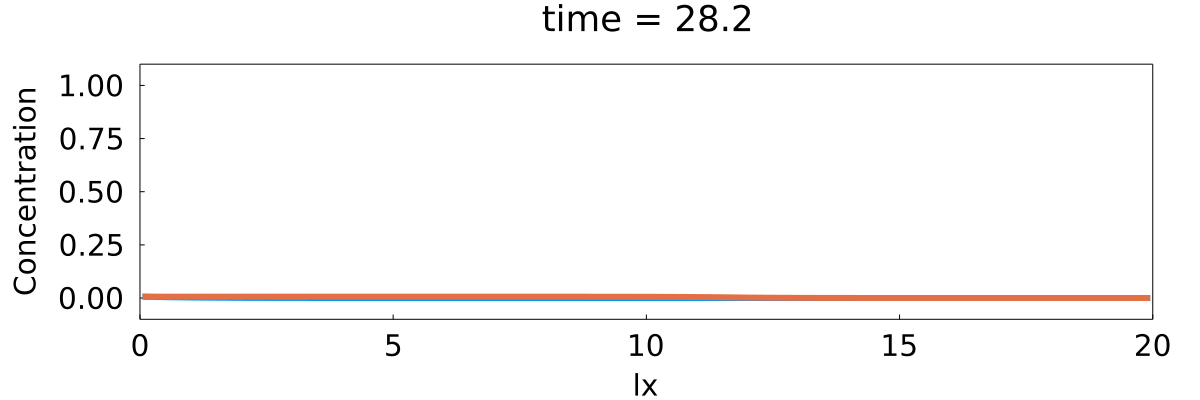

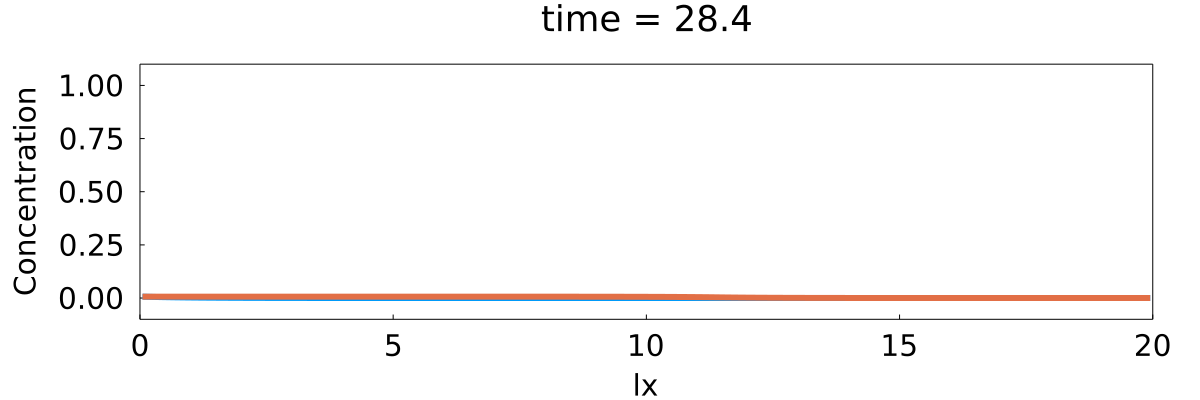

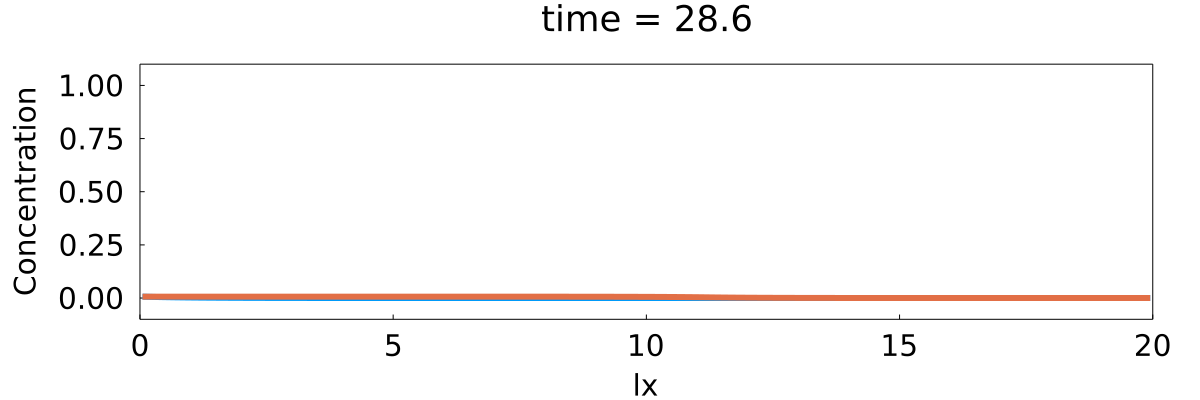

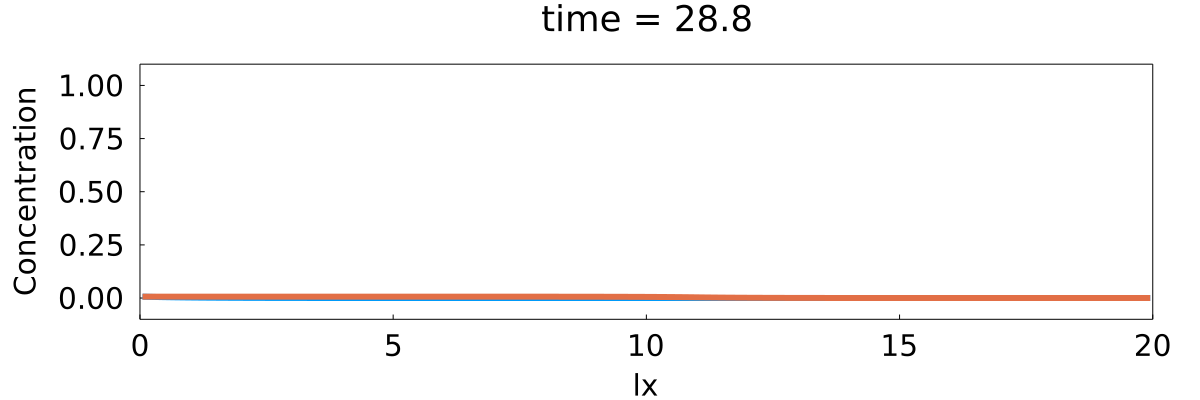

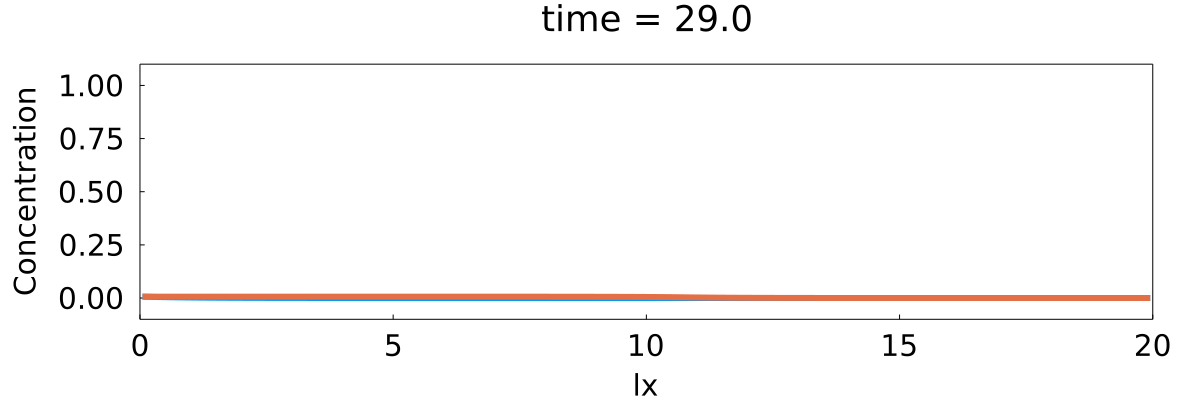

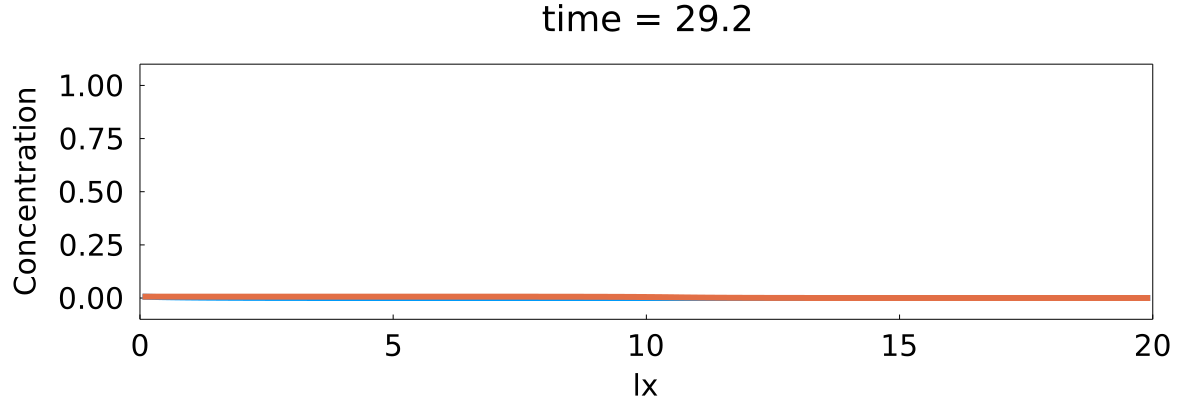

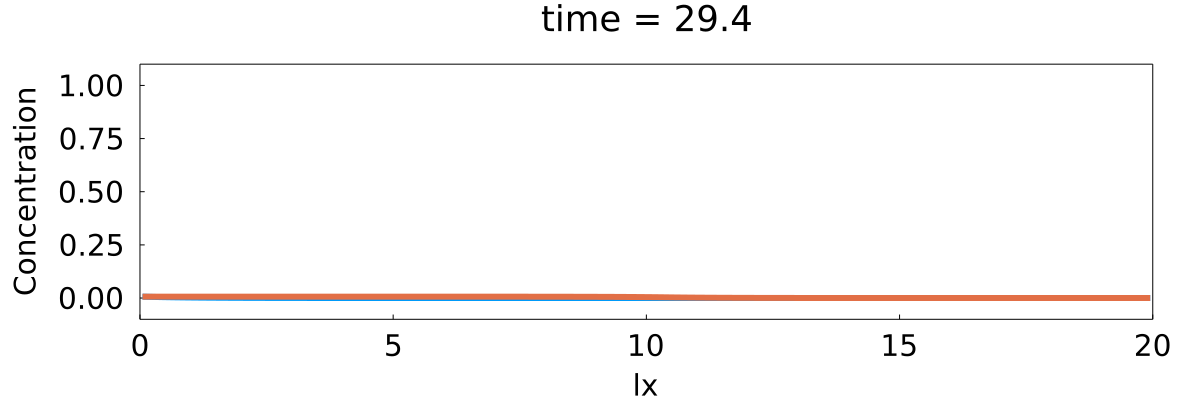

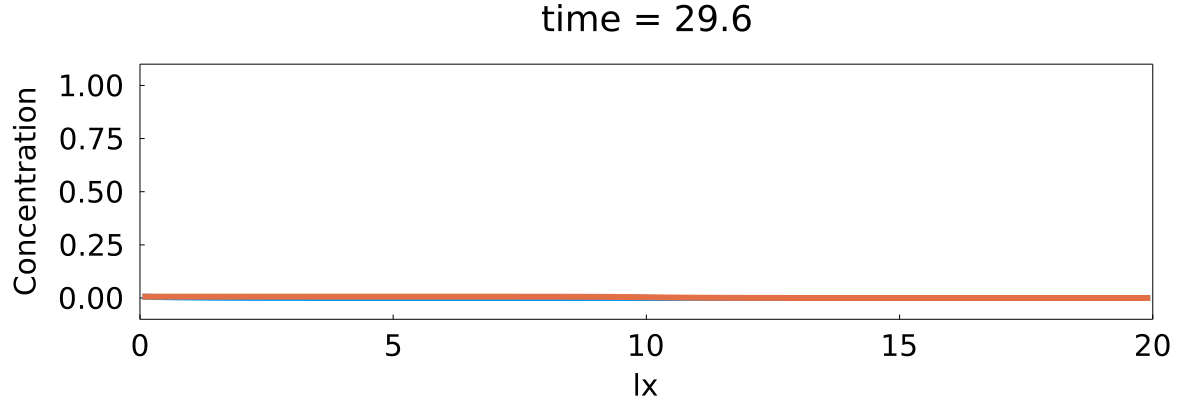

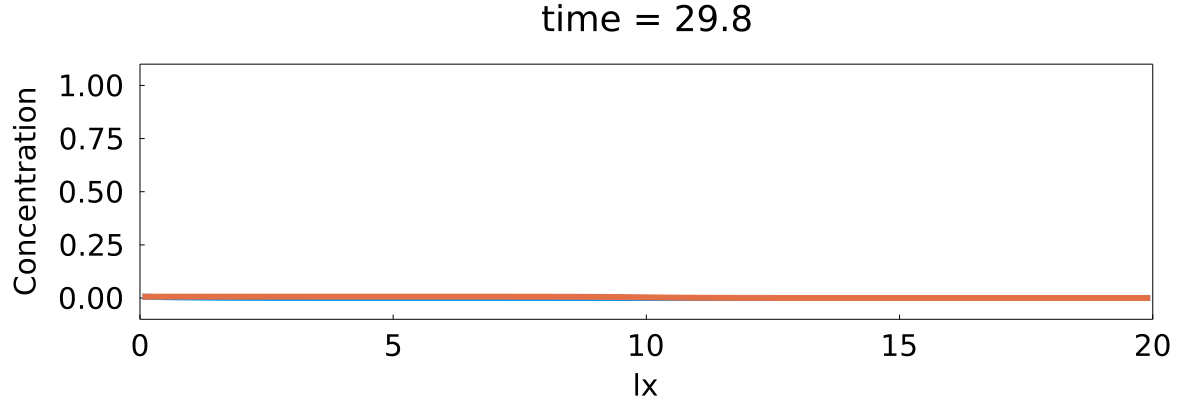

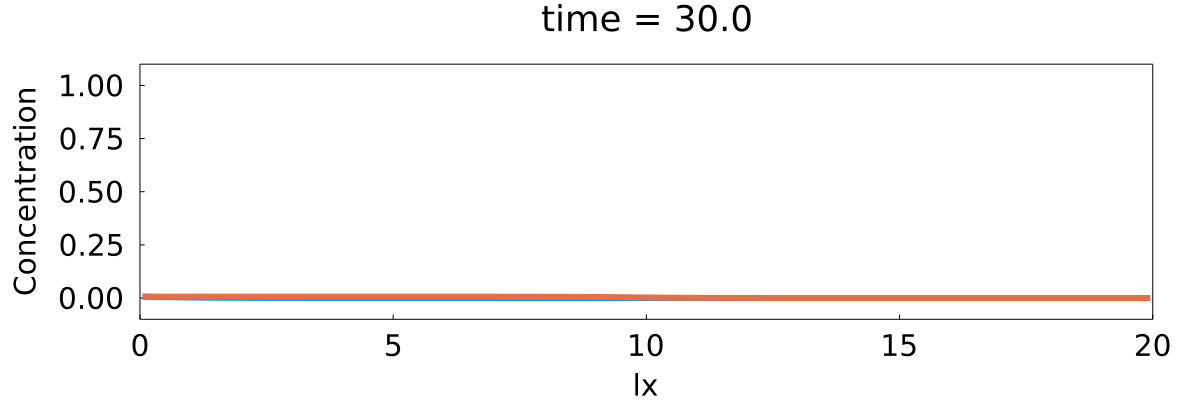

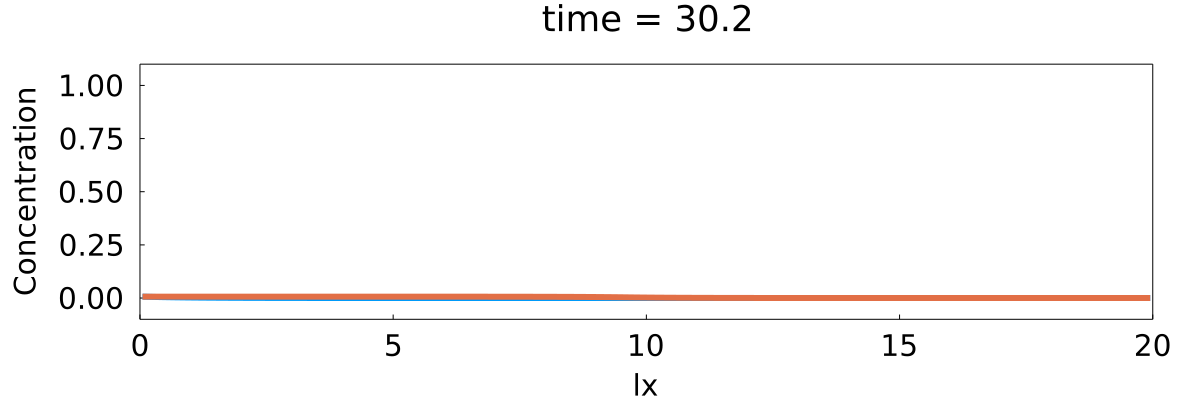

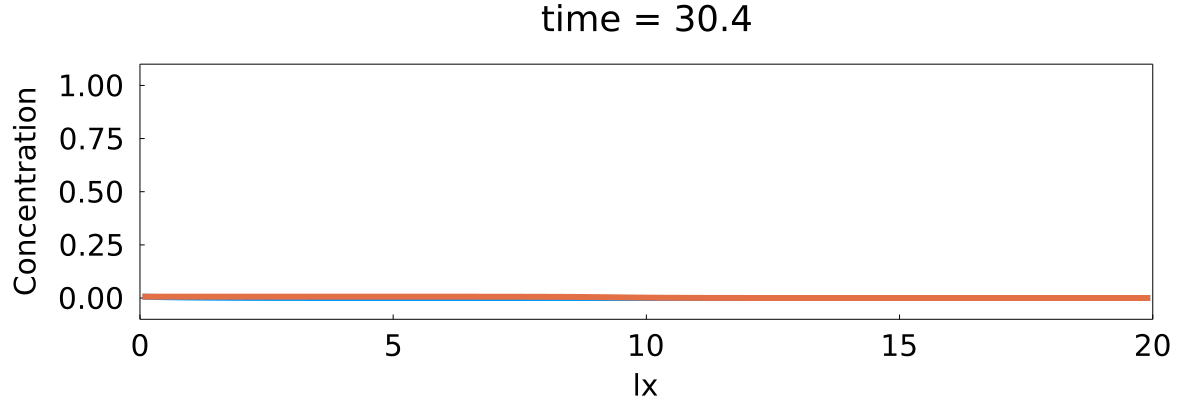

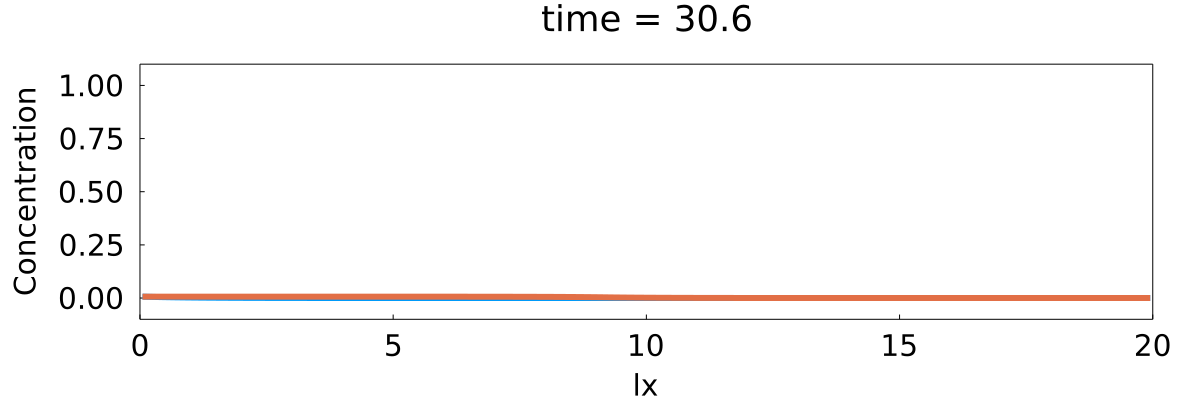

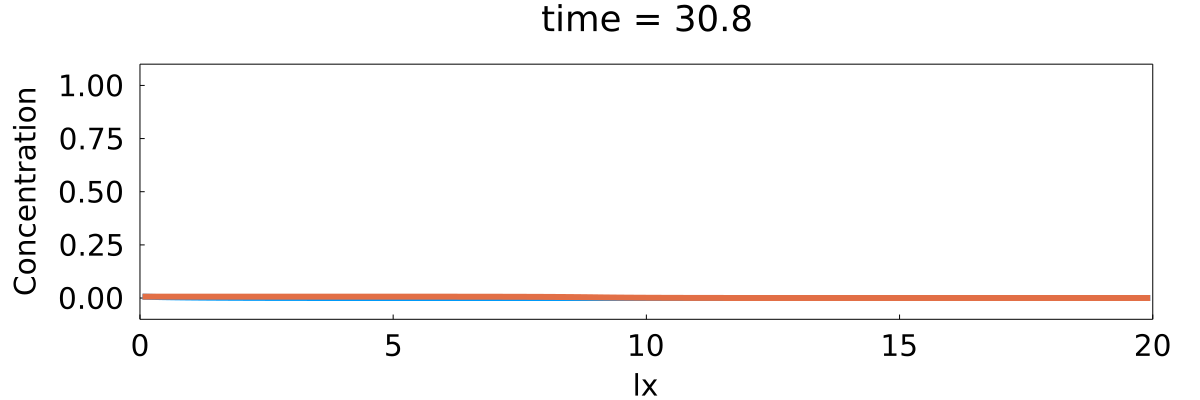

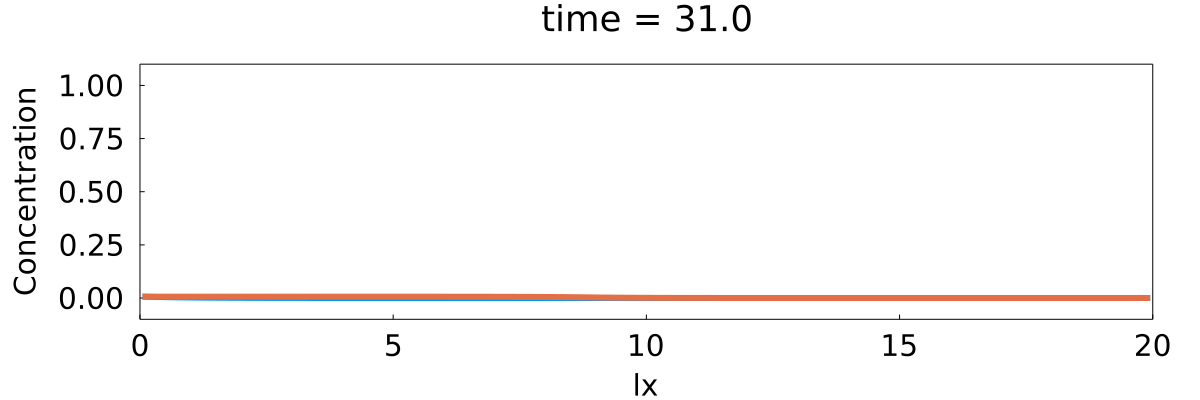

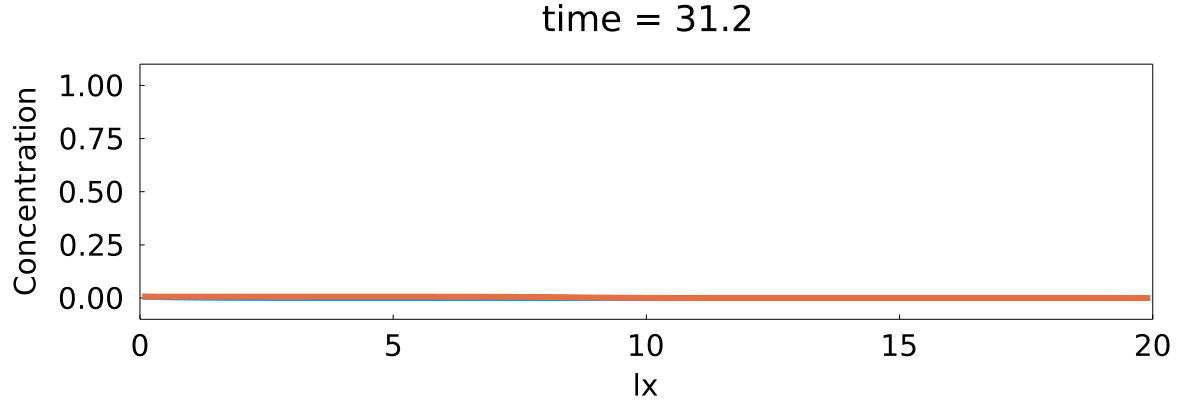

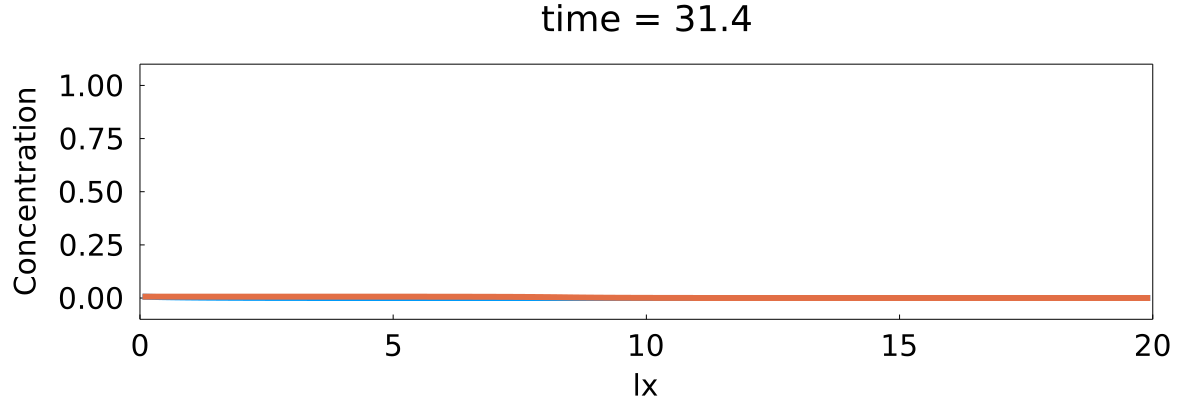

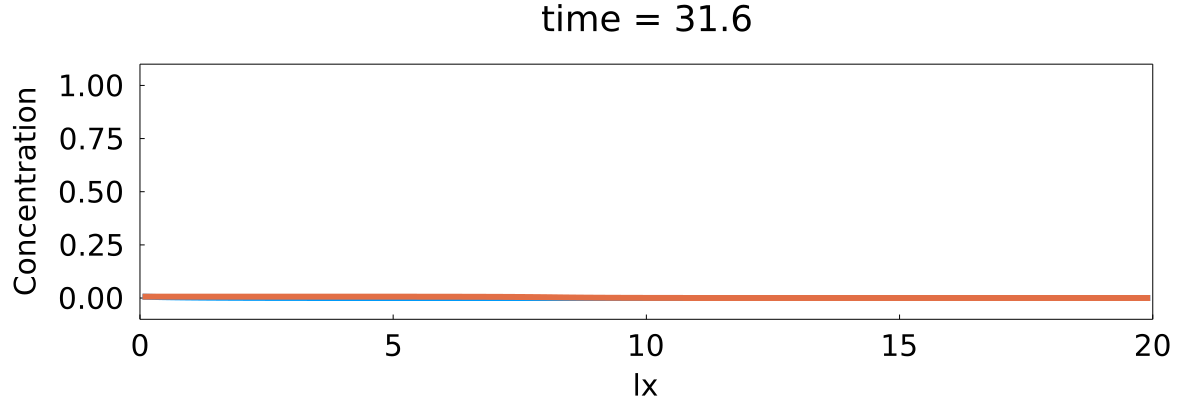

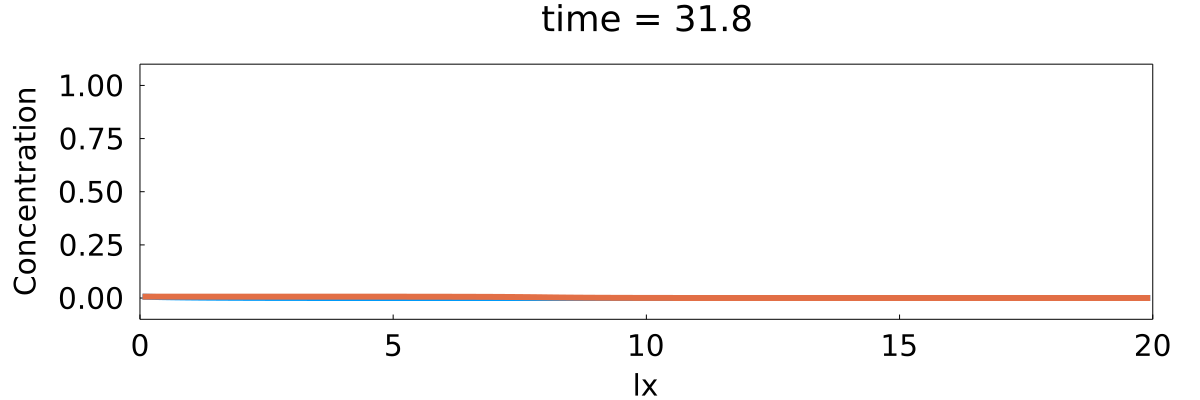

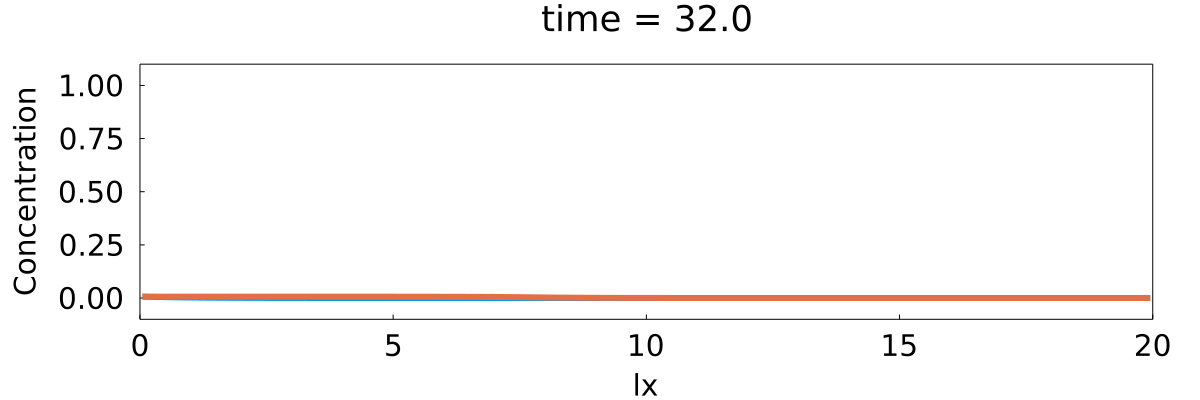

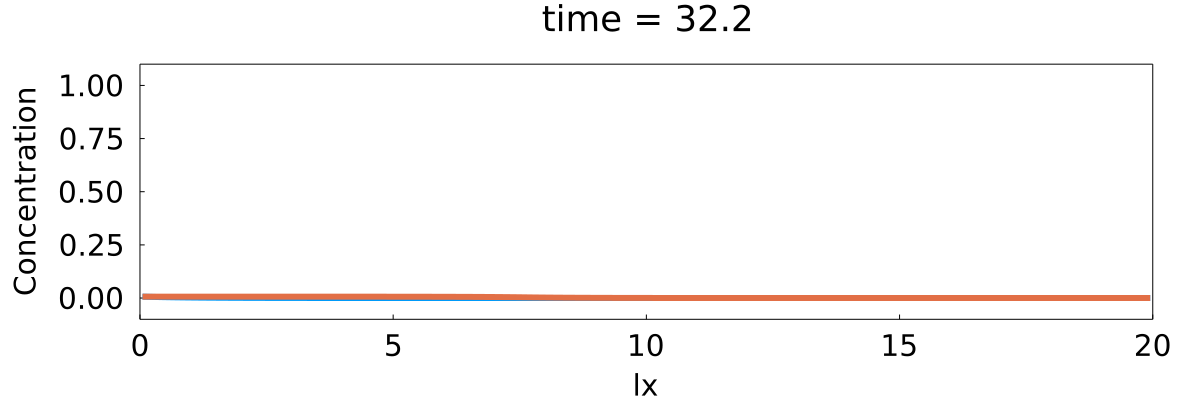

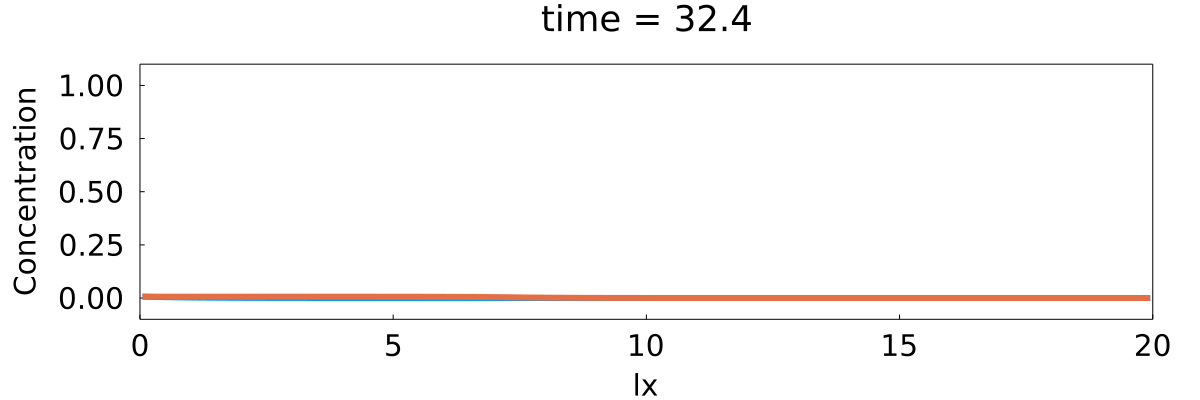

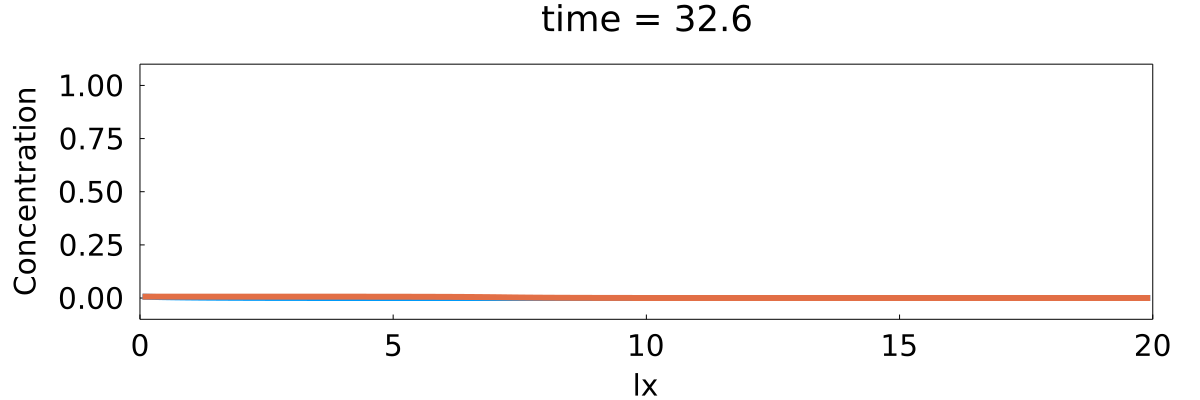

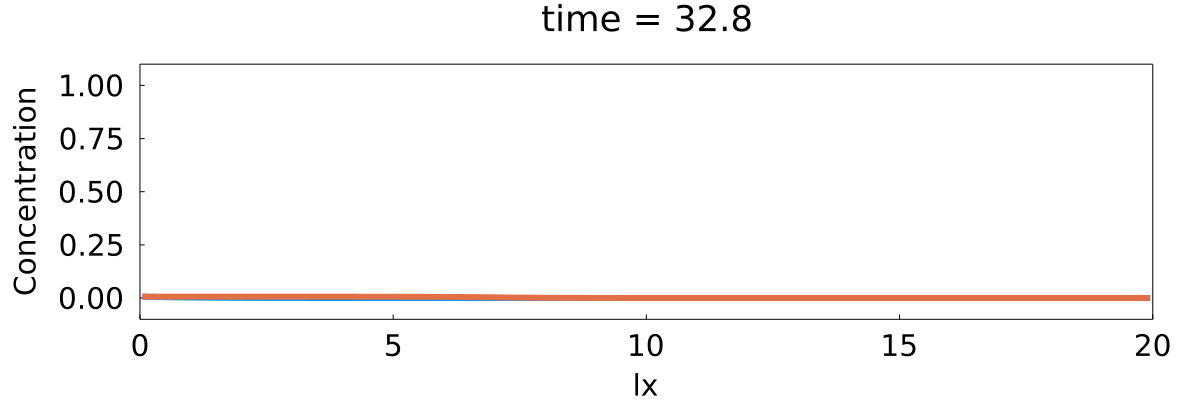

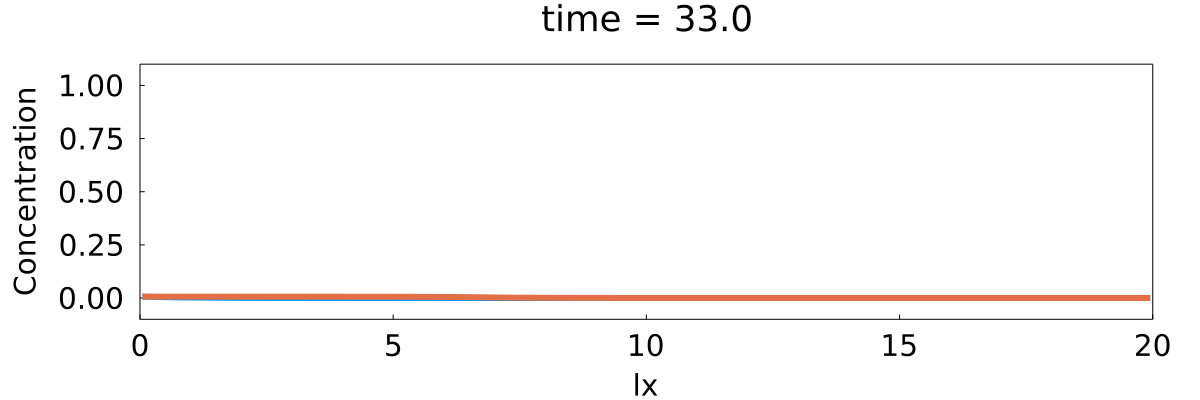

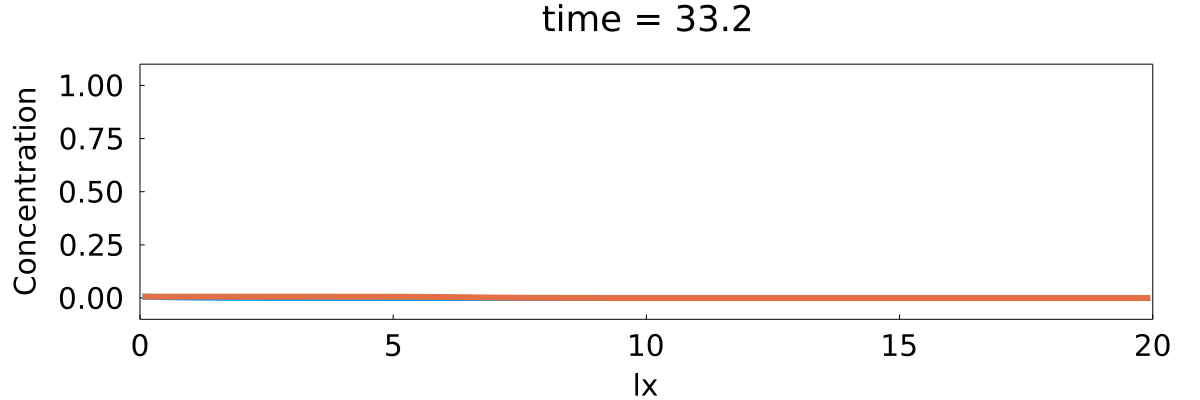

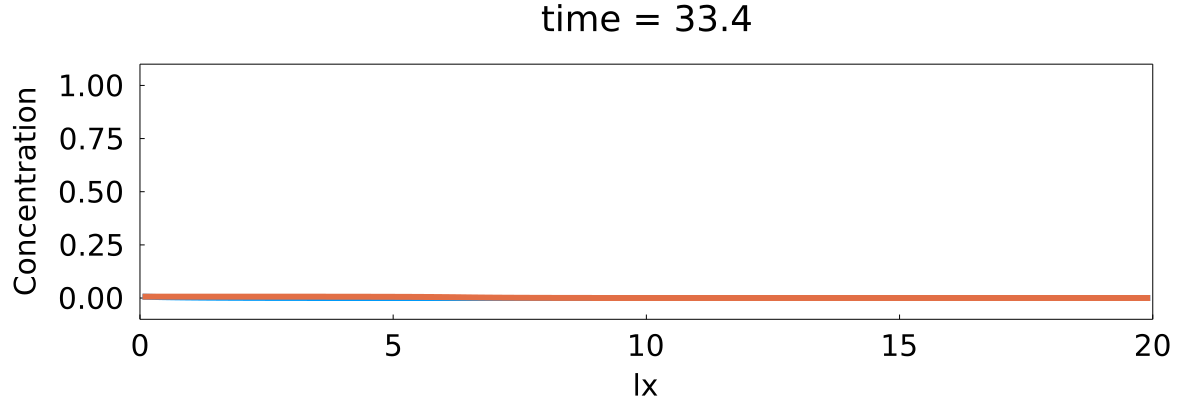

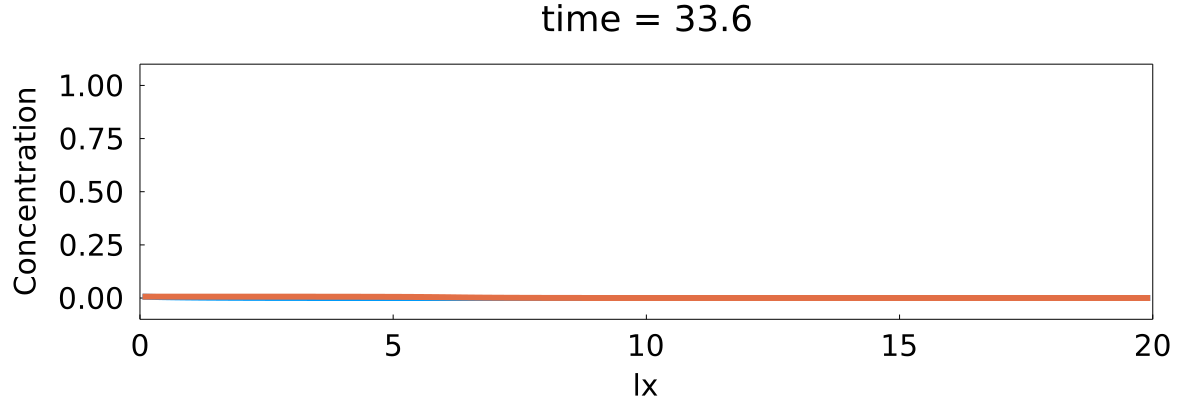

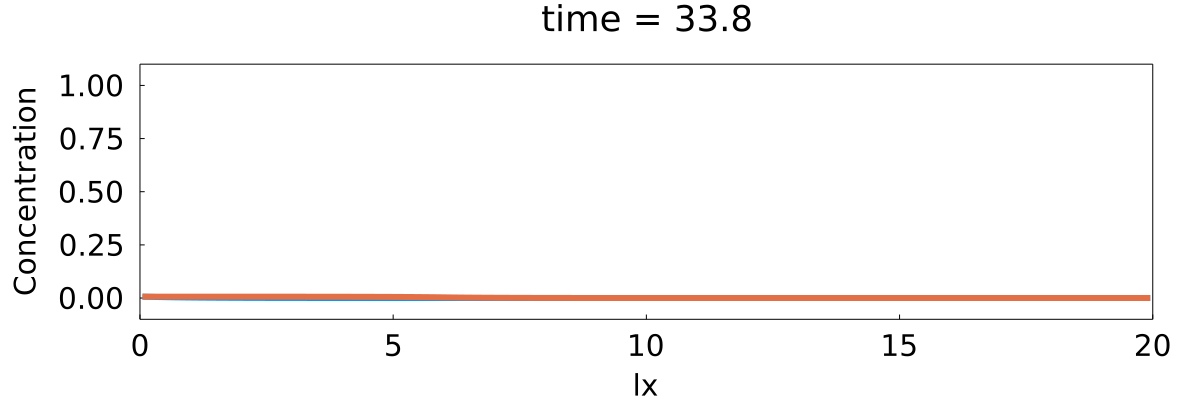

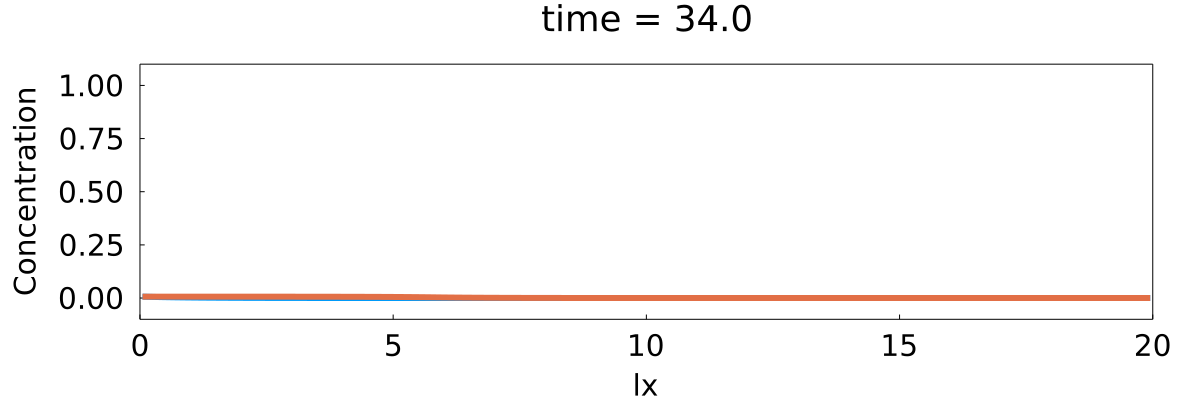

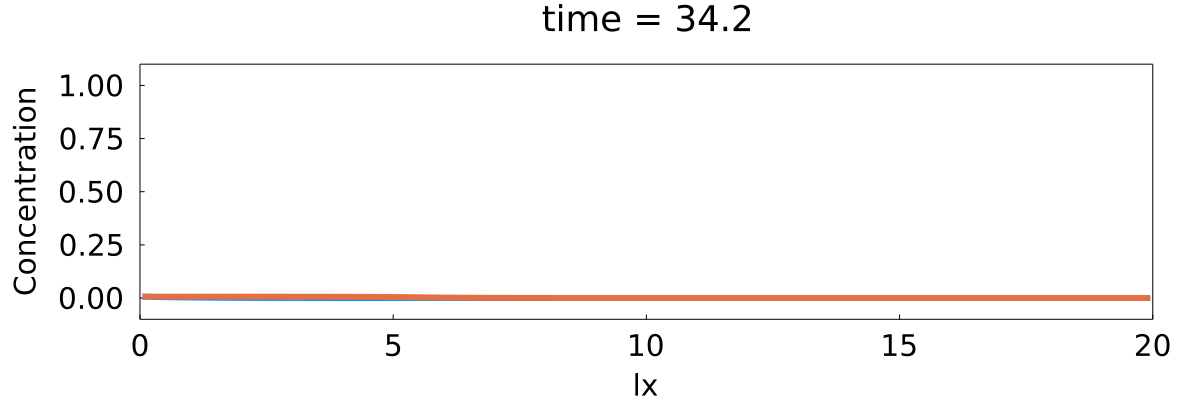

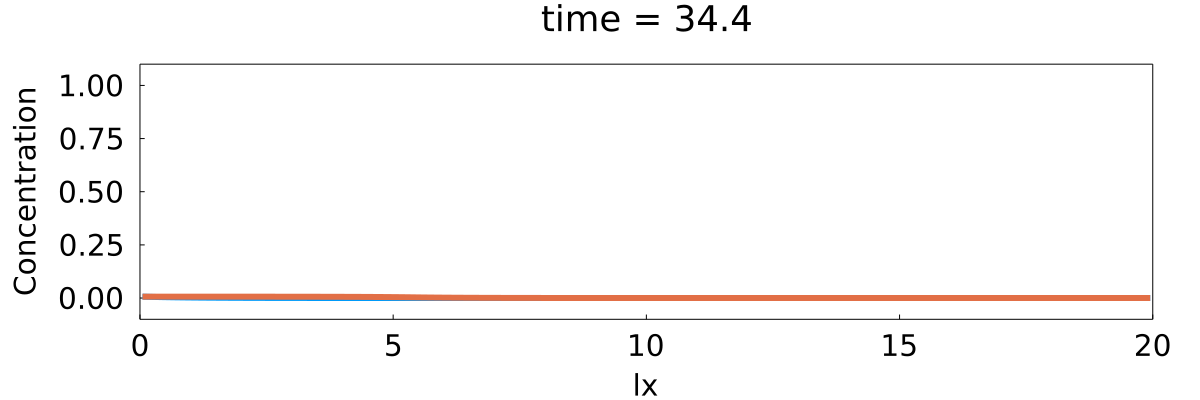

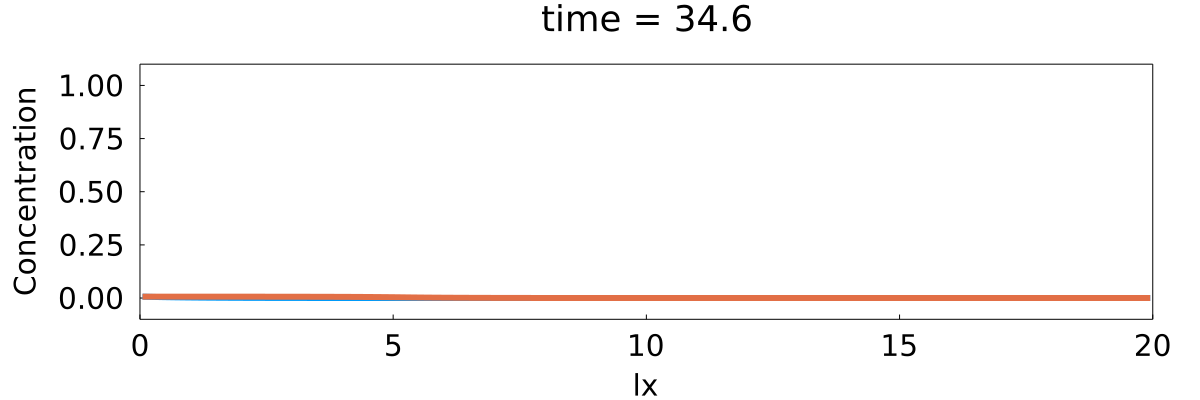

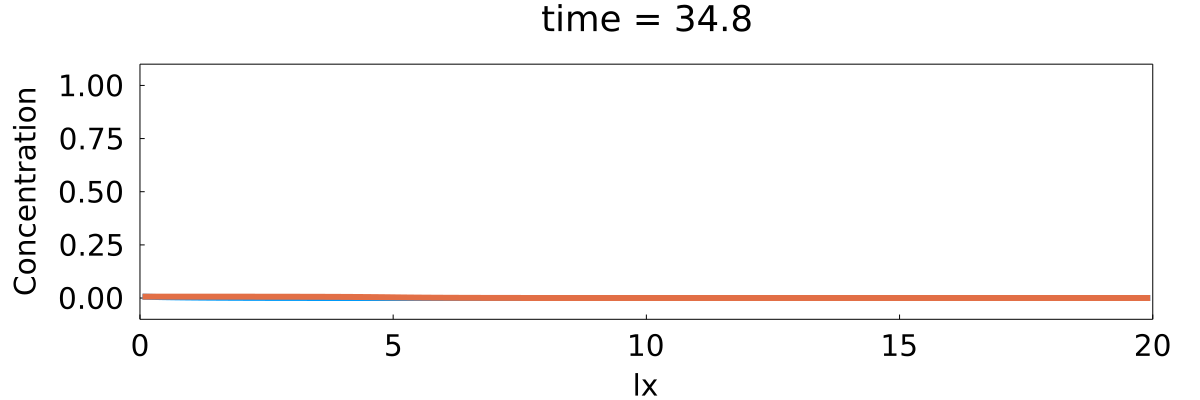

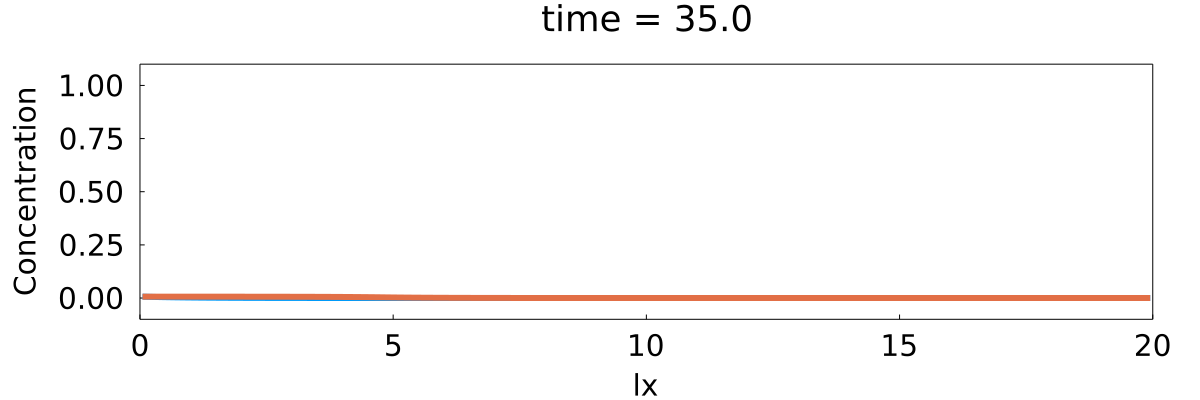

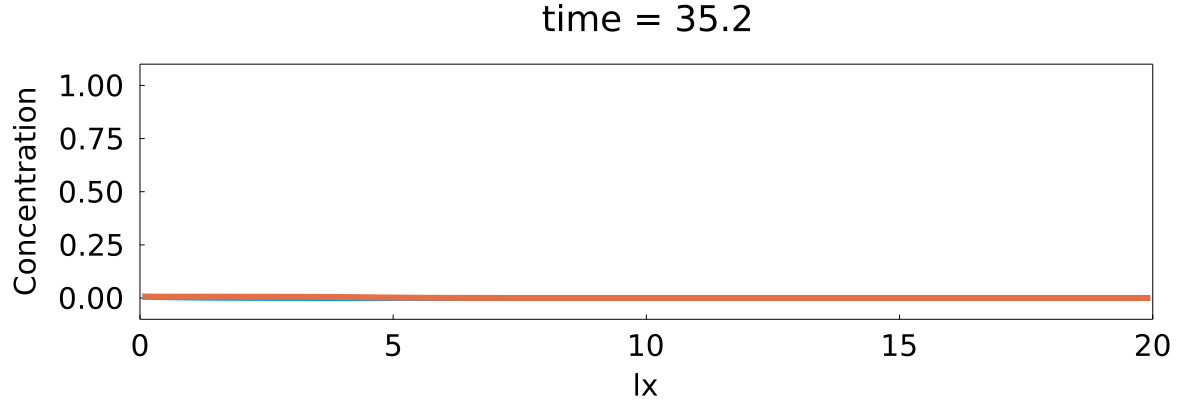

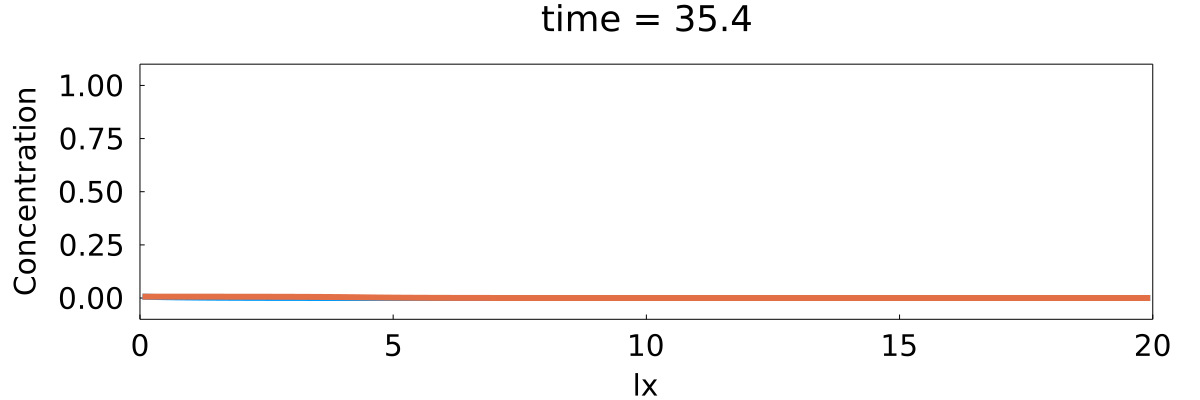

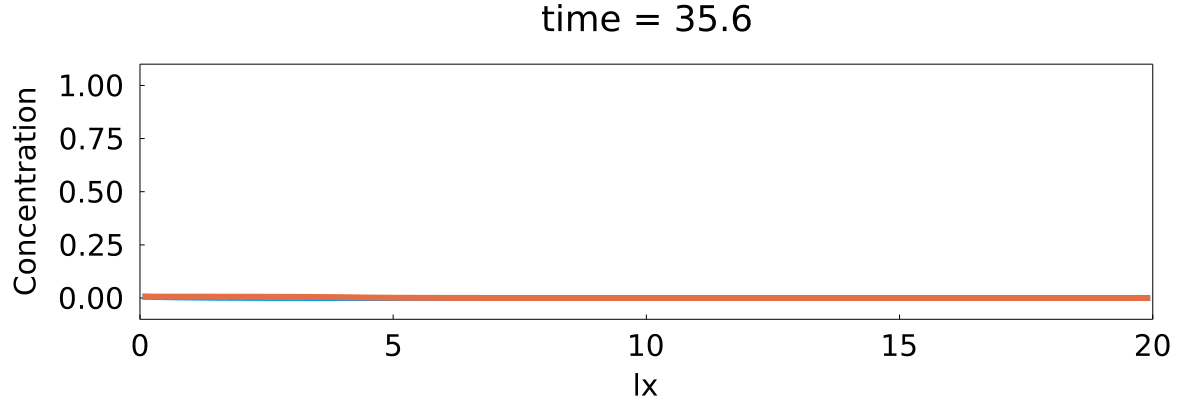

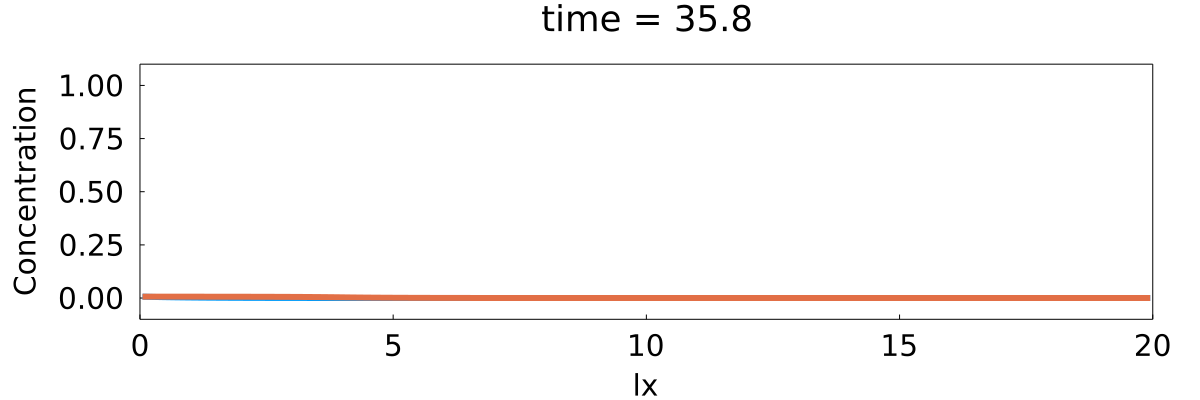

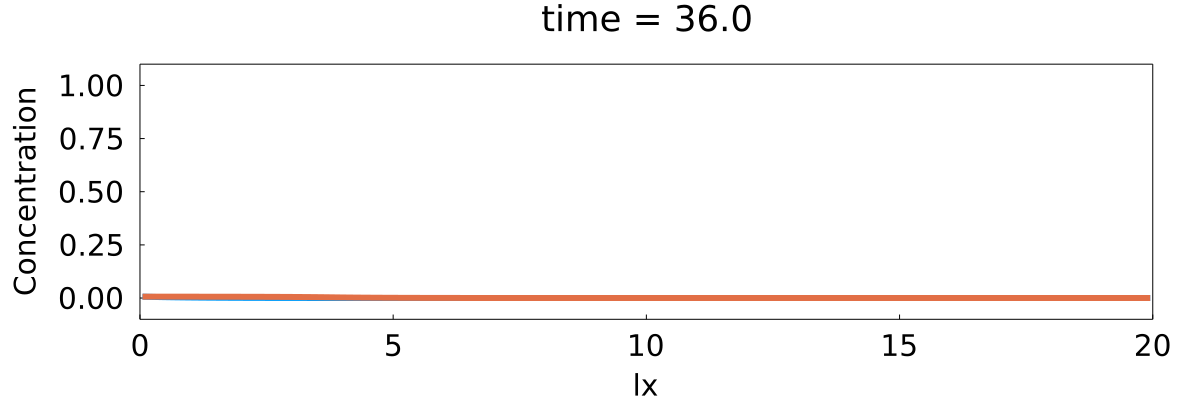

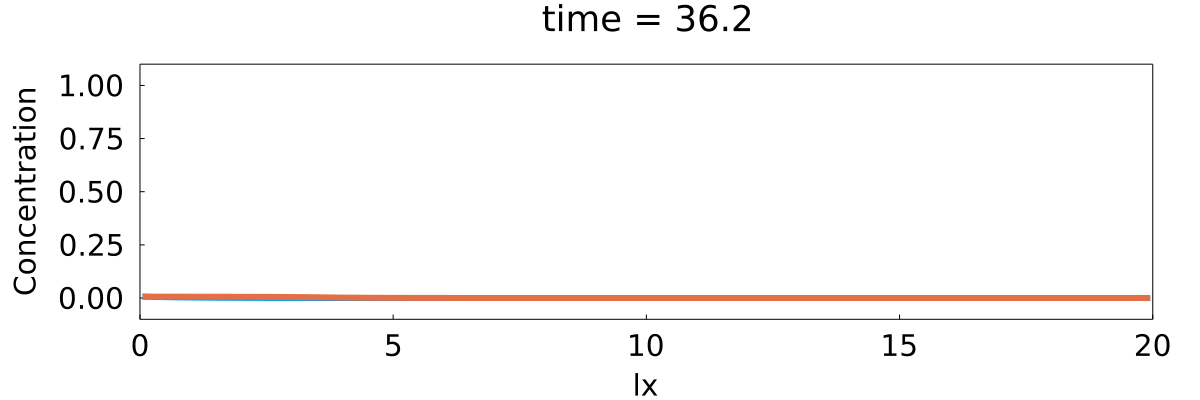

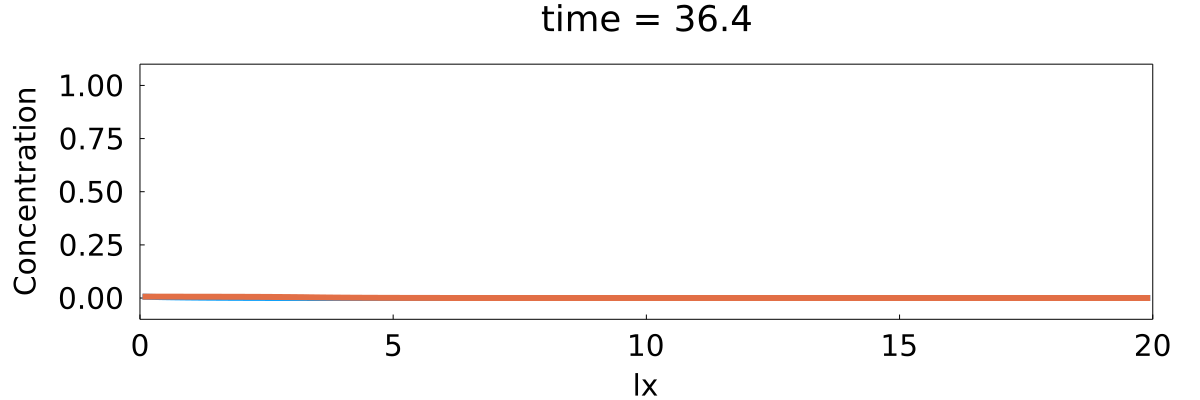

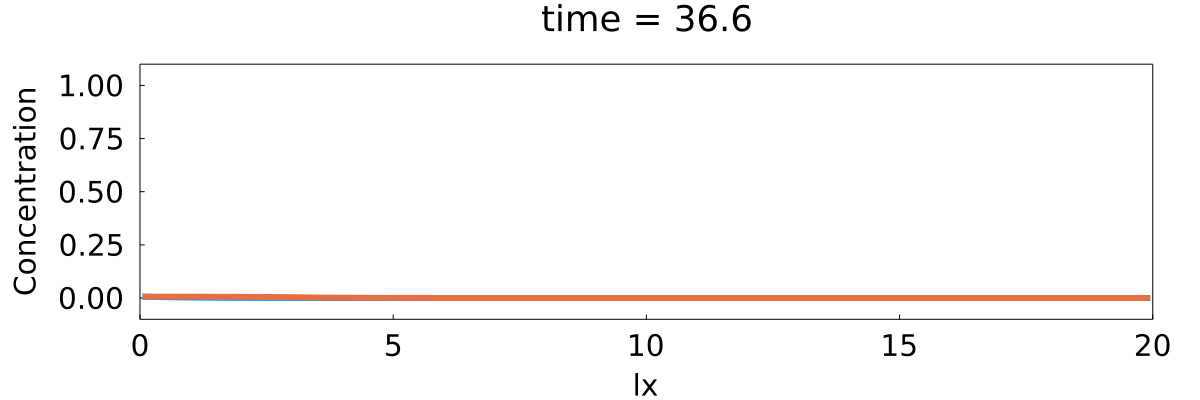

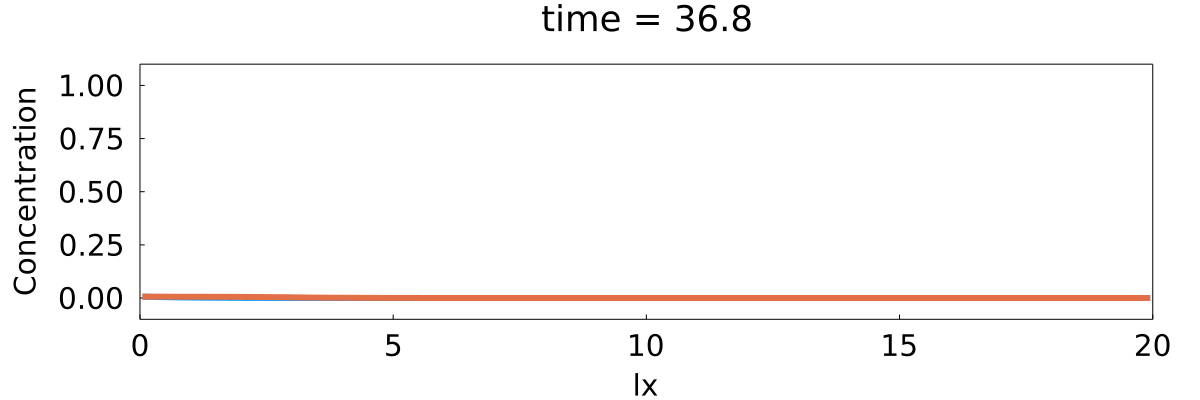

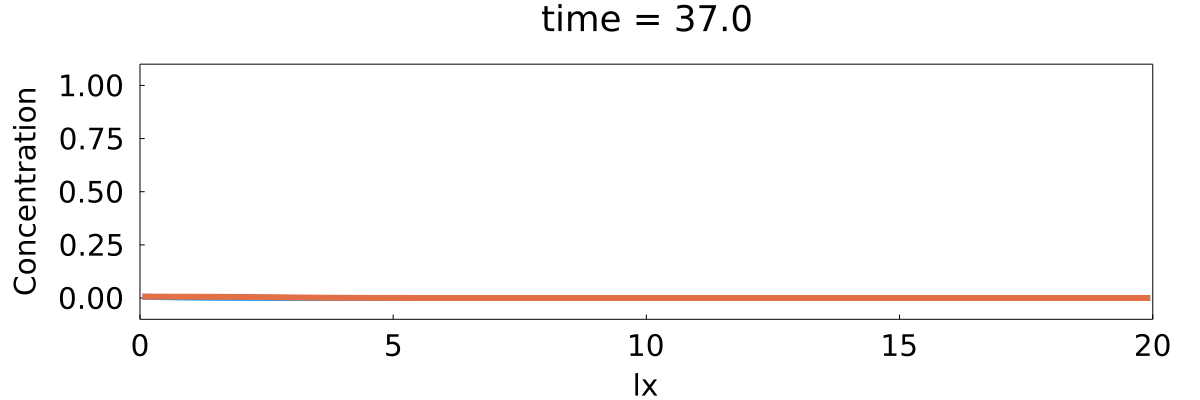

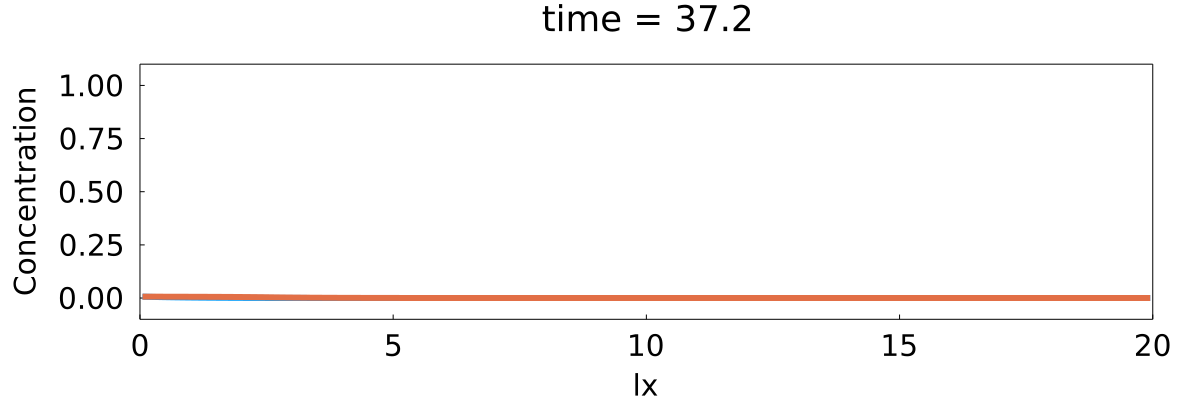

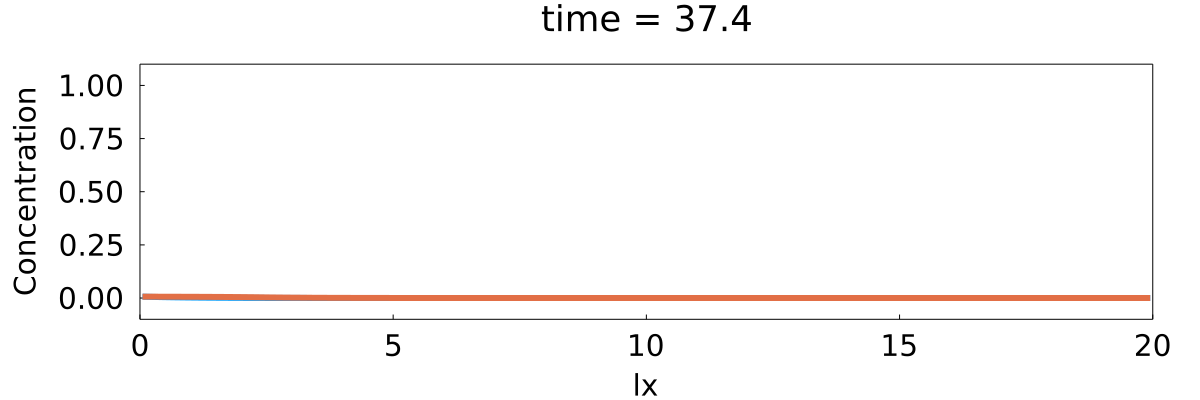

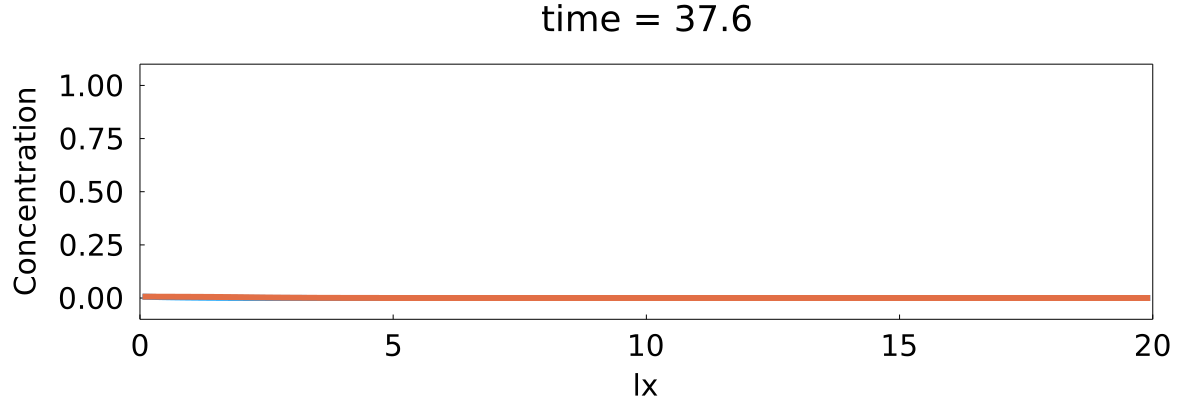

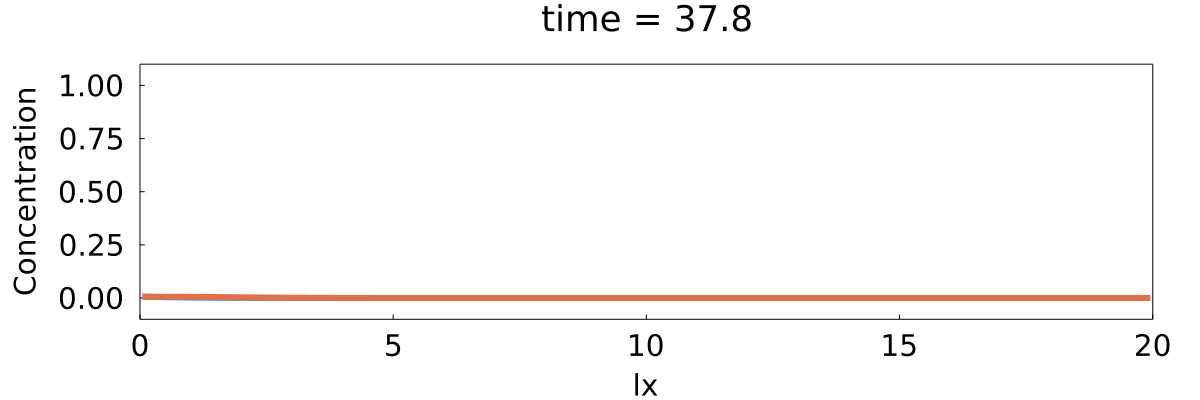

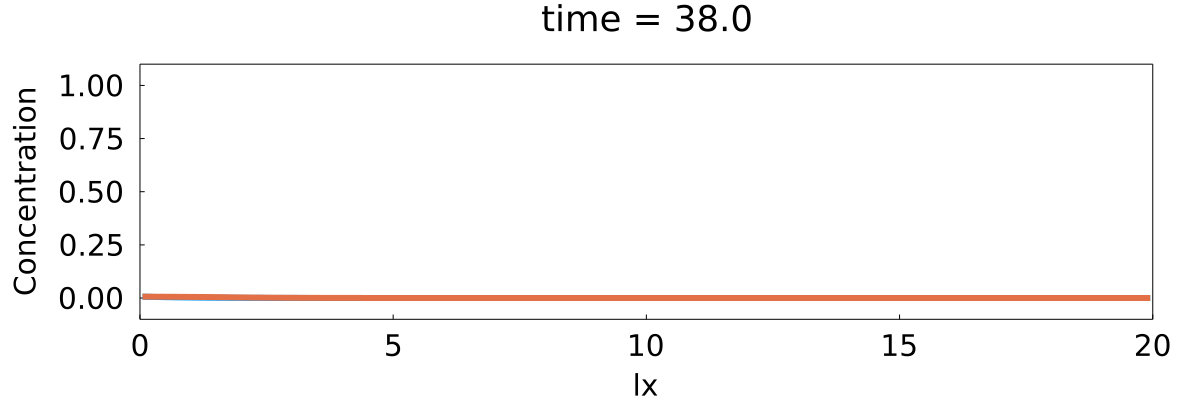

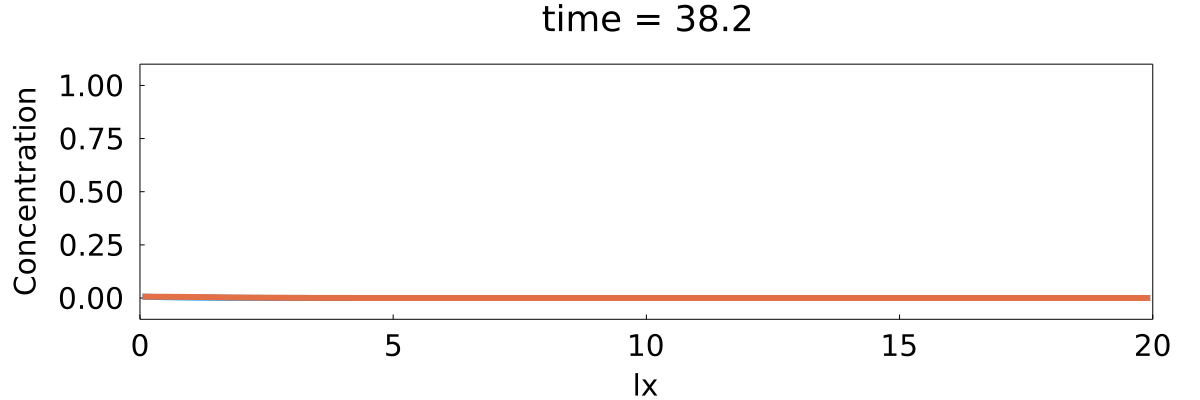

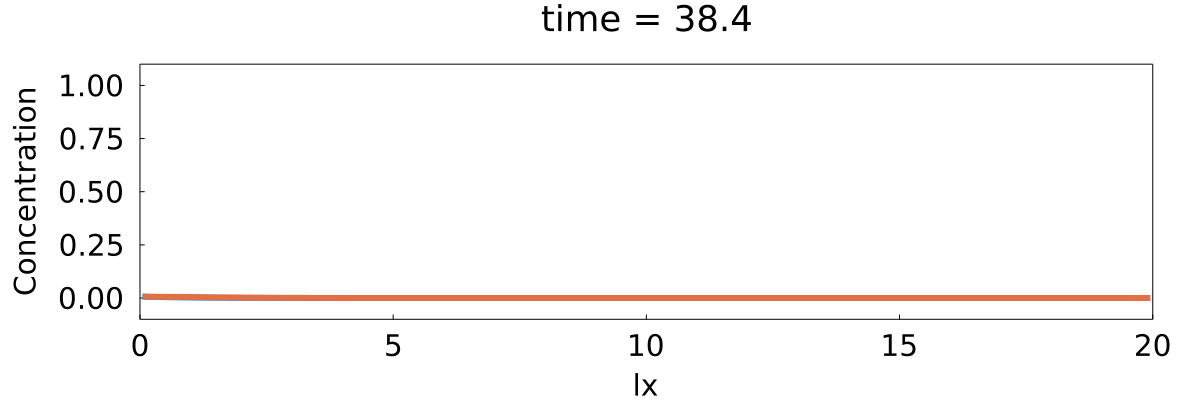

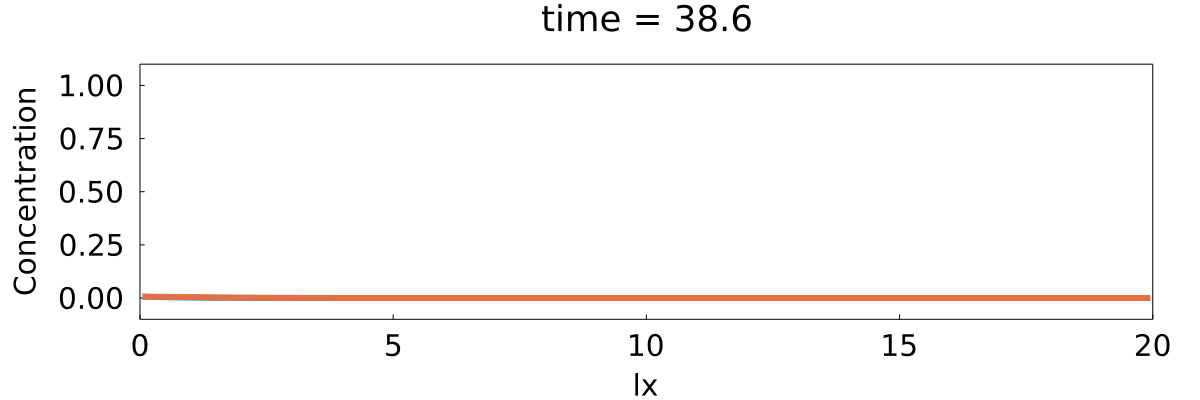

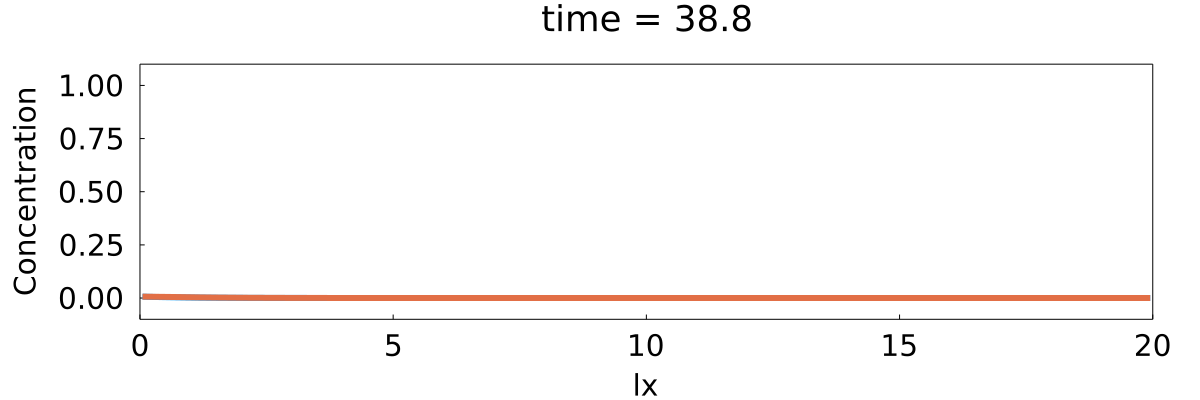

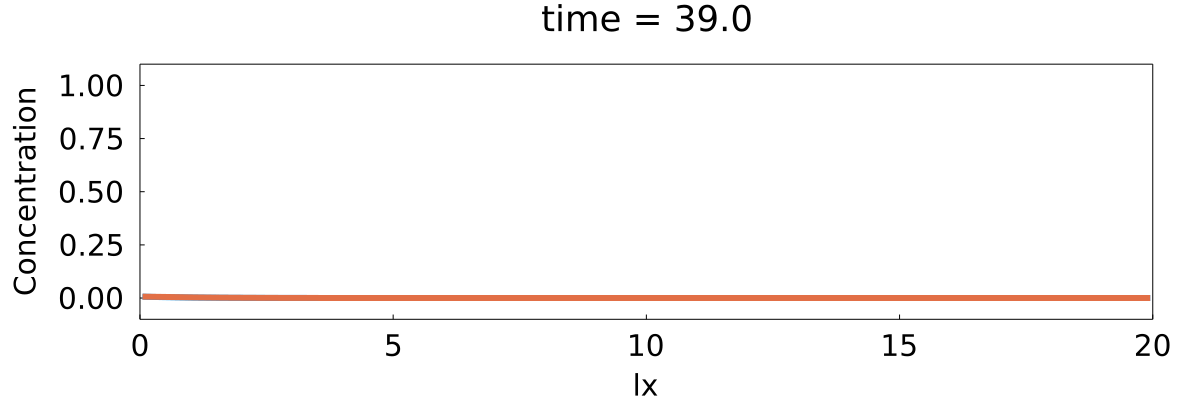

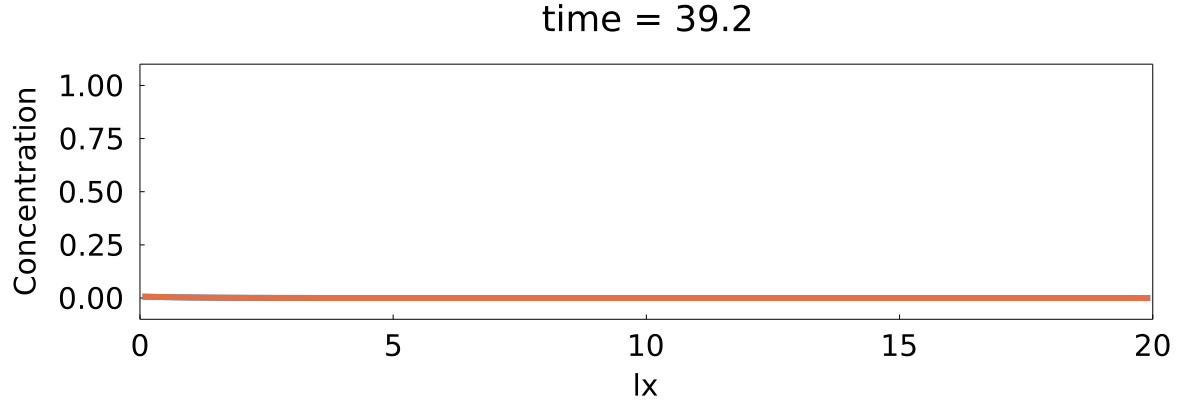

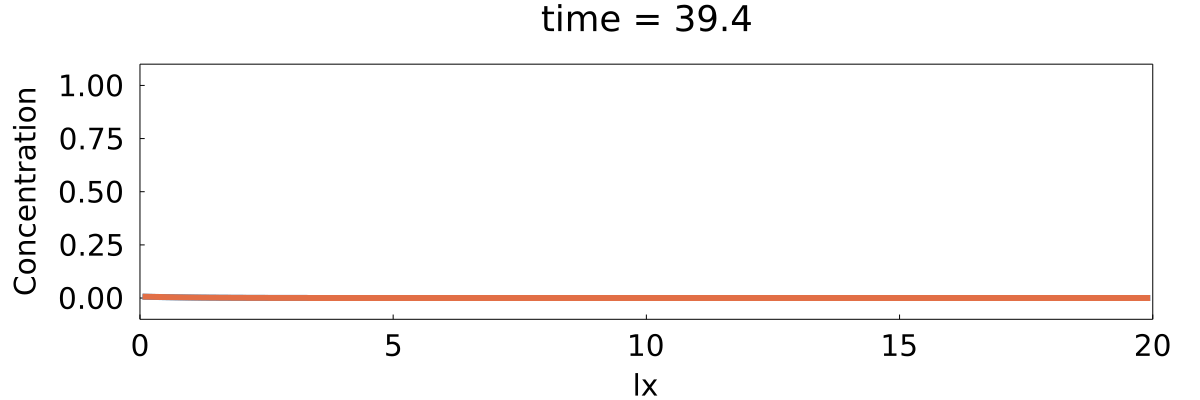

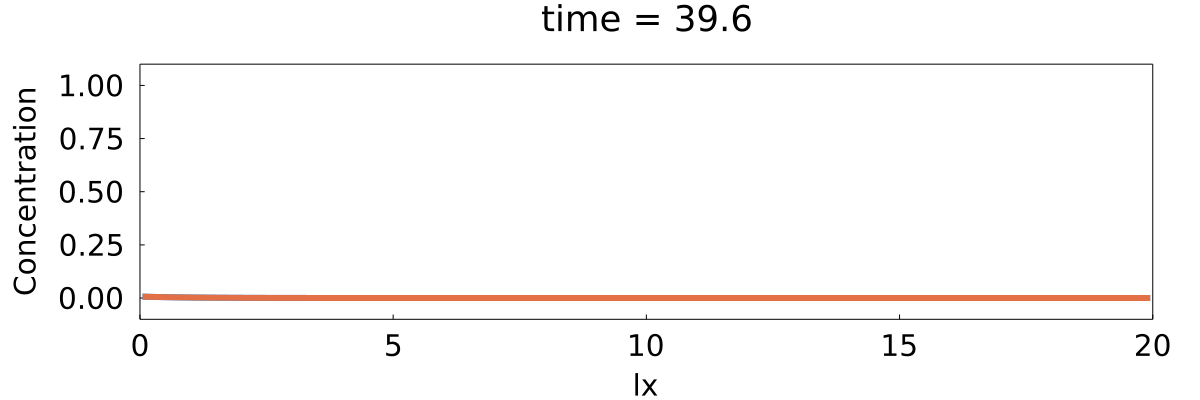

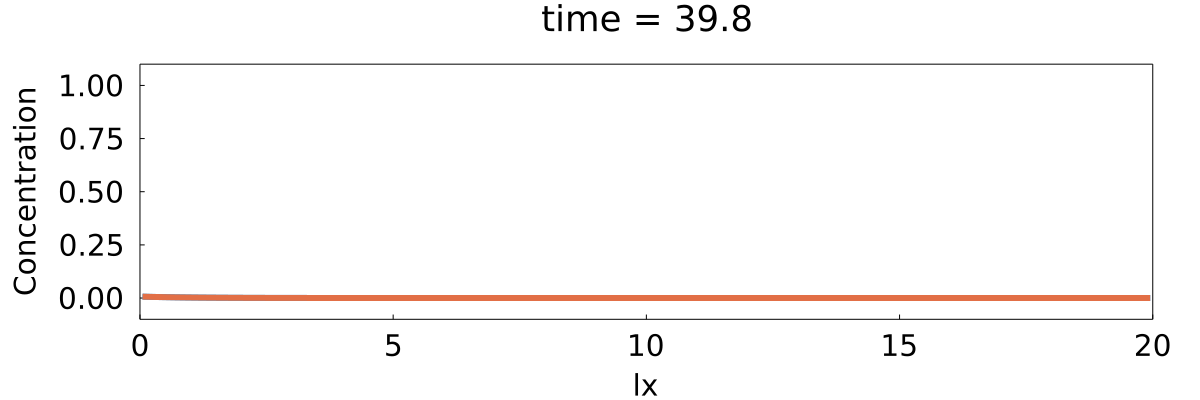

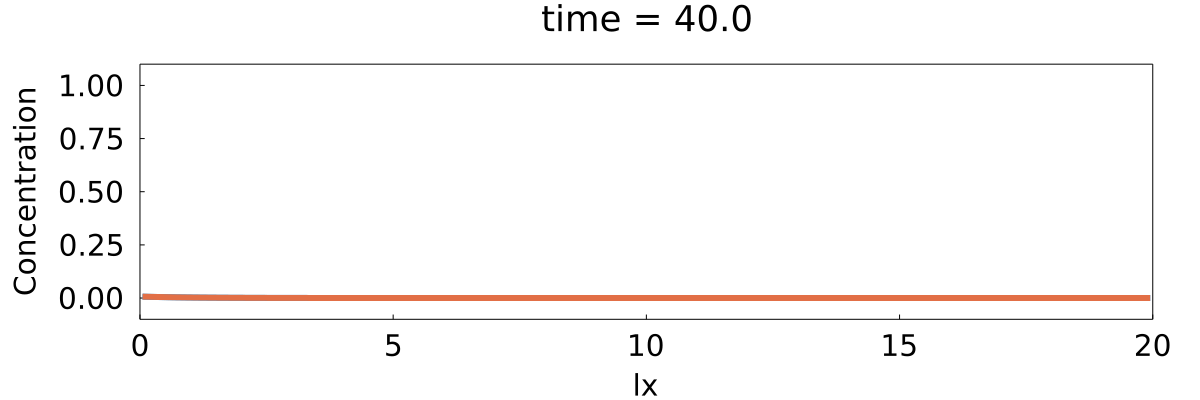

In [15]:
using Plots,Plots.Measures,Printf
default(size=(1200,400),framestyle=:box,label=false,grid=false,margin=10mm,lw=6,labelfontsize=20,tickfontsize=20,titlefontsize=24)

@views function acoustic_1D()
    # physics
    lx   = 20.0
    rho,beta = 1.0,1.0
    # numerics
    nx   = 200
    nvis = 2
    # derived numerics
    dx   = lx/nx
    dt   = dx/sqrt(1.0/rho/beta)
    nt   = nx^2 ÷ 100
    xc   = LinRange(dx/2,lx-dx/2,nx)
    # array initialisation
    Pr   = @. exp(-(xc+lx/4)); P_i = copy(Pr)
    Vx   = zeros(Float64, nx-1)
    # time loop
    for it = 1:nt
        Vx          .-= dt./rho .*diff(Pr)./dx
        Pr[2:end-1] .-= dt./beta.*diff(Vx)./dx
        ((it%nvis) == 0) && display(
        plot(xc,[P_i,Pr];xlims=(0,lx), ylims=(-0.1,1.1),
                        xlabel="lx", ylabel="Concentration",
                        title="time = $(round(it*dt,digits=1))")
        )
    end
end

acoustic_1D()

| Diffusion                                                            | Wave propagation                                                                    |
|:--------------------------------------------------------------------:|:-----------------------------------------------------------------------------------:|
| $$ q = -D\frac{\partial C}{\partial x} $$                            | $$ \frac{\partial V_x}{\partial t} = -\frac{1}{\rho}\frac{\partial P}{\partial x} $$  |
| $$ \frac{\partial C}{\partial t} = -\frac{\partial q}{\partial x} $$ | $$ \frac{\partial P}{\partial t} = -\frac{1}{\beta}\frac{\partial V_x}{\partial x} $$ |

## First-order PDEs - advection

<center>
  <video width="80%" autoplay loop controls src="./figures/advection_1D.mp4"/>
</center>

> Advection is a partial differential equation that governs the motion of a conserved scalar field as it is advected by a known velocity vector field. [_Wikipedia_](https://en.wikipedia.org/wiki/Advection)

We will here briefly discuss advection of a quantity $C$ by a constant velocity $v_x$ in the one-dimensional x-direction.

$$ \frac{∂C}{∂t} = -\frac{∂(v_x~C)}{∂x} ~.$$

In case the flow is incompressible ($\nabla\cdot v = 0$ - here $\nabla\cdot v = \frac{∂v_x}{∂x}$), the advection equation can be rewritten as

$$ \frac{∂C}{∂t} = -v_x \frac{∂C}{∂x} ~.$$

Let's implement the advection equation, following the same code structure as for the diffusion and the acoustic wave propagation.


```julia
# physics
lx   = 20.0
vx   = 1.0
```

The only change in the `# derived numerics` section is the numerical time step definition to comply with the [CFL condition](https://en.wikipedia.org/wiki/Courant–Friedrichs–Lewy_condition) for explicit time integration.

```julia
# derived numerics
dt   = dx/abs(vx)
```

In the `# array initialisation` section, initialise the quantity `C` as a Gaussian profile of amplitude 1, standard deviation 1, with centre located at $c = 0.4 l_x$.

```julia
C = exp.( ... )
```

> 💡 hint: Gaussian distribution as function of coordinate $x_c$, $ C = \exp(x_c - c)^2 $

Update `C` as following:

```julia
C .-= dt.*vx.*diff(C)./dx # doesn't work
```

This doesn't work because of the mismatching array sizes.

There are at least three (naive) ways to solve the problem: update `C[1:end-1]`, `C[2:end]`, or one could even update `C[2:end-1]` with the spatial average of the rate of change `dt.*vx.*diff(C)./dx`.

👉 Your turn. Try it out yourself and motivate your best choice.

┌ Info: Saved animation to 
│   fn = /Users/ludovic/Documents/git/github_vaw/course-101-0250-00/slide-notebooks/notebooks/tmp.gif
└ @ Plots /Users/ludovic/.julia/packages/Plots/FCUr0/src/animation.jl:137


Plots.AnimatedGif("/Users/ludovic/Documents/git/github_vaw/course-101-0250-00/slide-notebooks/notebooks/tmp.gif")
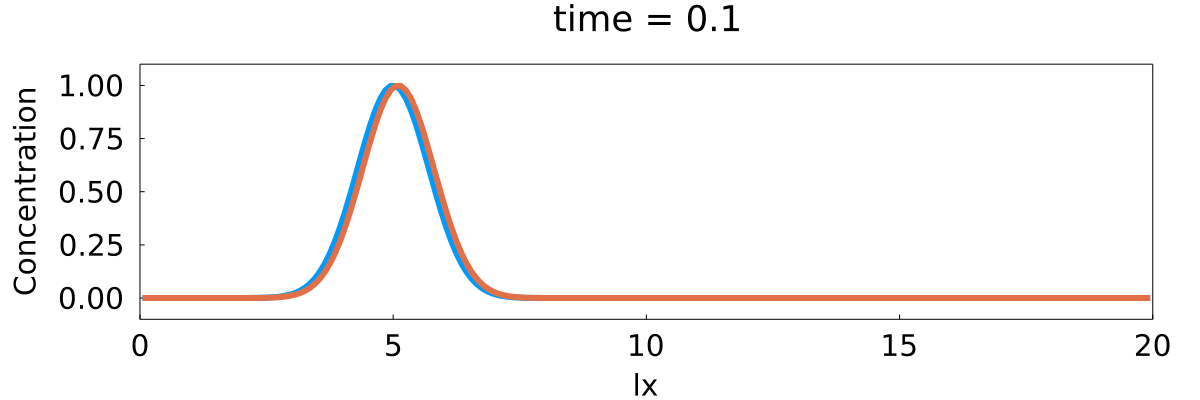

In [23]:
using Plots,Plots.Measures,Printf
default(size=(1200,400),framestyle=:box,label=false,grid=false,margin=10mm,lw=6,labelfontsize=20,tickfontsize=20,titlefontsize=24)
@views function acoust_1D()
    # physics
    lx   = 20.0
    vx   = 1.0
    # numerics
    nx   = 200
    nvis = 5
    # derived numerics
    dx   = lx/nx
    dt   = dx/max(abs(vx))
    nt   = nx/2
    xc   = LinRange(dx/2,lx-dx/2,nx)
    # array initialisation
    C    = @. exp(-(xc-lx/4)^2); C_i = copy(C)
    # time loop
    @gif for it = 1:nt
        C[2:end] .-= dt.*vx.*diff(C)./dx
        plot(xc,[C_i,C];xlims=(0,lx), ylims=(-0.1,1.1), xlabel="lx", ylabel="Concentration", title="time = $(round(it*dt,digits=1))")
    end every nvis
end

acoust_1D()

Initialise the simulation

In [ ]:
using Plots,Plots.Measures,Printf
default(size=(1200,400),framestyle=:box,label=false,grid=false,margin=10mm,lw=6,labelfontsize=20,tickfontsize=20,titlefontsize=24)
# physics
lx   = 20.0
vx   = 1.0
# numerics
nx   = 200
nvis = 2
# derived numerics
dx   = lx/nx
dt   = dx/abs(vx)
nt   = nx
xc   = LinRange(dx/2,lx-dx/2,nx)
# array initialisation
#C    = @. exp(...); C_i = copy(C)

Execute the time loop

In [ ]:
# time loop
@gif for it = 1:nt
    #C .-= ...
    (it % (nt÷2) == 0) && (vx = -vx) # change the direction of wave propagation
    plot(xc,[C_i,C];xlims=(0,lx), ylims=(-0.1,1.1),
                    xlabel="lx", ylabel="Concentration",
                    title="time = $(round(it*dt,digits=1))")
end every nvis

Here we go, an upwind approach is needed to implement a stable advection algorithm

```julia
C[2:end]   .-= dt.*vx.*diff(C)./dx # if vx>0
C[1:end-1] .-= dt.*vx.*diff(C)./dx # if vx<0
```

## Nonlinear equations

Previously, we considered only linear equations, which means that the functions being differentiated depend only linearly on the unknown variables. A lot of important physical processes are essentially nonlinear, and could be only described by nonlinear PDEs.

A model of nonlinear parabolic PDE frequently arising in physics features nonlinearity of a power-law type:

$$
\frac{\partial C}{\partial t} + D\frac{\partial^2 C^n}{\partial x^2} = 0
$$

where $n$ is a power-law exponent (here $n=4$).

<center>
  <video width="80%" autoplay loop controls src="./figures/nonlinear_diffusion_1D.mp4"/>
</center>

Such equations describe the deformation of shallow currents of fluids with high viscosity such as ice or lava under their own weight, or evolution of pressure in elastic porous media.

A model of nonlinear advection equation is often referred to as _inviscid Burgers' equation_:

$$
\frac{\partial C}{\partial t} + \frac{\partial C^n}{\partial x} = 0
$$

where $n$ is often assumed to be equal to 2. This equation describes the formation of shock waves.

<center>
  <video width="80%" autoplay loop controls src="./figures/nonlinear_advection_1D.mp4"/>
</center>

## First step towards solving the elliptic problem

We have considered numerical solutions to the hyperbolic and parabolic PDEs.

In both cases we used the explicit time integration

The elliptic PDE is different:

$$
\frac{\partial^2 C}{\partial x^2} = 0
$$

It doesn't depend on time! How do we solve it numerically then?

### Solution to the elliptic PDE

... is the steady state limit of the time-dependent diffusion problem described by the parabolic PDE:

$$
\frac{\partial^2 C}{\partial x^2} - \frac{\partial C}{\partial t} = 0
$$

when $t\rightarrow\infty$, and we know how to solve parabolic PDEs.

Let's try to increase the number of time steps `nt` in our diffusion code to see whether the solution would converge, and decrease the frequency of plotting:

```julia
nt   = nx^2 ÷ 5
nvis = 50
```

and see the results:

<center>
  <video width="80%" autoplay loop controls src="./figures/diffusion_1D_steady_state.mp4"/>
</center>

We approach the steady-state, but the number of time steps required to converge to a solution is proportional to `nx^2`.

- For simulations in 1D and low resolutions in 2D the quadratic scaling is acceptable.

- For high-resolution 2D and 3D the `nx^2` factor becomes prohibitively expensive!

We'll handle this problem in the next lecture, _stay tuned!_ 🚀

## Wrapping-up

- We implemented and solved PDEs for diffusion, wave propagation, and advection processes in 1D

- We used conservative staggered grid finite-differences, explicit forward Euler time stepping and upwind scheme for advection.

Note that this is far from being the only way to tackle numerical solutions to these PDEs. In this course, we will stick to those concepts as they will allow for efficient GPU (parallel) implementations.